In [1]:
# MO444-A 2s/2017 - Third assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

# Plotting inline instead of opening an outer window.
%matplotlib inline

# Imports
import cgi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Markdown, display
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale

def printm(msg):
    """Print in notebook using markups."""
    display(Markdown(msg))

def loadIDs():
    lines=[]
    with open('documents/ids', "r") as f:
        lines = f.read().splitlines()
    return np.asarray(lines)

def loadFeatures():
    features = pd.read_csv('documents/data.csv', sep=',', header=None)
    return features.values

def loadDocument(docID):
    data = None
    with open('documents/docs/' + docID, 'r') as docfile:
        data = docfile.read()
    return data

In [2]:
ids = loadIDs()
print('IDs shape: {}'.format(ids.shape))

data = loadFeatures()
print('Data shape: {}'.format(data.shape))

IDs shape: (19924,)
Data shape: (19924, 2209)


In [3]:
# Let's look at the 5 first instances of the IDs
print(ids[0:5])

['832e15531654188fa0b951faa5f68540dfb1ca5a'
 'aa5163928a6edfd3bf69fd11fe763aacecf4602d'
 'e886703afff0c70d6598bcae0c2d69a5a237807f'
 'c1ea507b177b2e1673ce7a576057f91b75ae9d29'
 'bbf73405c85d22702fafc1c0916e8f713810ff8d']


In [4]:
# Now, let's have a look at the 5 first instances of the data (bag-of-words feature vectors)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208
0,0.077257,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055755,0.0,0.0
2,0.042250,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.093693,0.0,0.099296,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.069105,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.036811,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.041917,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [5]:
# Checking the value ranges
print('Min. value: {}'.format(np.min(data.flatten())))
print('Max. value: {}'.format(np.max(data.flatten())))

# Let's scale and normalize the data
data = scale(data)

normalizer = Normalizer()
normalizer = normalizer.fit(data)

data = normalizer.transform(data)

Min. value: 0.0
Max. value: 0.999901


In [6]:
# Defining some auxiliary methods for running K Means
def printGraphsForMultipleCentroids(num_centroids, costs, sil_avgs, ch_scores):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col')

    ax1.set_title('cost')
    ax1.plot(num_centroids, costs)

    ax2.set_title('silhouettes')
    ax2.plot(num_centroids, sil_avgs)

    ax3.set_title('calinski harabaz score')
    ax3.plot(num_centroids, ch_scores)

    f.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    f.set_size_inches(15, 5)
    f.show()

def computeKMeansMetrics(model, data):
    labels = model.fit_predict(data)
    cost = model.inertia_
    sil_avg = silhouette_score(data, labels)
    ch_score = calinski_harabaz_score(data, labels)
    return labels, cost, sil_avg, ch_score

def runKmeansForMultipleCentroids(data):
    models, labels, costs, sil_avgs, ch_scores = [], [], [], [], []
    num_centroids = [2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
    for i in num_centroids:
        model = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=1)
        myLabels, cost, sil_avg, ch_score = computeKMeansMetrics(model, data)
        models.append(model)
        labels.append(myLabels)
        costs.append(cost)
        sil_avgs.append(sil_avg)
        ch_scores.append(ch_score)
        print('%d clusters: Cost %5.2f; Silhouette avg %5.5f; Calinski-Harabasz Index: %5.2f' % (i, cost, sil_avg, ch_score))
    printGraphsForMultipleCentroids(num_centroids, costs, sil_avgs, ch_scores)
    return models, labels, costs, sil_avgs, ch_scores

2 clusters: Cost 19800.31; Silhouette avg 0.00620; Calinski-Harabasz Index: 123.59
4 clusters: Cost 19700.97; Silhouette avg 0.00489; Calinski-Harabasz Index: 75.24
6 clusters: Cost 19626.00; Silhouette avg 0.00487; Calinski-Harabasz Index: 61.02
8 clusters: Cost 19512.65; Silhouette avg 0.00627; Calinski-Harabasz Index: 60.47
10 clusters: Cost 19470.62; Silhouette avg 0.00697; Calinski-Harabasz Index: 52.24
15 clusters: Cost 19298.33; Silhouette avg 0.00880; Calinski-Harabasz Index: 47.28
20 clusters: Cost 19160.94; Silhouette avg 0.01065; Calinski-Harabasz Index: 42.66
25 clusters: Cost 19009.95; Silhouette avg 0.01246; Calinski-Harabasz Index: 40.45
30 clusters: Cost 18904.53; Silhouette avg 0.01470; Calinski-Harabasz Index: 37.75
35 clusters: Cost 18842.39; Silhouette avg 0.01425; Calinski-Harabasz Index: 34.22
40 clusters: Cost 18685.07; Silhouette avg 0.01643; Calinski-Harabasz Index: 34.38
45 clusters: Cost 18640.97; Silhouette avg 0.01788; Calinski-Harabasz Index: 31.79
50 clus

/Library/Python/2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


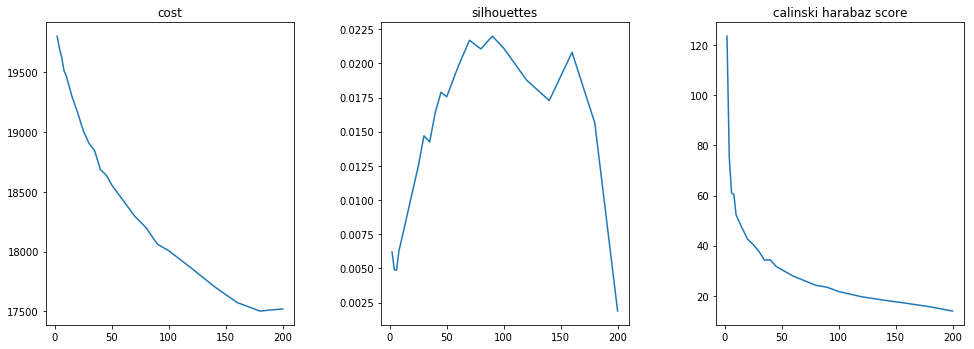

In [7]:
# Attempting Mini-Batch K means with some different number of centroids.
models, labels, costs, sil_avgs, ch_scores = runKmeansForMultipleCentroids(data)

In [8]:
##### Let's check some sample groups, their medoid documents, and two other closer documents.
def loadEscapedDoc(doc_id):
    return cgi.escape(loadDocument(doc_id).replace('$', '').replace('*', '')).replace('\n', '<br>')

def analyze_centroids(chosen_model, chosen_model_labels, data):
    tbl = ['<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr>']
    td_style = 'style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;"'
    groups = np.random.choice(chosen_model.n_clusters, 5, replace=False)
    print('Selected groups: {}'.format(groups))
    for i in groups:
        center = chosen_model.cluster_centers_[i]
        group_points = data[chosen_model_labels == i]
        group_doc_ids = ids[chosen_model_labels == i]

        # Let's find the medoid and their closest points
        distancesMatrix = pairwise_distances(group_points, metric='euclidean')
        closest_to_medoid_indexes = np.argsort(distancesMatrix.sum(axis=0))
        medoid_index = closest_to_medoid_indexes[0]

        medoid = group_doc_ids[medoid_index]
        closest1 = group_doc_ids[closest_to_medoid_indexes[1]]
        closest2 = group_doc_ids[closest_to_medoid_indexes[2]]
        tbl.append('<td %s>**%s**<br>%s</td>'
                   '<td %s>**%s**<br>%s</td>'
                   '<td %s>**%s**<br>%s</td>' % (
            td_style, medoid, loadEscapedDoc(medoid),
            td_style, closest1, loadEscapedDoc(closest1),
            td_style, closest2, loadEscapedDoc(closest2)))

    tbl.append('</tr></table>')
    printm('</tr><tr>'.join(tbl))

In [9]:
# Chosen number of centroids
chosen_i = 14 # Meaning 70 centroids
chosen_model = models[chosen_i]
chosen_model_labels = labels[chosen_i]
print('Chosen # of centroids: {}'.format(chosen_model.n_clusters))
print('Cost:                    %18.3f' % costs[chosen_i])
print('Silhouette avg:          %18.3f' % sil_avgs[chosen_i])
print('Calinski-Harabasz Index: %18.3f' % ch_scores[chosen_i])
analyze_centroids(chosen_model, chosen_model_labels, data)

Chosen # of centroids: 70
Cost:                             18297.541
Silhouette avg:                       0.022
Calinski-Harabasz Index:             26.047
Selected groups: [20 55 68 65  4]


<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**b38b0fe195e2a8374cd5856c323c204079ecccd1**<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!rutgers!igor.rutgers.edu!geneva.rutgers.edu!christian<br>From: hedrick@geneva.rutgers.edu<br>Newsgroups: soc.religion.christian<br>Subject: FAQ essay on homosexuality<br>Message-ID: &lt;May.11.05.06.28.1993.5458@geneva.rutgers.edu&gt;<br>Date: 11 May 93 09:06:30 GMT<br>Sender: hedrick@geneva.rutgers.edu<br>Lines: 452<br>Approved: christian@geneva.rutgers.edu<br><br>Someone referred to my FAQ essay on homosexuality.  Since it hasn't<br>been posted for some time (and I've modified it somewhat since the<br>last time), I'm taking this opportunity to post it.  There is another<br>entry in the FAQ containing comments by some other contributors.  They<br>can be retrieved from ftp.rutgers.edu as<br>pub/soc.religion.christian/others/homosexuality.  It contains far<br>more detail on the exegetical issues than I give here, though<br>primarily from a conservative point of view.<br><br>----------------------------<br><br>This posting summarizes several issues involving homosexuality and<br>Christians.  This is a frequently asked question, so I do not post the<br>question each time it occurs.  Rather this is an attempt to summarize<br>the postings we get when we have a discussion.  It summarizes<br>arguments for allowing Christian homosexuality, since most people<br>asking the question already know the arguments against it.  The most<br>common -- but not the only -- question dealt with herein is "how can a<br>Christian justify being a homosexual, given what the Bible says about<br>it?"<br><br>First, on the definition of 'homosexual'.  Many groups believe that<br>there is a homosexual "orientation", i.e. a sexual attraction to<br>members of the same sex.  This is distinguished from actual homosexual<br>sexual activity.  Homosexuals who abstain from sex are considered by<br>most groups to be acceptable.  However in a lot of discussion, the<br>term 'homosexual' means someone actually engaging in homosexual sex.<br>This is generally not accepted outside the most 'liberal' groups.  In<br>this paper I'm going to use 'homosexual' as meaning a person engaging<br>in sexual acts with another of the same sex.  I haven't heard of any<br>Biblical argument against a person with homosexual orientation who<br>remains celebate.<br><br>I think most people now admit that there is a predisposition to be<br>homosexual.  This is often called a 'homosexual orientation'.  It is<br>not known whether it is genetic or environmental.  There is evidence<br>suggesting each.  The best evidence I've seen is that homosexuality is<br>not a single phenomenon, but has a number of different causes.  One of<br>them is probably genetic.  There are several groups that try to help<br>people move from being homosexual to heterosexual.  The best-known is<br>Exodus International".  The reports I've seen (and I haven't read the<br>detailed literature, just the summary in the minority opinion to the<br>Presbyterian Church's infamous report on human sexuality) suggest that<br>these programs have very low success rates, and that there are<br>questions about how real even the successes are.  But there certainly<br>are people who say they have converted.  However this issue is not as<br>important as it sounds.  Those who believe homosexuality is wrong<br>believe it is intrinsically wrong, defined as such by God.  The fact<br>that it's hard to get out of being a homosexual is no more relevant<br>than the fact that it's hard to escape from being a drug addict.  If<br>it's wrong, it's wrong.  It may affect how we deal with people though.<br>If it's very difficult to change, this may tend to make us more<br>willing to forgive it.<br><br>One more general background issue: It's common to quote a figure that<br>10% of the population is homosexual.  I asked one of our experts where<br>this came from.  Here's his response: Kinsey (see below) is the source<br>of the figure 10 percent.  He defines sexuality by behavior, not by<br>orientation, and ranked all persons on a scale from Zero (completely<br>heterosexual) to 6 (completely heterosexual).  According to Kinsey,<br>one-third of all male adults have had at least one experience of<br>orgasm homosexually post puberty.  Ten percent of all adult males have<br>most of their experiences of homosexually.  That was in 1948.  The<br>percentages held true in a followup study done by the Kinsey<br>Institute, based on data in the early seventies but not published<br>until the early 80s or so, by Bell and Weinberg, I believe.  I can't<br>put my hand on this latter reference, but here is the online<br>information for Kinsey's own study as it appears in IRIS, the catalog<br>at Rutgers:<br>   AUTHOR Kinsey, Alfred Charles, 1894-1956.<br>    TITLE Sexual behavior in the human male [by] Alfred C. Kinsey. Wardell B.<br>          Pomeroy [and] Clyde E. Martin.<br>PUBLISHER Philadelphia, W. B. Saunders Co., 1948.<br>  DESCRIP xv, 804 p. diagrs. 24 cm.<br>    NOTES "Based on surveys made by members of the staff of Indiana<br>	  University, and supported by the National Research Council's <br>	  Committee for Research on Problems of Sex by means of funds <br>	  contributed by the Medical Division of the Rockefeller Foundation."<br>	   Bibliography: p. 766-787.<br>OTHER AUT Pomeroy, Wardell Baxter, joint author.  Martin, Clyde Eugene,<br>	  joint author.<br> SUBJECTS Sex.  U. S. -- Moral Conditions.<br>  LC CARD    48005195<br>This figure is widely used in all scholarly discussions and has even<br>been found to hold true in several other cultures, as noted in the<br>recent NEWSWEEK coverstory "Is this child gay?" (Feb. 24, 1992).  A<br>journalist is running the rounds of talk shows this season promoting<br>her book that allegedly refutes Kinsey's study, but the scholarly<br>world seems to take her for a kook......<br><br>I've seen some objections to the Kinsey's study, but not in enough<br>detail to include here.  (If someone would like to contribute another<br>view, I'd be willing to include it.)<br><br>Most Christians believe homosexuality (at least genital sex) is wrong.<br>Not all, however.  A few denominations accept it.  The Metropolitan<br>Community Churches is the best-known -- it was formed specifically to<br>accept homosexuals.  However the United Church of Christ also allows<br>it, and I think a couple of other groups may as well.  The Episcopal<br>Church seems to accept it some areas but not others.  In churches that<br>have congregational government, you'll find a few congregations that<br>accept it (even among Southern Baptists, though the number is probably<br>only one or two congregations).  But these are unusual -- few churches<br>permit homosexual church leaders.  How carefully they enforce this is<br>another issue.  I don't have any doubt that there are homosexual<br>pastors of just about every denomination, some more open than others.<br><br>As to the arguments over the Biblical and other issues, here's an<br>attempt to summarize the issues:<br><br>The most commonly cited reference by those favoring acceptance of<br>homosexuality in previous discussions has been John Boswell:<br>"Christianity, Social Tolerance, and Homosexuality", U Chicago Press,<br>1980.<br><br>The argument against is pretty clear.  There are several explicit laws<br>in the OT, e.g. Leviticus 20:13, and in Rom 1 Paul seems pretty negative on<br>homosexuality.  Beyond these references, there are some debates.  Some<br>passages often cited on the subject probably are not relevant.  E.g.<br>the sin which the inhabitants of Sodom proposed to carry out was<br>homosexual rape, not homosexual activity between consenting adults.<br>(There's even some question whether it was homosexual, since the<br>entities involved were angels.)  It was particularly horrifying<br>because it involved guests, and the responsibility towards guests in<br>that culture was very strong.  (This is probably the reason Lot<br>offered his daughter -- it was better to give up his daughter than to<br>allow his guests to be attacked.)  If you look through a concordance<br>for references to Sodom elsewhere in the Bible, you'll see that few<br>seem to imply that homosexuality was their sin.  There's a Jewish<br>interpretive tradition that the major sin was abuse of guests.  At any<br>rate, there's no debate that homosexual rape is wrong.<br><br>I do not discuss Leviticus because the law there is part of a set<br>of laws that most Christians do not consider binding.  So unless NT<br>justification can be found, Lev. alone would not settle the issue.<br><br>The NT references are all in Paul's letters.  A number of the<br>references from Paul are lists of sins in which the words are fairly<br>vague.  Boswell argues that the words occuring in these lists do not<br>mean homosexual.  Here's what he says: The two Greek words that appear<br>in the lists (i.e. I Cor 6:9 and I Tim 1:10) are /malakos/ and<br>/arsenokoitai/.  Unfortunately it is not entirely clear what the words<br>actually mean.  /malakos/, with a basic meaning of soft, has a variety<br>of metaphorical meanings in ethical writing.  Boswell suggests<br>"wanton" as a likely equivalent.  He also reports that the unanimous<br>interpretation of the Church, including Greek-speaking Christians, was<br>that in this passage it referred to masturbation, a meaning that has<br>vanished only in the 20th Cent., as that practice has come to be less<br>frowned-upon.  (He cites references as late as the 1967 edition of the<br>Catholic Encyclopedia that identify it as masturbation.)  He<br>translates /arsenokotai/ as male prostitute, giving evidence that none<br>of the church fathers understood the term as referring to<br>homosexuality in general.  A more technical meaning, suggested by the<br>early Latin translations, would be "active mode homosexual male<br>prostitute", but in his view Paul did not intend it so technically.<br><br>For a more conservative view, I consulted Gordon Fee's commentary on I<br>Cor.  He cites evidence that /malakos/ often meant effeminate.<br>However Boswell warns us that in Greek culture effeminate is not<br>necessarily synonymous with homosexual, though it may be associated<br>with some kinds of homosexual behavior.  Given what Boswell and Fee<br>say taken together, I suspect that the term is simply not very<br>definite, and that while it applies to homosexuals in some cases, it<br>isn't a general term for homosexuality.  While Fee argues against<br>Boswell with /arsenokotai/ as well, he ends up suggesting a<br>translation that seems essentially the same.  The big problem with it<br>is that the word is almost never used.  Paul's writing is the first<br>occurence.  The fact that the word is clearly composed of "male" and<br>"fk" unfortunately doesn't quite tell us the meaning, since it<br>doesn't tell us whether the male is the subject or object of the<br>action.  Examples of compound words formed either way can be given.<br>In theory it could refer to rapists, etc.  It's dangerous to base<br>meaning purely on etymology, or you'll conclude that "goodbye" is a<br>religious expression because it's based on "God by with ye".  However<br>since Boswell, Fee, and NIV seem to agree on "homosexual male<br>prostitute", that seems as good a guess as any.  Note that this<br>translation misses the strong vulgarity of the term however (something<br>which Fee and Boswell agree on, but do not attempt to reproduce in<br>their translation).<br><br>In my opinion, the strongest NT reference to homosexuality is Romans<br>1.  Boswell points out that Rom 1 speaks of homosexuality as something<br>that happened to people who were naturally heterosexual, as a result<br>of their corruption due to worshipping false gods.  One could argue<br>that this is simply an example: that if a homosexual worshipped false<br>gods, he would also fall into degradation and perhaps become<br>heterosexual.  However I find this argument somewhat forced, and in<br>fact our homosexual readers have not seriously proposed that this is<br>what Paul meant.<br><br>However I am not convinced that Rom 1 is sufficient to create a law<br>against homosexuality for Christians.  What Paul is describing in Rom<br>1 is not homosexuality among Christians -- it's homosexuality that<br>appeared among idolaters as one part of a whole package of wickedness.<br>Despite the impression left by his impassioned rhetoric, I'm sure Paul<br>does not believe that pagans completely abandoned heterosexual sex.<br>Given his description of their situation, I rather assume that their<br>heterosexual sex would also be debased and shameless.  So yes, I do<br>believe that this passage indicates a negative view of homosexuality.<br>But in all fairness, the "shameless" nature of their acts is a<br>reflection of the general spiritual state of the people, and not a<br>specific feature of homosexuality.<br><br>My overall view of the situation is the following: I think we have<br>enough evidence to be confident that Paul disapproved of<br>homosexuality.  Rom 1 seems clear.  While I Cor 6:9 and I Tim 1:10 are<br>not unambiguous and general condemnations of homosexuality, they do<br>not seem like wording that would come from someone who approved of<br>homosexuality or even considered it acceptable in some cases.  On the<br>other hand, none of these passages contains explicit teachings on the<br>subject.  Rom 1 is really about idolatry.  It refers to homosexuality<br>in passing.<br><br>The result of this situation is that people interpret these passages<br>in light of their general approach to Scripture.  For those who look<br>to Scripture for laws about issues such as this, it not surprising<br>that they would consider these passages to be NT endorsement of the OT<br>prohibition.  For those whose approach to the Bible is more liberal,<br>it is not surprising that they regard Paul's negative view of<br>homosexuality as something that he took from his Jewish upbringing<br>without any serious reexamination in the light of the Gospel.  As<br>readers of this group know by now, the assumptions behind these<br>approaches are so radically different that people tend to foam at the<br>mouth when they see the opposing view described.  There's not a lot I<br>can do as moderator about such a situation.<br><br>A number of discussions in the past centered around the sort of<br>detailed exegesis of texts that is described above.  However in fact<br>I'm not convinced that defenders of homosexuality actually base their<br>own beliefs on such analyses.  The real issue seems to rest on the<br>question of whether Paul's judgement should apply to modern<br>homosexuality.<br><br>One commonly made claim is that Paul had simply never faced the kinds<br>of questions we are trying to deal with.  He encountered homosexuality<br>only in contexts where most people would probably agree that it was<br>wrong.  He had never faced the experience of Christians who try to act<br>"straight" and fail, and he had never faced Christians who are trying<br>to define a Christian homosexuality, which fits with general Christian<br>ideals of fidelity and of seeing sexuality as a mirror of the<br>relationship between God and man.  It is unfair to take Paul's<br>judgement on homosexuality among idolaters and use it to make<br>judgements on these questions.<br><br>Another is the following: In Paul's time homosexuality was associated<br>with a number of things that Christians would not find acceptable.  It<br>was part of temple prostitution.  Among private citizens, it often<br>occured between adults and children or free people and slaves.  I'm<br>not in a position to say that it always did, but there are some<br>reasons to think so.  The ancients distinguished between the active<br>and passive partner.  It was considered disgraceful for a free adult<br>to act as the passive partner.  (This is the reason that an active<br>mode homosexual prostitute would be considered disgraceful.  His<br>customers would all be people who enjoyed the passive role.)  This<br>supports the idea that it would tend not to be engaged in between two<br>free adult males, at least not without some degree of scandal.<br>Clearly Christian homosexuals would not condone sex with children,<br>slaves, or others who are not in a position to be fully responsible<br>partners.  (However Fee's commentary on I Cor cites some examples from<br>ancient literature of homosexual relationships that do seem to involve<br>free adults in a reasonably symmetrical way.  Thus the considerations<br>in this paragraph shouldn't be pushed too far.  Homosexuality may have<br>been discredited for Jews by some of these associations, but there<br>surely must be been cases that were not prostitutes and did not<br>involve slaves or children.)<br><br>Some people have argued that AIDS is a judgement against<br>homosexuality.  I'd like to point out that AIDS is transmitted by<br>promiscuous sex, both homosexual and heterosexual.  Someone who has a<br>homosexual relationship that meets Christian criteria for marriage is<br>not at risk for AIDS.<br><br>Note that there is good reason from Paul's general approach to doubt<br>that he would concede homosexuality as a fully equal alternative,<br>apart from any specific statements on homosexuality.  I believe his<br>use of the Genesis story would lead him to regard heterosexual<br>marriage as what God ordained.<br><br>However the way Paul deals with pastoral questions provides a warning<br>against being too quick to deal with this issue legally.<br><br>I claim that the question of how to counsel homosexual Christians is<br>not entirely a theological issue, but also a pastoral one.  Paul's<br>tendency, as we can see in issues such as eating meat and celebrating<br>holidays, is to be uncompromising on principle but in pastoral issues<br>to look very carefully at the good of the people involved, and to<br>avoid insisting on perfection when it would be personally damaging.<br>For example, while Paul clearly believed that it was acceptable to eat<br>meat, he wanted us to avoid pushing people into doing an action about<br>which they had personal qualms.  For another example, Paul obviously<br>would have preferred to see people (at least in some circumstances)<br>remain unmarried.  Yet if they were unable to do so, he certainly<br>would rather see them married than in a state where they might be<br>tempted to fornication.<br><br>I believe one could take a view like this even while accepting the<br>views Paul expressed in Rom 1.  One may believe that homosexuality is<br>not what God intended, that it occured as a result of sin, but still<br>conclude that at times we have to live with it.  Note that in the<br>creation story work enters human life as a result of sin.  This<br>doesn't mean that Christians can stop working when we are saved.  The<br>question is whether you believe that homosexuality is in itself sinful<br>or whether you believe that it's a misfortune that is in a broad sense<br>due to human sinfulness.  If you're willing to consider the latter<br>approach, then it becomes a pastoral judgement whether there is more<br>damage caused by finding a way to live with it or trying to cure it.<br>The dangers of trying to cure it are that the attempt most often<br>fails, and when it does, you end up with damage ranging from<br>psychological damage to suicide, as well as broken marriages when<br>attempts at living as a heterosexual fail.<br><br>This is going to depend upon one's assessment of the inherent nature<br>of homosexuality.  If you believe it is a very serious wrong, then you<br>may be willing to run high risks of serious damage to get rid of it.<br>Clearly we do not generally suggest that people live with a tendency<br>to steal or with drug addiction, even though attempts to cure these<br>conditions are also very difficult.  However these conditions are<br>intrinsically damaging in a way that is not so obvious for<br>homosexuality.  (Many problems associated with homosexuality are<br>actually problems of promiscuity, not homosexuality.  This includes<br>AIDS.  I take for granted that the only sort of homosexual<br>relationships a Christian would consider allowing would be equivalent<br>to Christian heterosexual relationships.)<br><br>In the course of discussing this over the last decade or so, we've<br>heard a lot of personal testimony from fellow Christians who are in<br>this situation.  I've also seen summaries of various research and the<br>results of various efforts for "conversion".  (Aside from the<br>Presbyterian report mentioned above, there's an FAQ that summarizes<br>our readers' reports on this question.)  The evidence is that<br>long-term success in changing orientation is rare enough to be on a<br>par with healing miracles.  The danger in advising Christians to<br>depend upon such a change is clear: When "conversion" doesn't happen,<br>which is almost always, the people are often left in despair, feeling<br>excluded from a Church that has nothing more to say but a requirement<br>of life-long celibacy.  Paul recognized (though in a different<br>context) that such a demand is not practical for most people, and I<br>think the history of clerical celibacy has strongly reinforced that<br>judgement.  The practical result is that homosexuals end up in the gay<br>sex clubs and the rest of the sordid side of homosexuality.  Maybe<br>homosexuality isn't God's original ideal, but I can well imagine Paul<br>preferring to see people in long-term, committed Christian<br>relationships than promiscuity.  As with work -- which Genesis<br>suggests wasn't part of God's original ideal either -- I think such<br>relationships can still be a vehicle for people sharing God's love<br>with each other.<br><br>There's an issue of Biblical interpretation underlying this<br>discussion.  The issue is that of "cultural relativism".  That is,<br>when Paul says that something is wrong, should this be taken as an<br>eternal statement, or are things wrong because of specific situations<br>in the culture of the time?  Conservative Christians generally insist<br>on taking prohibitions as absolute, since otherwise the Bible becomes<br>subjective -- what is to stop us from considering everything in it as<br>relative?<br><br>When looking at this issue, it's worth noting that no one completely<br>rejects the concept of cultural relativism.  There are a number of<br>judgements in the New Testament that even conservative Christians<br>consider to be relative.  The following judgements are at least as<br>clear in the Bible as anything said on homosexuality:<br><br>  - prohibition against charging interest (this occurs 18 times in<br>	the OT -- it's not in the NT, but I mention it here because<br>	until relatively recently the Church did consider it binding<br>	on Christians)<br>  - prohibition against swearing oaths<br>  - endorsement of slavery as an institution<br>  - judgement of tax collectors as sinner<br><br>We do not regard these items as binding.  In most cases, I believe the<br>argument is essentially one of cultural relativism.  Briefly:<br><br>  - prohibition of interest is appropriate to a specific<br>	agrarian society that the Bible was trying to build,<br>	but not to our market economy.<br>  - few people believe that American judicial oaths have the<br>	same characteristics as the kind of oaths Jesus was<br>	concerned about<br>  - most people believe that Paul was simply telling people<br>	how to live within slavery, but not endorsing it as<br>	an institution<br>  - for people believe that the IRS is morally equivalent to<br>	Roman tax farming<br><br>The point I'm trying to make is that before applying Biblical<br>prohibitions to the 20th Cent., we need to look at whether the 20th<br>Cent. actions are the same.  When Christian homosexuals say that their<br>relationships are different than the Greek homosexuality that Paul<br>would have been familiar with, this is exactly the same kind of<br>argument that is being made about judicial oaths and tax collectors.<br>Until fairly recently Christians prohibited taking of interest, and<br>many Christians regarded slavery as divinely endorsed.  (Indeed,<br>slavery is one of the more common metaphors for the relationship<br>between God and human beings -- Christians are often called servants<br>or slaves of God.)<br><br>I am not trying to say that everything in the Bible is culturally<br>relative.  Rather, I'm trying to say that some things are, and<br>therefore it is not enough to say that because something appears in<br>the Bible, that ends the discussion.  We need to look at whether the<br>action we're talking about now has the same moral implications as the<br>one that the Bible was talking about.  If Christians want to argue<br>that there are reasons to think that the prohibitions against<br>homosexuality are still binding, I'm willing to listen.  Those who<br>claim that the question doesn't need to be looked at are kidding<br>themselves (unless they are part of the small minority who really obey<br>all the rules listed above).<br><br>One thing that worries me is the great emotions that this issue<br>creates.  When you consider the weakness of the Biblical evidence --<br>some laws in Leviticus, a passage in Rom whose subject matter is<br>really idolatry rather than homosexuality, and a couple of lists whose<br>words are ambiguous -- the amount of concern this is raising among<br>Christians seems rather out of proportion.  This should suggest to<br>people that there are reasons other than simply Biblical involved.<br>This is true on both sides -- clearly homosexual Christians are as<br>strongly motivated to find ways of discrediting the Biblical arguments<br>as conservative Christians are to find Biblical arguments.  But I<br>can't help feeling that the Bible is being used by both sides as a way<br>of justifying attitudes which come from other sources.  This is a<br>dangerous situation for Christians.<br><br>On the other side of the issue, I would like to note some problems I<br>have with the pro-homosexual position as it is commonly presented.<br>One of the most common arguments is that homosexuality is biologically<br>determined.  I.e. "God made me homosexual", and I have no choice.  I<br>think "God made me homosexual" is a fine view for people who already<br>believe on other grounds that homosexuality is acceptable.  But I<br>don't see it as an argument for acceptability.<br><br>Many people think that alcholism is largely biological, and drug<br>addiction may turn out to be as well.  That doesn't mean it's OK.<br>Most of us have particular things we tend to do wrong.  Some people<br>get angry easily.  Others tend to be arrogant.  Others tend to be<br>attraced to women who are married to someone else.  Homosexuality (if<br>we view it as wrong) wouldn't be different than any of these other<br>things.  If we are going to follow God, we all end up at one time or<br>another having to work to overcome bad habits and particular<br>temptations that cause us problems.  None of us can sit back and say<br>that because God made us the way we are we can just relax.  As Jesus<br>said, we all have to take up our cross daily.  This concept of dying<br>to self (which also appears throughout Paul's letters) seems to<br>suggest that there are going to be things about ourselves that we we<br>are called on not to accept.  Paul's letters and the experience of<br>Christians throughout history show us that sin is ingrained in us, and<br>the battle against it is lifelong and difficult.  The fact that<br>homosexuality is difficult to fight doesn't necessarily say it's OK.<br>Maybe this isn't the place where we have to die to self.  But I'd like<br>to make sure that those who think it isn't are fighting the battle<br>somewhere else, and not rejecting the concept that all Christians have<br>to fight against the deeply engrained habits of sin.<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**eca18ab039421f944ff3e47d7bf485e9267e6e02**<br>Xref: cantaloupe.srv.cs.cmu.edu soc.religion.christian:21565<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!rutgers!igor.rutgers.edu!geneva.rutgers.edu!christian<br>From: fortmann@superbowl.und.ac.za (Paul Fortmann - PG)<br>Newsgroups: soc.religion.christian<br>Subject: Praying for Justice<br>Message-ID: &lt;May.13.02.29.51.1993.1514@geneva.rutgers.edu&gt;<br>Date: 13 May 93 06:29:52 GMT<br>Sender: hedrick@geneva.rutgers.edu<br>Organization: University Of Natal (Durban)<br>Lines: 650<br>Approved: christian@aramis.rutgers.edu<br><br>I recently came across this article which I found interesting. I have <br>posted it to hear what other people feel about the issue.<br><br>I realise it is rather long (12 pages in Wordperfect) by may well be worth <br>the read.<br><br>Except for the first page (which I typed) the rest was scanned inusing <br>Omnipage. Some of the f's have come out as t's and visa-versa. I have tried <br>to correct as much as possible.<br><br><br>ABOUT THE AUTHOR<br><br>Peter Hammond is the founder of Frontline Fellowship, a<br>missionary organisation witnessing to the communist countries in<br>Southern Africa. He has also made several visits to many East<br>European countries.<br><br>FRONTLINE FELLOWSHIP NEWS                          ISSN 1018-144X<br><br>PRAYING FOR JUSTICE<br>(by Peter Hammond)<br><br>To those involved in ministering to Christians suffering<br>persecution the imprecatory Psalms are a tremendous source of<br>comfort. And those of us who are fighting for the right to life<br>of the preborn, or battling social evils such as pornography or<br>crime, are beginning to appreciate what an important weapon God<br>has entrusted to us in the imprecatory Psalms.<br><br><br>THE IMPRECATORY PSALMS<br><br>Early in my Christian walk I encountered the prayers for<br>judgement in the Psalms and was quite at loss to know how to<br>respond to them. Prayers such as:<br>"Break the arm of the wicked and evil men; call him to account for<br>his wickedness ..." Psalm 10:15 did not seem consistent with the<br>gospel of love which I had accepted. Yet Psalm 10:15 was clearly<br>motivated by love for God ("The Lord is King for ever and ever;<br>the nation will perish from His land" 10:16, and "Why does the<br>wicked man revile God? 10:13), and by love for the innocent who<br>suffer ("You hear, O Lord, the desire of the afflicted; You<br>encourage them, and You listen to their cry, defending the<br>fatherless and oppressed, in order that man, who is of the earth,<br>may terrify no more." 10:17-18)<br><br>Nevertheless, I grew increasingly uncomfortable reading such<br>graphic prayers for God to judge the wicked as: "Pour out your<br>wrath on them; let Your fierce anger overtake them" 64:24; "O<br>Lord, the God avenges, O God who avenges, shine forth. Rise up, O<br>Judge of the earth, pay back to the proud what they deserve."<br>95:1-2; "Break the teeth in their mouths, O God; ...let them<br>vanish like water .. let their arrows be blunted ... The<br>righteous will be glad when they are avenged, when they bathe<br>their feet in the blood of the wicked. Then men will way, "Surely<br>the righteous still are rewarded; surely there is a God who<br>judges the earth.'" 58:6-11<br><br>Certainly I wanted God to be honoured and yes I was deeply<br>destressed by the prevalence of evil -  but could I actually pray<br>for God to "pour out His wrath" on the wicked?<br><br>The scripture make it clear that these prayers are not to be<br>prayed for own selfish motives, nor against our personal enemies.<br>Rather they are to be prayed in Christ, for His glory and against<br>His enemies. The psalmist describes the targets of these<br>imprecation as: those who devise injustice in their heart and<br>whose hands mete out violence (58:2) those who "boast of evil"<br>and "are a disgrace in the eyes of God. Your tongue plots<br>destruction, it is like a sharpened razor, and you who practise<br>deceit. You love evil rather than good, falsehood rather than<br>speaking the truth." 52:1-3; "They crush your people ... They<br>slay the widow and the alien; they murder the fatherless." 94:5-<br>6; "With cunning they conspire against Your people; they plot<br>against those You cherish." 83:3; "You hate all who do wrong. You<br>destroy those who tell lies; bloodthirsty and deceitful men the<br>Lord abhors." 5:5-6.<br><br>To those unrepentant enemies of God the psalmist declares:<br>"Surely God will bring you down to everlasting ruin" 52:5;<br>"Surely God will crush the heads of His enemies ... of those who<br>go on in their sins" 68:21.<br><br>And the purpose of these prayers for justice is declared: "Then<br>it will be known to the ends of the earth that God rules ..."<br>59:13; "to proclaim the powers of God" 68:34; "All kings will bow<br>down to Him and all nations will serve Him " 72:11; "Who knows<br>the power of Your anger? For Your wrath is as great as the fear<br>that is due You. " 90:11<br><br>Yet despite the fact that 90 of the 150 Psalms include<br>imprecations (prayers invoking God's righteous judgement upon the<br>wicked) such prayers are rare in the average Western church.<br>However, amongst the persecuted churches these prayers are much<br>more common.<br><br><br>PRAYING AGAINST THE PERSECUTORS<br><br>Amidst the burnt out churches and devastation of Marxist Angola I<br>found the survivors of communist persecution including the<br>crippled and maimed, and widows and orphans praying for God to<br>strike down the wicked and remove the persecutors of the Church.<br>I was shocked - yet it was Biblical (Even the martyrs in heaven<br>pray "How long, Sovereign Lord, holy and true, until you judge<br>the inhabitants of the earth and avenge our blood?" Revelation<br>6:10).<br><br>The initiator of the communist persecution in Angola was Agestino<br>Neto. Described as a "drunken, psychotic, marxist poet", Neto had<br>been installed by Cuban troops as the first dictator of Angola.<br>He boasted that: "Within 20 years there won't be a Bible or a<br>church left in Angola. I will have eradicated Christianity." Yet<br>despite the vicious wave of church burning and massacres it is<br>not Christianity that was eradicated in Angola but Agestino Neto.<br>Neto died in mysterious circumstances on an operating table in<br>Moscow.<br><br>In Romania I learnt of a series of remarkable incidents recorded<br>of God judging the persecutors of the Church in answer to prayer:<br>    A communist official ordered a certain pastor to be<br>     arrested. the next day the official died of a heart attack.<br>    Another communist party official ordered that all the Bibles<br>     in his district were to be collected and pulped, to be<br>     turned into toilet paper. This blasphemous project was in<br>     fact carried out. But the next day when the official was<br>     medically examined, he was informed that he had terminal<br>     cancer. He died shortly afterwards.<br>    On another occasion, a communist official who had ordered a<br>     Baptist church to be demolished by bulldozers died in a car<br>     crash the very next day.<br>    When an order was given to dismantle a place of worship on<br>     the mountainside in a forest, the workmen flatly refused to<br>     carry out the order. At gunpoint a group of conscripted<br>     gypsies also refused to touch the church. In desperation,<br>     the communist police forced prisoners at bayonet-point to<br>     dismantle the structure. Yet the officer in charge pleaded<br>     with the local Christians to pray for him, that God would<br>     not judge him. He emphasised that he had nothing against<br>     Christians and was only obeying strict orders. The building<br>     was in fact reconstructed later, and again used for worship.<br>     "They were all seized with Sear and the Name of the Lord<br>     Jesus was held in high honour... in this way the Word of the<br>     Lord spread widely and grew in power. " Acts 19:17,20<br><br>Nicolae Ceaucescu the dictator who ordered much of the<br>persecution in Romania was overthrown by his own army and<br>executed on Christmas day, 1989, to joyous shouts of "the<br>antiChrist is dead" in the streets. Many testified that this was<br>in answer to the fervent prayers of the long suffering people of<br>Romania.<br><br>Another persecutor of the Church who challenged God was Samora<br>Machel, the first dictator of Marxist Mozambique. Samora Machel<br>was a cannibal who ate human flesh in witchcraft ceremonies in<br>the 1960's. He pledged his soul to Satan and vowed that he would<br>destroy the Church and turn Mozambique into the first truly<br>Marxist-Leninist state in Africa. Thousands of churches in<br>Mozambique were closed confiscated, "nationalised" chained and<br>padlocked, burnt down or boarded up. Missionaries were expelled,<br>some being imprisoned first. Evangelism was forbidden. Bibles<br>were ceremonially burnt and tens of thousands of Christians,<br>including many pastors and elders, were shipped off to<br>concentration camps - most were never seen again.<br><br>A month before his sudden death Samora Machel cursed God publicly<br>and challenged Him to prove His existence by striking him<br>(Machel) dead. On 19 October 1986, while several churches were<br>specifically praying for God to stop the persecution in<br>Mozambique, Machel's Soviet Tupelov aircraft crashed in a violent<br>thunderstorm. The plane crashed 200 metres within South Africa's<br>boundary with Mozambique. Amidst the wreckage the marxist plans<br>for overthrowing the government of Malawi were discovered and<br>published. Not only had God judged a blasphemer and a persecutor,<br>but He had also saved a country from persecution.<br><br>In the months leading up to the first multi-party elections in<br>Zambia many churches fasted and prayed tor God to remove the 27<br>year socialist dictatorship of Kenneth Kaunda. This was done on<br>31st October 1991 when Fredrick Chiluba (a man converted to<br>Christ whilst imprisoned for opposing Kaunda) was elected<br>president of Zambia and covenanted to make Zambia a Christian<br>country.<br><br>It is recorded in history that the wicked Mary, Queen of Scots,<br>declared trembling and in tears: "I am more afraid of John Knox's<br>prayers than of an army of ten thousand".<br><br>On 3 April 1993 the Secretary General of the South African<br>Communist Party Chris Hani was shot dead. From the unprecedented<br>international wave of condolences and adulation reported one<br>could be forgiven for assuming that this man was a saint and a<br>martyr. Certainly it was not the death and resurrection of Christ<br>Jesus which dominated the thoughts and headlines of South Africa<br>this Easter, but the assassination of Chris Hani.<br><br>The stunning hypocrisy of the situation is that 20 135 people<br>were murdered in South Africa in 1992, yet more collective<br>concern and anguish were reported over the death of the head of<br>the SA Communist Party than for all the thousands of other<br>victims. Indeed the SA government, the international community<br>and the mass media have apparently had greater sorrow reported<br>over this one death than for all the 50 000 South Africans<br>murdered since 2nd February 1990 when the ANC, SACP and PAC were<br>unbanned!<br><br>Yet as a member of the ANC Revolutionary Council since 1973,<br>Deputy Commander of Umkhonto we Sizwe (MK) the ANC's "military<br>wing" - from 1982, and Chief of Staff of MK from 1987, Chris Hani<br>had approved and ordered bombings and assassinations of many<br>unarmed civilians. As Jesus warned: "all who live by the sword<br>will die by the sword " Matt 26:52.<br><br>After personally confronting Hani about his terrorist activities<br>at a press conference in Washington DC (where he publicly<br>declared his support for Fidel Castro, Col. Gaddafi, Yasser<br>Arafat and Saddam Hussein and defended the placing of car bombs<br>and limpet mines in public places during "the struggle") I told<br>him that I was a Christian and, while I didn't hate him, I did<br>hate communism and I was praying for him - that God would either<br>bring him to repentance and salvation in Christ, or that God<br>would remove him. He responded by swearing and declaring that he<br>was an atheist.<br><br>Several other people also prayed that God would either bring Hani<br>to repentance or remove him. Similarly several churches in<br>America have begun to pray the imprecatory Psalms against<br>unrepentant abortionists. In one town 8 abortionists were struck<br>down, with heart attacks, strokes, car accidents and cancer,<br>within months of these public prayers for God to stop these<br>killers of preborn babies.<br><br>Some praised God for His righteous acts of judgement and quoted:<br>"When justice is done, it brings joy to the righteous and terror<br>to evildoers " Proverbs 21:15. Others were shocked that any<br>Christian could express satisfaction at the misfortune of any -<br>even of the blatantly wicked. Yet the Apostles prayed imprecatory<br>prayers (Acts 13:8-12; Galatians 1:8-9; 2 Tim 4:14-15) and so did<br>our Lord (Matt 11:20-24).<br><br>What then should our attitude towards the imprecatory Psalms be?<br>Should we be praying the Psalms? To tackle these thorny issues I<br>would like to present a short summary of an excellent book, "War<br>Psalms of the Prince of Peace - Lessons From The Imprecatory<br>Psalms" by James E Adams, (published by the Presbyterian and<br>Reformed Publishing Company):<br><br>Our Lord Jesus Christ &amp; His apostles used the Psalms constantly<br>in teaching men to know God. The New Testament (NT) quotes the<br>Old Testament (OT) over 283 times. 41% of all OT quotes in the NT<br>are from the Psalms. Christ Himself alluded to the Psalms over 50<br>times. The Psalms are the Prayer Book of the Bible.<br><br><br>1. Are the imprecatory Psalms the oracles of God?<br><br>Some Christian commentators &amp; theologians reject these Psalms as<br>"devilish", "diabolical ", "unsuited to the church", and "Not God<br>'s pronouncements of His wrath on the wicked; but the prayers of<br>a man for vengeance on his enemies, just the opposite of Jesus'<br>teaching that we should love our enemies. "<br><br>Yet 2 Tim 3:16-17 declares:<br>"All Scripture is God breathed and is useful for teaching,<br>rebuking, correcting and training in righteousness, so that the<br>man of God may be thoroughly equipped for every good work. "<br>(see also 2 Peter 3:15-16).<br><br>The fact that something in the Word of God is beyond our<br>comprehension is not grounds to denying or even questioning its<br>inspiration. To make ourselves the judge of what is good or evil<br>is to impudently take the place of God.<br><br>Do we imagine ourselves to be holier than God? Wrong ideas of God<br>have led many to become "evangelic plastic surgeons who have made<br>it their job to "clean up" God's Word according to their own<br>ideas of what is proper. They have forgotten that it is God alone<br>who must determine what Christianity is and what is suitable for<br>His Church. The essence of what many have done is to question the<br>authority of God's Word (like Eve's original sin of listening to<br>Satan's question "Yes, hath God said... ?").<br><br>The Psalms are part of God's revelation of Himself and His<br>attributes, and they are reaffirmed by the NT as the<br>authoritative Word of God. Those imprecatory Psalms which these<br>evangelical plastic surgeons reject as "unsuited" and "unworthy"<br>for the Church are the very Psalms Christ used to testify about<br>Himself (eg: Mark 12:36; Matt 22:43-44) and which the Apostles<br>used as authoritative Scripture (eg: Acts 1:16-20; Acts 4:25; Heb<br>4:7). See also: 2 Samuel 23:1-2.<br><br>CH Spurgeon said concerning the imprecatory Psalms, (especially<br>Ps 109):<br>"Truly this is one of the hard places of Scripture, a passage<br>which the soul trembles to read, yet it is not ours to sit in<br>judgement upon it, but to bow our ear to what the Lord would<br>speak to us therein. "<br><br>The rejection of any part of God's Word is a rejection of the<br>giver of that Word, God Himself.<br><br><br>2. Who is praying these Psalms?<br><br>Christ quoted the Psalms not merely as prophesy; He actually<br>spoke the Psalms as His own words. The Psalms occupied an<br>enormous place in the life of our Lord. He used it as His prayer<br>book and song book - from the Synagogue to the festivals and at<br>the Last Supper.<br><br>On the cross Christ quoted from the Psalms - not as some ancient<br>authority that He adapted for His own use, but as His very own<br>words - the words of the Lord's Anointed - which as David's Son<br>He truly was.<br>"Father, into your hands I commit my Spirit" Ps 31:5<br>"My God, My God, why have you forsaken me?" Ps 22:1<br><br>In His ministry Christ foretells what He will say as the Judge on<br>the day of judgement, and He quotes the Psalms in doing so!<br>Matt 7:23 "Then I will tell them plainly, 'I never knew you. Away<br>from me, you evildoers'. " Ps 6:8<br><br>In Heb 10:5 the apostle attributes Ps 40:6-8 directly to Christ<br>although nowhere in the Gospels is Christ recorded as having said<br>these words. Similarly Hebrews 2 : 12 attributes Ps 22:22<br>directly to Christ despite there being no record of His having<br>spoken these words while on earth. Clearly the apostles believed<br>Christ is speaking in the Psalms.<br><br>Christ came to establish His kingdom and to extend His mercy in<br>all the earth. But let us never forget that Jesus will come again<br>to execute Judgement on the wicked.<br>David as the anointed king of the chosen people of God was a<br>prototype of Jesus Christ. Acts 2:30:<br>"being therefore a prophet, ... he foresaw and spoke of the<br>resurrection of Christ. "<br>David was a witness to Christ in his office, in his lite, and in<br>his words. The same words which David spoke, the future Messiah<br>spoke through him. The prayers of David were prayed also by<br>Christ. Or better Christ Himself prayed these Psalms through His<br>forerunner David.<br><br>The imprecatory Psalms are expressions of the infinite justice of<br>God, of His indignation against wrong doing, and His compassion<br>for the wronged.<br><br><br>3. But what about the Psalms of repentance?<br><br>Christ is also the Lamb of God, the substitutionary sacrifice for<br>our sins. Christ in the day of His crucifixion was charged with<br>the sin of His people. He appropriated to Himself those debts for<br>which He had made Himself responsible. Our Lord was the<br>substitution for the sinner. He took the sinners place (Isaiah<br>53).<br><br>"God made Him who had no sin to be sin for us, so that in Him we<br>might become the righteousness of God. " 2 Cor 5:21<br><br>In history the Psalms, especially the imprecatory Psalms, have<br>been understood to have been the prayers of Christ by: St<br>Augustine, Jerome, Ambrose, Tertullian, Luther and many others.<br>All the Psalms are the voice of Christ. Christ is praying the<br>imprecatory Psalms! All the Psalms are messianic. It is the Lord<br>Jesus Christ who is praying these prayers of vengeance. It is<br>only right for the righteous King of Peace to ask God to destroy<br>His enemies.<br><br>These prayers signal an alarm to all who are still enemies of<br>King Jesus. His prayers will be answered! God's Word is revealed<br>upon all who oppose Christ. Anyone who rejects God's way of<br>forgiveness in the cross of Christ will bear the dreadful curses<br>of God.<br><br>He who prays Psalm 69:23-28 will one day make this prayer a<br>reality when He declares to those on His left:<br>"Depart from me you who are cursed into the eternal fire prepared<br>for the devil and his angels. " Matt 25:41<br><br>All the enemies of the Lord need to hear these Psalms. God's<br>Kingdom is at War. The powers of evil will tall and God alone<br>will reign forever!<br>"With justice He judges and makes war...out of His mouth comes a<br>sharp sword with which to strike down the nations. He will rule<br>them with an iron sceptre; He treads the winepress of the fury of<br>the wrath of God Almighty...King of Kings and Lord of Lords. "<br>Rev 19 : 15<br><br><br>4. Are Jesus' prayers contradictory?<br><br>What about Jesus' command to love our enemies and to bless those<br>who curse us (Matt 5:44)?<br><br>Christ is of course the loving and merciful Saviour who forgives<br>sin; but He is also the awesome Judge who is coming in Judgement<br>on those who disobey His Gospel.<br><br>"God is just. He will pay back trouble to those who trouble you<br>and give relief to you who are troubled...This will happen when<br>the Lord Jesus is revealed from heaven in blazing fire with His<br>powerful angels. He will punish those who do not obey the Gospel<br>of our Lord Jesus. They will be punished with everlasting<br>destruction and shut out from the presence of the Lord and from<br>the majesty of His power on the day He comes to be glorified in<br>His holy people and to be marvelled at among au those who have<br>believed. " 2 Thess 1:6-10<br><br>Jesus has power on earth to forgive sins, and He has power on<br>earth to execute judgement upon His enemies. In the Psalms we see<br>both the vengeance and the love ot God.<br><br>Even in the N.T. &amp; in the Gospels we see imprecations.<br>"Woe to you,...hypocrites...blind guides...blind fools...full of<br>greed and self indulgence...whitewashed tombs...you snakes! You<br>brood of vipers! How will you escape being condemned to Hell ? "<br>Matt 23<br><br>In Matt 26:23-24 Christ quotes from Ps 69 and 109 to refer to His<br>betrayal by Judas.<br><br>We also need to acknowledge that Christ's prayers of blessing are<br>not for all. In John 17:6-9 it is clear that Christ is only<br>praying to the elect of God - those who have:<br>"obeyed your Word"... "accepted" God's Word ... and have<br>"believed ". (see Luke 10:8-16 - Those who reject the<br>message of God's kingdom will be judged.)<br><br><br>5. May we pray the imprecatory Psalms?<br><br>Martin Luther pointed out that when one prays: "Hallowed be Thy<br>Name, Thy Kingdom come, Thy will be done " then "he must put all<br>the opposition to this in one pile and say: 'Curses, maledictions<br>and disgrace upon every other name and every other kingdom. May<br>they be ruined and torn apart and may all their schemes and<br>wisdom and plans run aground' . "<br><br>To pray tor the extension of God's kingdom is to solicit the<br>destruction of all other kingdoms, eg: Dan 2:44: "The God of<br>heaven will set up a kingdom that will never be destroyed ... it<br>will crush all those kingdoms and bring them to an end, but it<br>will itself endure forever. "<br><br> Advance and victory for the Church means defeat and retreat for<br>the kingdom of darkness. <br><br>There is a life &amp; death struggle between two kingdoms. The Church<br>cannot exclude hatred tor satan's kingdom from its love for God's<br>kingdom. God's kingdom cannot come without satan's kingdom being<br>destroyed. God's will cannot be done on earth without the<br>destruction of evil. The glory of God demands the destruction of<br>evil. Instead of being influenced by a sickly sentimentalism<br>which insists upon the assumed, but really non-existent, rights<br>of man - we should focus instead upon the rights of God.<br><br>Note Psalm 83 where the Psalmist prays against those who "plot<br>together" against God and His people:<br>"Cover their faces with shame so that men will seek your Name O<br>Lord... Do to them as You did to Midian, as you did to Sisera and<br>Jabin at the river Kishon, who perished at Endor and became like<br>refuse on the ground. "<br><br>The story of Sisera in the book of Judges (Chapter 4 and 5)<br>provides a vivid example of God's judgement on the wicked. Sisera<br>"cruelly oppressed the Israelites for twenty years" and they<br>"cried to the Lord for help" Judges 4:3. In response to those<br>prayers: "The Lord routed Sisera and all his chariots and army by<br>the sword, and Sisera abandoned his chariot and fled on foot...<br>All the troops of Sisera fell by the sword; not a man was left. "<br>Judges 4:15-16<br><br>The account then goes on to describe how Sisera escaped to the<br>tent of Jael where she lulled him into a false sense of safety<br>and then drove a tent peg through his temple with a hammer. The<br>song of victory by Deborah and Barak celebrated the crushing of<br>the head of Sisera in graphic detail (Judges 5:25-27). And it is<br>this that Psalm 83 implores God to again do to His enemies.. "As<br>you did to Sisera ..."<br><br><br>6. The blessings of obedience and the curse of disobedience<br><br>The imprecatory Psalms are fully consistent with the Law of God:<br>     "If you do not carefully follow all the words of this Law,<br>     which are written in this book, and do not revere this<br>     glorious and awesome Name - the Lord your God - the Lord<br>     will send fearful plagues on you and your descendants. He<br>     will bring upon you all the diseases of Egypt that you<br>     dreaded, and they will cling to you. The Lord will also<br>     bring on you every kind of sickness and disaster not<br>     recorded in this Book of the Law until you are<br>     destroyed...because you did not obey the Lord your God ...<br>     so it will please Him to ruin and destroy you. You will be<br>     uprooted from the land you are entering to possess. "<br>     Deuteronomy 28:58-63<br><br>The covenant God made with His people included curses for<br>disobedience as well as blessings for obedience. Deuteronomy 27<br>records the formal giving and receiving of the covenant terms in<br>an awesome account:<br>"The Levites shall recite to all the people of Israel in a loud<br>voice:<br>"Cursed is the man who carves an image or casts an idol - a thing<br>detestable to the Lord, the work of the craftsman's hands - and<br>sets it up in secret. "<br>Then all the people shall say, "Amen!" "<br>"Cursed is the man who dishonours his father or his mother...<br>"Cursed is the man who moves his neighbour's boundary stone...<br>"Cursed is the man who leads the blind astray on the roads...<br>"Cursed is the man who withholds justice from the alien, the<br>fatherless or the widow...<br>"Cursed is the man who kills his neighbour secretly...<br>"Cursed is the man who accepts a bribe to kill an innocent<br>person.<br>"Cursed is the man who does not uphold the words of the Law by<br>carrying them out.<br>Then all the people shall say, "Amen!" " Deut 27:14-26<br><br>The New Testament confirms that the inevitable consequence of<br>rejecting Christ is the curse. "If anyone does not love the<br>Lord - a curse be on him. " 1 Corinthians 16:22<br><br>(See also: Romans 12:19-21; Hebrews 1:1-3; 3:7-12; 3:1519; 10:26-<br>31; 12:14-29.)<br><br><br>7. How can we preach these prayers?<br><br>The Church of Jesus Christ is an army under orders.<br>Scripture constitutes the official dispatch from the Commander-<br>in-Chief. But we have a problem: those who are called to pass on<br>those orders to others are refusing to do so. How then can we<br>expect to be a united, effective army? Is it any wonder that the<br>troops have lost sight of their commission to demolish the<br>strongholds of the kingdom of darkness? If the Church does not<br>hear the battle cries of her Captain, how will she follow Him<br>onto the battlefield?<br><br>Pastors are commissioned to pass on the orders of the Church's<br>Commander, never withholding or changing His words. One whose job<br>is to carry dispatches to troops in wartime would face certain<br>and severe punishment if he dared to amend the general's orders.<br>The pastor's charge is of greater importance than that of a<br>courier in any earthly army. There's no place tor the dispatcher<br>to decide he doesn't agree with his Commander's strategy.<br><br>When Jesus Christ sent seventy-two disciples on a preaching<br>mission, He told them to proclaim the coming of God's Kingdom (Lk<br>10:9) - that is, to announce that people must submit to God's<br>rule in their lives. Jesus instructed them to pray for peace on<br>any house they approach, assuring them that if anyone rejected<br>it, the peace would return on the disciples (verse 5). But we<br>must consider what He said they should do if their message were<br>rejected - that is, if the hearers persisted in rebellion against<br>God's rule - "But when you enter a town and are not welcomed, go<br>into its 'streets and say, 'Even the dust of your town that<br>sticks to our feet we wipe off against you. Yet be sure of this:<br>The kingdom of God is near"' Luke 10:11.<br><br>What would be the result of that denunciation? I tell you, it<br>will be more bearable on that day for Sodom [on which God sent<br>fire from Heaven in judgement for its wickedness] than for that<br>town (verse 12). Immediately Jesus added curses on Korazin,<br>Bethsaida, and Capernaum tor their rejection of His message<br>(verses 13-15). He then explained to the disciples the great<br>authority He had given them: "He who listens to you listens to<br>Me; he who rejects you rejects Me; but he who rejects Me rejects<br>him who sent Me " (verse 16). This is the fundamental basis tor<br>calling down God's curses on anyone: his persistent rebellion<br>against God's authority expressed in His Law and the ministry of<br>His servants.<br><br>We need to clearly and forcefully proclaim the war cries of the<br>Prince of Peace. Only then will the Church awake from its<br>lethargy and once again enter the battle. If we tail to pass on<br>the battle cry then a lack of urgency and confusion in the ranks<br>will be inevitable.<br><br>Like Psalm 1 our preaching needs to clearly show the blessings of<br>obedience and the curse of disobedience. The eternal truth is<br>that God cannot be mocked. Whatever a man sows - that shall he<br>reap (Galatians 6:7). The curses pronounced on disobedience in<br>Deut 28:47-53 were fulfilled in detail in Samaria (2 Kings<br>6:2&amp;29) and in Judea (AD 70). The wrath of God upon covenant<br>breakers is real.<br><br>The "I" of the Psalms is Jesus Christ. The "we" of the Psalms<br>includes those of us in the Lord Jesus. The enemies are not our<br>own, individually, but those of the Lord and of His Church. The<br>Psalms are ot Christ as Prophet, Priest, and King. They record<br>Christ's march in victory against the kingdom of darkness. As<br>Christ is the author of the Psalms, so, too, is He the final<br>fulfilment of the covenant on which they are based. God will<br>answer the psalmist's prayers completely in Jesus Christ on the<br>final day of judgment. While on earth Jesus foretold the day when<br>He will say: "But those enemies of Mine who did not want Me to be<br>King over them - bring them here and kill them in front of Me"<br>Luke 19:27.<br><br>A fatal end awaits everyone who refuses to acknowledge and to<br>obey Jesus as King and Lord. Hearing expositions of these war<br>psalms of the Prince of Peace will remind His people that God's<br>kingdom is at war! The kingdom of darkness is being overcome by<br>the kingdom of Jesus Christ, a war in which each local<br>congregation of believers plays a vital part. You must rally your<br>battalion to put on the whole armour of God, including "the sword<br>of the Spirit, which is the Word of God " Eph 6:17. That battle-<br>readiness also involves "pray(ing) in the Spirit on all occasions<br>with all kinds of prayers and requests n Eph 6:18.<br><br>Christ teaches His army to pray for the utter destruction of the<br>enemies of God as the psalmist did: "Pour out Your wrath on the<br>nations that do not acknowledge You, on the kingdoms that do not<br>call on Your Name" Ps 79:6.<br><br>To deal with the very real hurts and injustices in this world it<br>is necessary for us to pray for God's justice. Those who are<br>persecuted need the comfort of these prayers.<br><br>"Let the saints rejoice in His honour and sing for joy...May the<br>praise of God be in their mouths and a double-edged sword in<br>their hands, to inflict vengeance on the nations and punishment<br>on the peoples, to bind their kings with fetters, their nobles<br>with shackles of iron, to carry out the sentences written against<br>them. This is the glory of all His saints. Praise the Lord. " Ps<br>149:5-9<br><br>Prayer is, in fact, spiritual warfare. One weapon is prayer for<br>conversion of spiritual enemies; another is prayer for judgement<br>on those who finally refuse to be converted. We handicap the army<br>of God when we refuse to use both of these great weapons that He<br>has given us. It is at all times a part of the task of the people<br>nf God to destroy evil.<br><br>If you have been guilty of dulling your sword, by neglecting or<br>undermining these psalms, repent of that sin, sharpen your sword<br>anew, and go forth to do battle in the Name and for the Glory of<br>Jesus - until "the knowledge of the Lord will cover the earth as<br>the waters cover the sea" Hab 2:14.<br><br>The full book "War Psalms of the Prince of Peace " is available,<br>at R25, from Frontline Fellowship, PO Box 74 Newlands, 7725 RSA.<br><br><br>PERMISSION TO REPRODUCE<br>Those wishing to reproduce or quote from any edition of FF News<br>are encouraged to do so. We only request that due acknowledgement<br>of the source be mentioned and that a copy be sent to us.<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**dd244bc8d9fa6eac49a89e2ba486e35acaac9a76**<br>Xref: cantaloupe.srv.cs.cmu.edu soc.religion.christian:21662<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!ames!pacbell.com!att-out!rutgers!igor.rutgers.edu!geneva.rutgers.edu!christian<br>From: af664@yfn.ysu.edu (Frank DeCenso, Jr.)<br>Newsgroups: soc.religion.christian<br>Subject: Re: _Christianity In Crisis_<br>Message-ID: &lt;May.18.00.54.53.1993.9551@geneva.rutgers.edu&gt;<br>Date: 18 May 93 04:54:54 GMT<br>Sender: hedrick@geneva.rutgers.edu<br>Organization: Youngstown State/Youngstown Free-Net<br>Lines: 371<br>Approved: christian@aramis.rutgers.edu<br><br>From Bit.listserv.christia<br><br>Zane writes...<br> <br>From: FACN34B@SAUPM00.BITNET (zane of dhahan)<br>&gt;Newsgroups: bit.listserv.christia<br>Subject: Christianity in Crisis<br>Date: Wed May 12 14:43:19 1993<br> <br>"Frank, first of all, thanks for all of the great Scripture verses.  It<br>was a pleasure to read them."<br> <br>MY REPLY...<br>You are welcome, Zane.<br> <br>Zane...<br>"I am sure nothing that I will say will change your mind about it... but I<br>would like to ask you if the book in question really does anything for you.<br>I mean, were you all caught up in the word/faith thing, but now that you<br>have read the book you've been rescued from all of the error and pain that<br>will result in your Christian life?"<br> <br>MY REPLY...<br>(1) When I first became a Christian, I entered into the Word/Faith<br>    movement.  It was easy.  I wasn't grounded in the Word of God and sound<br>    doctrine.  When I visited Christian book stores, the cheapest books I<br>    could find to buy were the .50 and 1.00 books by Hagin and others.<br>    Consequently, I began receiving Hagin's monthly magazine (and they<br>    still send it to me), and also Copeland's (also, still sent to me).<br>    It wasn't until I read a booklet by Jimmy Swaggart called _Hyper Faith:<br>    The New Gnosticism_ that I began to realize the teachings I were<br>    partaking of were error.  I started reading the Bible more and studying<br>    more.  Sure enough, Jimmy was right in many points.  As part of my<br>    experience, I am alerting Christians, particularly new Christians, that<br>    these teachings are heretical and they need to do as the Bereans did in<br>    Acts 17:11 - check these teachings out with Scripture!<br> <br>(2) My brother in law was involved in a Word/Faith "cult" in my area - it's<br>    leader is real good friends with Benny Hinn.  Rather then going into<br>    much detail about this, suffice it to say he was deceived, mistreated, and<br>    has now fallen into atheism.  I'm still praying for him (Phil. 1:6).<br> <br>(3) The assistant pastor at the church I teach adult Sunday School in has been<br>    a `follower' of Copeland for 15 years.  He has thousands of tapes by the<br>    Faith teachers.  In the class recently, I quoted several of the teachers'<br>    heretical statements to his surprise.  Since then, I've been able to talk<br>    to him at length about these issues.<br> <br>(4) The leader of the Women's Group at my church is a Benny Hinn `fan'.<br>    Recently, I found that she has been lending _Good Morning, Holy Spirit_ to<br>    women in the church.  That prompted my quotes in Sunday School, as well as<br>    my lending CIC to people in the church.<br> <br>I'm well aware of the abuses and heresies perpetrated in this movement and<br>have an urgency in my heart and life to warn people about the heresies.<br>What heresies?<br>    A. Jesus became sin - took on the very nature of the devil, and became<br>        one with him.<br>    B. Jesus' death on the cross wasn't enough to atone.<br>    C. Jesus was dragged to hell after His death, was beat and abused by<br>        Satan and demons, thus finishing our atonement.  Satan was ruling<br>        over Him there.<br>    D. Jesus was `born-again' in hell.<br>    E. Jesus died spiritually, lost His divinity, and reassumed it after<br>        the resurrection.<br>    F. We are gods.<br> <br>These are heresies.  Documentation will be provided re: these teachings<br>upon request.<br> <br>Zane...<br>"Or what does it do for you?  Is it preventing you from going out and<br>joining up with the word/faith movement which you'd been contemplating<br>joining for so long, but now that you've read the book, you've been saved<br>from all of that?"<br> <br>MY REPLY...<br>It wasn't _Christianity In Crisis_ that helped me; it was a booklet by<br>Swaggart that I mentioned above.  But CIC is MUCH, MUCH better - tremendous<br>documentation and insights.<br> <br>Zane...<br>"I don't have a nice Scriptural answer for why I believe it is at best un-<br>profitable for Christians to engage in this type of activity - heresy hunting."<br> <br>MY REPLY...<br>Why do you call it "heresy hunting"?  "Hunting" implies it isn't readily<br>accessible or available.  This movement is the fastest growing movement in<br>Christendom.  Hagin has sold over 40 million books and booklets.  Hinn has sold<br>more books in the last couple of years than Swindoll and Dobson combined.  Fred<br>Price has the largest church in terms of seating capacity in the USA.  Doesn't<br>sound like much "hunting" is needed.<br> <br>It is Scriptural to expose doctrinal error.  I gave some verses to you before.<br>More can be given.  Most of the epistles were written due to error (doctrinal,<br>practical) in the churches.  The early church had numerous councils to expose<br>error and heresy.  It's not a new thing.  Remember Luther?<br> <br>Zane...<br>"I would like to point out though, that historically those who hunt heretics<br>often end up causing a bigger mess than the heretics... but this is my un-<br>documented opinion."<br> <br>MY REPLY...<br>(1) If you can provide documentation, it would be appreciated.<br>(2) Read Ephesians 4:11-16, esp. vss. 13 and 14 and tell me what causes<br>    disunity and immaturity in the body.<br> <br>EPH 4:13-14 till we all come to the unity of the faith and of the knowledge of<br>the Son of God, to a perfect man, to the measure of the stature of the fullness<br>of Christ; that we should no longer be children, tossed to and fro and carried<br>about with every wind of doctrine, by the trickery of men, in the cunning<br>craftiness of deceitful plotting....<br> <br>Disunity, contrary to popular opinion, isn't caused by exposing error; it's<br>caused by error.<br> <br>Zane...<br>"There are many who probably give no place for seeing the Scriptures as<br>documenting a Spiritual development or growth in its writers - but I would<br>suggest that the fiery Paul of the letter to the Galatians mellows and<br>matures into the one who loses all for the sake of Love in the End."<br> <br>MY REPLY...<br>Most scholars believe Paul wrote 2 Timothy last.  Let's examine his admonitions<br>to Tim to ascertain how mellow he had become...<br> <br>2TI 1:13-15 Hold fast the pattern of sound words which you have heard from me,<br>in faith and love which are in Christ Jesus. That good thing which was<br>committed to you, keep by the Holy Spirit who dwells in us. This you know, that<br>all those in Asia have turned away from me, among whom are Phygellus and<br>Hermogenes.<br> <br>2TI 2:15-18 Be diligent to present yourself approved to God, a worker who does<br>not need to be ashamed, rightly dividing the word of truth. But shun profane<br>and idle babblings, for they will increase to more ungodliness. And their<br>message will spread like cancer. Hymenaeus and Philetus are of this sort, who<br>have strayed concerning the truth, saying that the resurrection is already<br>past; and they overthrow the faith of some.<br> <br>2TI 2:24-26 And a servant of the Lord must not quarrel but be gentle to all,<br>able to teach, patient, in humility correcting those who are in opposition, if<br>God perhaps will grant them repentance, so that they may know the truth, and<br>that they may come to their senses and escape the snare of the devil, having<br>been taken captive by him to do his will.<br> <br>2TI 3:6-9 For of this sort are those who creep into households and make<br>captives of gullible women loaded down with sins, led away by various lusts,<br>always learning and never able to come to the knowledge of the truth. Now as<br>Jannes and Jambres resisted Moses, so do these also resist the truth: men of<br>corrupt minds, disapproved concerning the faith; but they will progress no<br>further, for their folly will be manifest to all, as theirs also was.<br> <br>2TI 3:12-17 Yes, and all who desire to live godly in Christ Jesus will suffer<br>persecution. But evil men and impostors will grow worse and worse, deceiving<br>and being deceived. But you must continue in the things which you have learned<br>and been assured of, knowing from whom you have learned them, and that from<br>childhood you have known the Holy Scriptures, which are able to make you wise<br>for salvation through faith which is in Christ Jesus. All Scripture is given by<br>inspiration of God, and is profitable for doctrine, for reproof, for<br>correction, for instruction in righteousness, that the man of God may be<br>complete, thoroughly equipped for every good work.<br> <br>2TI 4:2-5 Preach the word! Be ready in season and out of season. Convince,<br>rebuke, exhort, with all longsuffering and teaching. For the time will come<br>when they will not endure sound doctrine, but according to their own desires,<br>because they have itching ears, they will heap up for themselves teachers; and<br>they will turn their ears away from the truth, and be turned aside to fables.<br>But you be watchful in all things, endure afflictions, do the work of an<br>evangelist, fulfill your ministry.<br> <br>2TI 4:14-15 Alexander the coppersmith did me much harm. May the Lord repay him<br>according to his works. You also must beware of him, for he has greatly<br>resisted our words.<br> <br>Zane...<br>"The picture I have of Paul is not of one who goes out of his way to destroy<br>the ministry of wolves... but of one who teaches the sheep, with many tears,<br>the necessity of absolutely not allowing themselves to be transformed into<br>wolves to protect themselves."<br> <br>MY REPLY...<br>ACT 20:26-31 "Therefore I testify to you this day that I am innocent of the<br>blood of all men. "For I have not shunned to declare to you the whole counsel<br>of God. "Therefore take heed to yourselves and to all the flock, among which<br>the Holy Spirit has made you overseers, to shepherd the church of God which He<br>purchased with His own blood. "For I know this, that after my departure savage<br>wolves will come in among you, not sparing the flock. "Also from among<br>yourselves men will rise up, speaking perverse things, to draw away the<br>disciples after themselves. "Therefore watch, and remember that for three years<br>I did not cease to warn everyone night and day with tears.<br> <br>Zane...<br>"For all the warning Paul does, it is of note that he never once drops a name<br>of a wolf....  - but I will admit he cries in his beard at the end over those<br>who have abandoned him - everyone in Asia wasn't it ?"<br> <br>MY REPLY...<br>Paul mentioned names...<br> <br>1TI 1:18-20 This charge I commit to you, son Timothy, according to the<br>prophecies previously made concerning you, that by them you may wage the good<br>warfare, having faith and a good conscience, which some having rejected,<br>concerning the faith have suffered shipwreck, of whom are Hymenaeus and<br>Alexander, whom I delivered to Satan that they may learn not to blaspheme.<br> <br>2TI 1:15 This you know, that all those in Asia have turned away from me, among<br>whom are Phygellus and Hermogenes.<br> <br>2TI 2:16-18 But shun profane and idle babblings, for they will increase to more<br>ungodliness. And their message will spread like cancer. Hymenaeus and Philetus<br>are of this sort, who have strayed concerning the truth, saying that the<br>resurrection is already past; and they overthrow the faith of some.<br> <br>2TI 4:10 for Demas has forsaken me, having loved this present world, and has<br>departed for Thessalonica--Crescens for Galatia, Titus for Dalmatia.<br> <br>2TI 4:14-15 Alexander the coppersmith did me much harm. May the Lord repay him<br>according to his works. You also must beware of him, for he has greatly<br>resisted our words.<br> <br>So did John...<br> <br>3JO 1:9-10 I wrote to the church, but Diotrephes, who loves to have the<br>preeminence among them, does not receive us. Therefore, if I come, I will call<br>to mind his deeds which he does, prating against us with malicious words. And<br>not content with that, he himself does not receive the brethren, and forbids<br>those who wish to, putting them out of the church.<br> <br>Jesus also singled out teachings and doctrines...<br> <br>REV 2:14-16 "But I have a few things against you, because you have there those<br>who hold the doctrine of Balaam, who taught Balak to put a stumbling block<br>before the children of Israel, to eat things sacrificed to idols, and to commit<br>sexual immorality. "Thus you also have those who hold the doctrine of the<br>Nicolaitans, which thing I hate. 'Repent, or else I will come to you quickly<br>and will fight against them with the sword of My mouth.<br> <br>REV 2:20-23 "Nevertheless I have a few things against you, because you allow<br>that woman Jezebel, who calls herself a prophetess, to teach and seduce My<br>servants to commit sexual immorality and eat things sacrificed to idols. "And I<br>gave her time to repent of her sexual immorality, and she did not repent.<br>"Indeed I will cast her into a sickbed, and those who commit adultery with her<br>into great tribulation, unless they repent of their deeds. "I will kill her<br>children with death, and all the churches shall know that I am He who searches<br>the minds and hearts. And I will give to each one of you according to your<br>works.<br> <br>Zane...<br>"I question too, the purposes of those who write books and build ministries<br>on the faults - deliberate or otherwise - of others.  Maybe if they would<br>wander around in the desert eating locust and honey, or barely cakes...with<br>no worldly goods at stake, money to be made, or no reputations to maintain...<br>I would question their motives - conscious or otherwise - less."<br> <br>MY REPLY...<br>I won't comment on this because it deals with the intangible motives of others.<br>But even if they had bad motives, remember what Paul said...<br> <br>PHI 1:15-18 Some indeed preach Christ even from envy and strife, and some also<br>from good will: The former preach Christ from selfish ambition, not sincerely,<br>supposing to add affliction to my chains; but the latter out of love, knowing<br>that I am appointed for the defense of the gospel. What then? Only that in<br>every way, whether in pretense or in truth, Christ is preached; and in this I<br>rejoice, yes, and will rejoice.<br> <br>Zane...<br>"If we want to be true to the admonitions of Scripture - many of which you<br>list - about protecting ourselves and the flock from wolves and winds of<br>doctrines, I suggest we start by allowing the wolf-program in our own noetic<br>pasture to be nailed to the Cross."<br> <br>MY REPLY...<br>Please explain.<br> <br>Zane...<br>"Secondly, I suggest any heresy hunting be restricted to our own fellowships -<br>which in the strict Scriptural sense is the local city-church."<br> <br>MY REPLY...<br>If heresy was not being propagated over the mass media, then it may not be<br>needed to go mass media with the exposure.  Unfortunately, heresy is being<br>taught not just in Copeland's church or Hagin's or Hinn's or Price's, but all<br>over the radio, in print, etc.  No pastor or church leader knows what materials<br>the sheep are feeding on outside the church.  It's imperative that leadership<br>be made aware of this, and CIC does just that.<br> <br>Also, let's examine a passage of Scripture...<br> EPH 4:11 And He Himself gave some to be apostles, some prophets, some<br>evangelists, and some pastors and teachers,<br> EPH 4:12 for the equipping of the saints for the work of ministry, for the<br>edifying of the body of Christ,<br> <br>These ministry gifts that the Lord installs in the church are not just for one<br>individual church, but for "the body of Christ".<br>Paul was an apostle - he traveled all over distilling his message.  He was also<br>a teacher -<br>1CO 4:17 For this reason I have sent Timothy to you, who is my beloved and<br>faithful son in the Lord, who will remind you of my ways in Christ, as I teach<br>everywhere in every church.<br>1CO 7:17 But as God has distributed to each one, as the Lord has called each<br>one, so let him walk. And so I ordain in all the churches.<br> <br>Also -<br>1CO 12:28 And God has appointed these in the church: first apostles, second<br>prophets, third teachers, after that miracles, then gifts of healings, helps,<br>administrations, varieties of tongues.<br> <br> EPH 4:13 till we all come to the unity of the faith and of the knowledge of<br>the Son of God, to a perfect man, to the measure of the stature of the fullness<br>of Christ;<br> <br>Notice that the "Five-Fold" ministries are going to be around "till" the church<br>is in "unity of the faith and of the knowledge of the Son of God to a perfect<br>man".  This, I believe will not occur fully until the Lord Jesus returns (see<br>1Cor. 13:9-12).  But God wants the body to continue on maturing.  What hinders<br>maturity and unity of the body?<br> <br> EPH 4:14 that we should no longer be children, tossed to and fro and carried<br>about with every wind of doctrine, by the trickery of men, in the cunning<br>craftiness of deceitful plotting,<br> <br>It's clear that false doctrine, integrated into the church "by the trickery of<br>men" causes (1) disunity [the thing we are striving for] and (2) spiritual<br>immaturity - the church continues in spiritual childhood when Christians are<br>"tossed to and fro and carried about with every wind of doctrine".<br> <br>The "Five -Fold" ministry, of which there does not appear to be clear<br>Scriptural denominational boundaries ("pastors" appear responsible for their<br>individual flock), is to deal with these doctrines (when necessary) in their<br>struggle to equip the body.<br> <br>All believers are called to do this to a degree...<br>JUD 1:3-4 Beloved, while I was very diligent to write to you concerning our<br>common salvation, I found it necessary to write to you exhorting you to contend<br>earnestly for the faith which was once for all delivered to the saints. For<br>certain men have crept in unnoticed, who long ago were marked out for this<br>condemnation, ungodly men, who turn the grace of our God into lewdness and deny<br>the only Lord God and our Lord Jesus Christ.<br> <br>Zane...<br>"If you'll notice, in Scripture the heresy hunters that went from Church to<br>Church and area to area, were the "bad guys" and they went after the "good guy"<br>namely Paul - who they considered to be the arch heretic."<br> <br>MY REPLY...<br>They were themselves heretics trying to discredit Paul who was preaching<br>contrary to what they taught!<br> <br>Zane...<br>"Let's face it, the wolves are here for a reason.  And we are here for the<br>Reason.  And let's hope the wolves become sheep, and the sheep, lambs."<br> <br>MY REPLY...<br>Yes!<br>2TI 2:24-26 And a servant of the Lord must not quarrel but be gentle to all,<br>                                                           ~~~~~~~~~~~~~~~~<br>able to teach, patient, in humility correcting those who are in opposition, if<br>~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  ~~<br>God perhaps will grant them repentance, so that they may know the truth, and<br>~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~<br>that they may come to their senses and escape the snare of the devil, having<br>been taken captive by him to do his will.<br> <br>AMEN!<br><br><br>Frank<br>-- <br>"If one wished to contend with Him, he could not answer Him one time out<br> of a thousand."  JOB 9:3<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**443e43ff915b66d2c6a7e6672800e512d6d84532**<br>Newsgroups: talk.politics.guns<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!gatech!darwin.sura.net!martha.utcc.utk.edu!FRANKENSTEIN.CE.UTK.EDU!VEAL<br>From: VEAL@utkvm1.utk.edu (David Veal)<br>Subject: Re: My Gun is like my American Express Card<br>Message-ID: &lt;VEAL.746.735154022@utkvm1.utk.edu&gt;<br>Lines: 128<br>Sender: usenet@martha.utcc.utk.edu (USENET News System)<br>Organization: University of Tennessee Division of Continuing Education<br>References: &lt;CMM.0.90.2.734814613.thomasp@surt.ifi.uio.no&gt; &lt;CMM.0.90.2.735132009.thomasp@surt.ifi.uio.no&gt;<br>Date: Sun, 18 Apr 1993 17:27:02 GMT<br><br>In article &lt;CMM.0.90.2.735132009.thomasp@surt.ifi.uio.no&gt; Thomas Parsli &lt;thomasp@ifi.uio.no&gt; writes:<br>&gt;<br>&gt;Abuse by the goverment:<br>&gt;This seems to be one of the main problems; Any harder gun-control<br>&gt;would just be abused by the goverment.(!)<br>&gt;Either some of you are a little paranoid (no offence...) <br><br>       Mr. Parsli, I have to take exception at this.  There are<br>verifiable, previous examples of levels of U.S. governments<br>abusing gun-control restrictions.  I don't think it is paranoid<br>to worry that what has been abused in the recent past might be abused<br>in thye future.  After so many times of getting burned any sane person<br>will stop putting his hand on the stove.<br><br>&gt;OR you should<br>&gt;get a new goverment. (You do have elections??)<br><br>       I'd love to.  But as long as the politicians grab power to sell<br>pork back to their constituents, there's not a lot I can do.  <br><br>       It's silly to suggest that if there's anything we can't trust<br>the government to do, and therefore the government should be allowed<br>to do it, then we should change governments.  Down that road lies<br>total government power.   I've never been a fan of totalitarianism.<br><br>&gt;Guns 'n Criminals:<br>&gt;MOST weapons used by criminals today are stolen.<br><br>       This is very likely.<br><br>&gt;Known criminals can NOT buy weapons, that's one of the points of gun control.<br>&gt;And because gun control are strict in WHOLE scandinavia (and most of europe),<br>&gt;we dont have any PROBLEM with smuggled guns.<br><br>       The North American Continent is not Europe, no matter how many<br>people would like it to be.  Drugs are very illegal and they're<br>here.  For years Canada has crowed about its gun control.  If it is<br>necessary to control guns over the whole continent, then Canada should<br>have always had comparable rates to the U.S., yet they still don't.<br>Unless you can tell me why the Canadian border is so much more<br>magical than the Mexican border (which is shorter and far more<br>heavily patrolled) then I really can't accept that argument.<br><br>&gt;Mixing weapons and things that can be use as one:<br>&gt;What I meant was that cars CAN kill, but they are not GUNS!<br><br>       No, there are approximately 31,000 deaths due to guns in the U.S.,<br>two-thirds of which are suicides.  (Unfortunately I don't have suicide<br>rates for Norway.)  However, this makes the per-gun death rate about<br>half the per-car death rate.<br><br>&gt;The issue (I hope..):<br>&gt;I think we all agree that the criminals are the main problem.<br>&gt;Guns are not a problem, but the way they are used is.... (and what are they for??)<br>&gt;<br>&gt;I think this discusion is interesting when you think of (ex)Jugoslavia:<br>&gt;They should all have weapons, it's their rigth to have them, and if they use them<br>&gt;to kill other (Innocent) people the problem is humans, not guns.<br><br>      The problem's been humans since before we had stone axes.  The<br>fct of the matter is simply this:  If nobody ever assaulted anybody,<br>whether there is a weapon of any sort around would be totally<br>irrelevent.<br><br>      Yet weapons are built.  I'd suggest, then, that the murderous<br>impulse in humanity pre-dates weapons.<br><br>      Anyway, the Bosnians et al. have been making an excellent attempt<br>to kill each other for half a thousand years.  Taking away their guns, even<br>if we could, would neither halt the killing nor reduce the brutality.<br><br>&gt;If 50% of ALL murders was done with axes, would you impose some regulations on them<br>&gt;or just say that they are ment to be used at trees, and that the axe is not a problem,<br>&gt;it's the 'axer' ??<br>&gt;(An example, don't flame me just because not exactly 50% are killed by guns...)<br><br><br>       In the U.S., approximately 60% of murders are commited with firearms.<br>(50% with handguns, 10% with non-handguns.)  The reason I say that guns, per <br>se, are not the problem, is that our non-gun rate exceeds most of Europe's<br>countries entire violent crime rate.  I don't really think we've got<br>more knives or fists.  <br><br>       In any case, I think examples of gun control applied to the U.S.<br>have been abkect failures, just like drug prohibition and other forms<br>of prohibition.  Until you deal with why people are doing what they<br>are doing, you won't solve your problem.  And if the problem is <br>violent crime, you shouldn't concentrate on the tools instead.  The<br>vast majority of guns is never, ever misused.  (On the order of<br>99.5% over the entire lifetime of the gun).  This says to me that<br>you can't make the argument that the gun itself causes the misuse.<br><br>&gt;Think about the situation in Los Angeles where people are buying guns to protect<br>&gt;themselves. Is this a good situation ?? <br><br>       The situation is not "good" in that people fear for their lives.<br>But recall the scenes of the store-owners during the last riots,<br>protecting their shops with guns.  Would it have been better they,<br>too, lost their livelihoods?<br><br>&gt;Is it the rigth way to deal with the problem ??<br><br>       The problem of poverty and rage in Los Angeles, no it isn't.<br>However, if that problem becomes a violent action, then yes, it can<br>be appropriate.  Whether or not some person has been hurt by their condition<br>won't make me less dead if they burn down my house with me in it.<br><br>       You have to examine which problem you're referring to.  If<br>you're discussing someone violently assaulting you, then it is<br>a perfectly legitimate response to make them stop.  (Hopefully<br>simply letting them know you're prepared to shoot them would be enough,<br>as it was with the above-mentioned store-owners.)<br><br>&gt;If everybody buys guns to protect themselves from criminals (and their neighbor who have<br>&gt;guns) what do you think will happen ?? (I mean if everybody had a gun in USA)<br><br>       45% of Households have some form of firearm, usually a long gun.<br>That accounts for a level of access for at least 100 million Americans.<br>Firearm ownership is most likely among educated, well-off whites, the<br>group least likely to be involved in violent crime.<br><br>       You may take that for what it's worth.<br><br>------------------------------------------------------------------------<br>David Veal Univ. of Tenn. Div. of Cont. Education Info. Services Group<br>PA146008@utkvm1.utk.edu - "I still remember the way you laughed, the day<br>your pushed me down the elevator shaft;  I'm beginning to think you don't<br>love me anymore." - "Weird Al"<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**b49737a2f8e921b23adb91f86e8f7d0cf2899087**<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!usc!howland.reston.ans.net!noc.near.net!transfer.stratus.com!sw.stratus.com!cdt<br>From: cdt@sw.stratus.com (C. D. Tavares)<br>Newsgroups: talk.politics.guns<br>Subject: Re: My Gun is like my American Express Card<br>Date: 16 Apr 1993 00:21:52 GMT<br>Organization: Stratus Computer, Inc.<br>Lines: 122<br>Distribution: world<br>Message-ID: &lt;1qku70l39@transfer.stratus.com&gt;<br>References: &lt;CMM.0.90.2.734814613.thomasp@surt.ifi.uio.no&gt;         &lt;1qjmnuINNlmd@clem.handheld.com&gt; &lt;CMM.0.90.2.734911642.thomasp@surt.ifi.uio.no&gt;<br>NNTP-Posting-Host: rocket.sw.stratus.com<br><br>In article &lt;CMM.0.90.2.734911642.thomasp@surt.ifi.uio.no&gt;, Thomas Parsli &lt;thomasp@ifi.uio.no&gt; writes:<br><br>&gt; If I would like to have a handgun, i would have to get an gun-licence from <br>&gt; the police and to be a member of a gun-club.<br>&gt; The police would check my criminal records for any SERIOUS crimes and/or<br>&gt; records of SERIOUS mental diseases.<br>&gt; Now, if a got my licence, I would have to be an active member of the gun<br>&gt; -club for 6 months BEFORE I could collect my gun.<br><br>So, like, what do you do during those six months to be "active?"<br>My town has a similar requirement, and it's rather stupid.  Before<br>you can buy a handgun, you have to be an active member of a gun club.<br>Well, how active can you be without a gun, chief?<br><br>Most gun owners feel a check of criminal records for crimes and mental<br>disorders would be a very good thing -- IF it couldn't be abused by the<br>government.  But every time this is proposed, there is always some<br>trapdoor by which the government can deny your purchase EVEN IF you<br>are perfectly qualified to own a gun.  And we oppose this.<br><br>&gt; It's a little like getting a drivers licence isn't it ???<br>&gt; You have to prove that you CAN drive before you are allowed to...<br><br>Since the fatal accident rate for licensed automobile drivers in the US <br>is around 50 times the fatal accident rate of largely unlicensed gun<br>owners, I'd think twice before using this analogy.<br><br>Besides, the problem is criminal use of guns, not accidents.  (There<br>are about 500,000 criminal uses of guns in the US every year -- but<br>only 1,400 accidents.)  I don't think it's necessary to spend a lot<br>of energy making sure a criminal CAN shoot a gun before he gets one.<br><br>Just like the check, most gun owners feel positively about requiring<br>safety courses -- IF they couldn't be abused by the government.  But <br>they already have!  One state doesn't hold the courses, another doesn't <br>fund them, a third holds them only once a year with limited attendence <br>to those with political connections.  Is this fair?<br><br>&gt; Most criminals accuire guns to use them in crimes, and mostly short <br>&gt; time befor the crime.<br><br>And how many of them acquire these guns from legal retail outlets?<br>How many are borrowed, stolen, smuggled, bought on the black market?<br><br>&gt; Use of knives:<br>&gt; It IS allowed to cary knifes in public, but not in your belt or 'open'.<br>&gt; You (Americans) think it's ok to have a gun, but not to carry it open<br>&gt; in public -rigth ??<br><br>Some states allow ONLY open carry.  Some allow ONLY concealed carry.<br>Some allow both.  Some allow both, but require licenses for concealed <br>carry.  All you can say is if one of these modes has a clear advantage<br>over another in terms of reducing crime or any other public good,<br>then state legislators SOMEPLACE are doing exactly the wrong thing.<br>Which means that they really don't have any objective reasons for <br>these laws other than their preferences -- a bad way to govern.<br><br>&gt; Scandinavians ARE 'aggressive':<br>&gt; We northeners are not as hot-livered as southeners, but when we decide<br>&gt; to take action we DO.<br><br>("Hot-livered."  I LOVE that expression.  Here, we say "hot-headed.")<br><br>&gt; Individual vs masses:<br>&gt; Yes the individual is more important than the masses, but only to some<br>&gt; extent....<br>&gt; Your criminal laws are to protect the individuals who makes the masses ??<br>&gt; What happens when the rigths of some individuals affects the rights of <br>&gt; all the others ??<br><br>Typically, the only criminals who can affect the rights of ALL the other<br>people are criminals in government offices.  The rest of our criminals<br>affect the rights of only one or a few people at a time, and they do this<br>during the commission of a crime.  POSSESSION of a gun by someone hurts<br>NO ONE else.  It is when they do something violent with that gun that<br>the crime occurs.  Of course, it is a crime for a felon or ex-felon to<br>possess a gun, but we don't feel it is right to treat common citizens<br>who have lived good lives as if they were just "pre-felons" waiting to<br>commit crimes.<br><br>&gt; We shouldn't mix weapons and items that can serve as one....<br><br>I don't understand this sentence.<br><br>&gt; IF i lived in Amerika I would probably have a gun to defend myselfe in HOME.<br>&gt; But should it have to be like that ??<br><br>Life isn't fair.  I shouldn't need a fire extinguisher either, or<br>flood and theft insurance, or to lock the doors of my house and car.<br>But pining for a better world won't do anything to address what I have<br>to do to live in this one.<br><br>&gt; Do you think it's wise to sell guns like candy (some states do...) ??<br><br>None of ours, I'm sure.<br><br>&gt; If you believe it's smart/neccacery to have drivers-licence WHY do you think<br>&gt; it should be free to buy guns ??<br><br>Frankly, I'm not sure I know what good a driver's license does anyone,<br>either.  The people who drive safely never use it, and the people who <br>drive drunk, drive without it!<br><br>However, a car is a good tool, but not one that protects my right to life.<br>I rank the right to life somewhere north of the right to travel freely.<br><br>&gt; I'm not a pacifist or anti gun. <br>&gt; I would defend my home, loved ones and country, but I don't view guns as<br>&gt; neccities or toys.<br>&gt; I HAVE done army service, and HAVE used a variaty of weapons, but wouldn't<br>&gt; want to have one for self defence or because they 'feel good'....<br><br>The question is not whether or not you want to own guns personally.  It's<br>whether or not you think that ALL people should be forced to do as you do.<br>I don't have any problem with someone who says they would never own a gun.<br>I do have a problem with someone who says I should be prevented from owning<br>one, too.<br>-- <br><br>cdt@rocket.sw.stratus.com   --If you believe that I speak for my company,<br>OR cdt@vos.stratus.com        write today for my special Investors' Packet...<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**f661d009212fef129ef0a121fa51c73f40a86e28**<br>Newsgroups: talk.politics.guns<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!gatech!howland.reston.ans.net!zaphod.mps.ohio-state.edu!darwin.sura.net!martha.utcc.utk.edu!usenet<br>From: PA146008@utkvm1.utk.edu (David Veal)<br>Subject: Re: My Gun is like my American Express Card<br>Message-ID: &lt;1993Apr15.232132.4357@martha.utcc.utk.edu&gt;<br>Sender: usenet@martha.utcc.utk.edu (USENET News System)<br>Organization: University of Tennessee Division of Continuing Education<br>References: &lt;CMM.0.90.2.734814613.thomasp@surt.ifi.uio.no&gt; &lt;CMM.0.90.2.734911642.thomasp@surt.ifi.uio.no&gt;<br>Date: Thu, 15 Apr 1993 23:21:32 GMT<br>Lines: 134<br><br>In article &lt;CMM.0.90.2.734911642.thomasp@surt.ifi.uio.no&gt; Thomas Parsli &lt;thomasp@ifi.uio.no&gt; writes:<br>&gt;Overall Crime rate:<br>&gt;It fell....just like that...<br><br>       Two questions:  When was this, and do you have the relevant<br>numbers.  (Please note, this is not in any way an indication I don't<br>believe you or that you're not correct, but when the drop occured is<br>relevant.)<br>   <br>&gt;Acquiring weapons in Norway:<br>&gt;You can buy (almost) all kinds of weapons in Norway, BUT you must have a <br>&gt;permit, and a good reason to get the permit....<br>&gt;If I would like to have a handgun, i would have to get an gun-licence from <br>&gt;the police and to be a member of a gun-club.<br><br>       The primary objection (beyond ones based on the ideal of<br>RKBA that it is simply not something the government should do) is<br>that it makes guns a play-thing and tool of the rich and connected.<br>It discriminates against the poor.<br><br>       Is self-defense considered appropriate, and if so, under what<br>conditions?  (Are you allowed, for instance to get a gun for protection<br>if you're going to be carrying a very large sum of money on a regular<br>basis or have been threatened.)<br><br>&gt;The police would check my criminal records for any SERIOUS crimes and/or<br>&gt;records of SERIOUS mental diseases.<br><br>       This has been suggested in the U.S., and generally supported among<br>gun owners.  What many object to is that many, if not most, proposals<br>contain a sort of "gotcha" clause which allows an arbitrary denial, even<br>if you qualify in every way.<br><br>&gt;Now, if a got my licence, I would have to be an active member of the gun<br>&gt;-club for 6 months BEFORE I could collect my gun.<br>&gt;It's a little like getting a drivers licence isn't it ???<br>&gt;You have to prove that you CAN drive before you are allowed to...<br><br>       At this point, it should be pointed out that in general<br>a driver's licence in the U.S. is for the most part nothing like its<br>European counterpart.  I understand getting one is far more difficult<br>there than here.  In the U.S. it's a joke. <br><br>       But my usual objection is that you're discussing two different<br>things.  For instance, in the U.S. a driver's license is a permit<br>to operate a motor vehicle on a public road.  It is not necessary<br>to own one, or to operate it on private property.  That is, the<br>ability to require driving permits is generally considered to arise<br>from the government's legitimate power to enact reasonable regulations<br>for behavior on public lands.  A permit to own an automobile, for instance,<br>which is far closer an analogy, would be a much harder thing to get<br>past legally, since it wouldn't be based on making regulations on public<br>property, but in restricting activity on private property.              <br><br>&gt;Use of guns in crimes (in Norway):<br>&gt;Some crimes are commited with guns that have been in the owners 'arms'<br>&gt;for a long time, but these are rather the exeption.<br>&gt;Most criminals accuire guns to use them in crimes, and mostly short <br>&gt;time befor the crime.<br>&gt;<br>&gt;Use of knives:<br>&gt;It IS allowed to cary knifes in public, but not in your belt or 'open'.<br>&gt;You (Americans) think it's ok to have a gun, but not to carry it open<br>&gt;in public -rigth ??<br><br>        This varies widely.  (One thing I think Europeans have<br>a difficult time with is that the U.S. has fifty unique jurisdictions,<br>where the laws from one state to another can be as radically different<br>as from one country in Europe to another).<br><br>        Some places allow open carry of both guns and knives.  Some allow<br>concealed.  Some prohibit both, or allow one or the other.  And it can<br>be either a state or local restriciton.       <br><br>&gt;Individual vs masses:<br>&gt;Yes the individual is more important than the masses, but only to some<br>&gt;extent....<br>&gt;Your criminal laws are to protect the individuals who makes the masses ??<br>&gt;What happens when the rigths of some individuals affects the rights of <br>&gt;all the others ??<br><br>       The question must be asked:  Is the right of this individual<br>affecting the rights of this other individual.  What we usually<br>get is that the rights of this group (meaning some individuals within<br>this group, here defined as "people who own guns,") are adversely affecting <br>the rights of some other group.  <br><br>       If for instance, "Bob" were using his gun to attack "Steve," you'd<br>have a point.  But essentially what we're discussing is that becuase<br>some person who qualifies as a member of the group "people who own<br>guns" then some third person, perhaps in another time zone is told<br>that their being a member of that group is taking away somebody else's<br>rights.  It's like trying to punish all newspapers for the libel commited<br>by one.<br><br>&gt;The issue:<br>&gt;I believe the issue is GUNS, and gun-legislation.<br><br>       The issue is crime, violence, and murder.  The question is to<br>what extent guns and gun legislation impact those.<br><br>&gt;We shouldn't mix weapons and items that can serve as one....<br>&gt;IF i lived in Amerika I would probably have a gun to defend myselfe in HOME.<br>&gt;But should it have to be like that ??<br><br>       Of course not.  It would be nice if we didn't have to fear that<br>other people might get it into their twisted little minds to hurt us.<br>But currently we don't have that option.  Nor do I expect we will.<br><br>&gt;Do you think it's wise to sell guns like candy (some states do...) ??<br><br>       No state does.  In any case, there's a limit to which the state<br>may enforce it's "wisdom" on me.  Freedom in general is an unwise<br>concept.  If you pre-emptively restrict everything which might be<br>"unwise" then freedom becomes a meaningless concept.<br>   <br>&gt;If you believe it's smart/neccacery to have drivers-licence WHY do you think<br>&gt;it should be free to buy guns ??<br><br>       I'll raise my hand against driver's licenses.  As currently<br>implemented they're a waste of time and little more than revanue<br>generation for the State and ignored by a startling number of<br>drivers.  It does not guarantee a level of skill any higher than is<br>necessary to get your car on the road and get yourself or somebody<br>else killed, or a knowledge of traffic laws beyond what any ten year<br>old will have picked up riding around in his parents car.<br><br>       But, as I mentioned, they're two different things.<br><br>------------------------------------------------------------------------<br>David Veal Univ. of Tenn. Div. of Cont. Education Info. Services Group<br>PA146008@utkvm1.utk.edu - "I still remember the way you laughed, the day<br>your pushed me down the elevator shaft;  I'm beginning to think you don't<br>love me anymore." - "Weird Al"<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**973e5e795cc0d129718acbabfd97697a403957d9**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:38376 comp.answers:518 news.answers:7684<br>Newsgroups: comp.graphics,comp.answers,news.answers<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!caen!uunet!mcsun!news.forth.gr!ntua.gr!theseas!nfotis<br>From: nfotis@ntua.gr (Nick C. Fotis)<br>Subject: (17 Apr 93) Computer Graphics Resource Listing : WEEKLY [part 3/3]<br>Message-ID: &lt;nfotis.734995321@theseas&gt;<br>Followup-To: poster<br>Lines: 1529<br>Reply-To: nfotis@theseas.ntua.gr (Nick (Nikolaos) Fotis)<br>Organization: National Technical Univ. of Athens<br>Date: Fri, 16 Apr 1993 21:22:01 GMT<br>Approved: news-answers-request@MIT.Edu<br><br>Archive-name: graphics/resources-list/part3<br>Last-modified: 1993/04/17<br><br><br>Computer Graphics Resource Listing : WEEKLY POSTING [ PART 3/3 ]<br>===================================================<br>Last Change : 17 April 1993<br><br><br>11. Scene generators/geographical data/Maps/Data files<br>======================================================<br><br>DEMs (Digital Elevation Models)<br>-------------------------------<br>  DEMs (Digital Elevation Models) as well as other cartographic data<br>  [huge] is available from spectrum.xerox.com [192.70.225.78], /pub/map.<br><br>  Contact:<br>  Lee Moore -- Webster Research Center, Xerox Corp. --<br>  Voice: +1 (716) 422 2496<br>  Arpa, Internet:  Moore.Wbst128@Xerox.Com<br>[ Check also on ncgia.ucsb.edu (128.111.254.105), /pub/dems -- nfotis ]<br><br>  Many of these files are also available on CD-ROM selled by USGS:<br>  "1:2,000,000 scale  Digital Line Graph (DLG) Data". Contains datas<br>  for all 50 states. Price is about 28, call to or visit in offices<br>  in Menlo Park, in Reston, Virginia (800-USA-MAPS).<br><br>  The Data User Services Division of the Bureau of the Census also has<br>  data on CD-ROM (TSO standard format) that is derived from USGS<br>  1:100,000 map data. Call (301) 763-4100 for more info or they have<br>  a BBS at (301) 763-1568.<br><br>[ From Dr.Dobbs #198 March 1993: ]<br><br>      "The U.S. Defense Mapping Agency, in cooperation with their counterpart<br>agencies in CANADA, the U.K., and Australia, have released the Digital Chart<br>of the World (DCW). This chart consists of over 1.5 gigabytes of reasonable<br>quality vector data distributed on four CD-ROMS. .... includes coastlines,<br>rivers, roads, railrays, airports,cities, towns, spot elevations, and depths,<br>and over 100,000 place names."<br><br>It is ISO9660 compatible and only 200.00 available from:<br><br>U.S. Geological Survey<br>P.O. Box 25286<br>Denver Federal Center<br>Denver, CO 80225<br><br>Digital Distribution Services<br>Energy, Mines, and Resources Canada<br>615 Booth Street<br>Ottawa, ON<br>K1A 0E9 Canada<br><br>Director General of Military Survey<br>(Survey 3)<br>Elmwood Avenue<br>Feltham, Middlesex<br>TW13 7AH United Kingdom<br><br>Director of Survey, Australian Army<br>Department of Defense<br>Campbell Park Offices (CP2-4-24)<br>Campbell ACT 2601 Australia<br><br><br>Fractal Landscape Generators<br>----------------------------<br><br>Public Domain:<br><br>  Many people have written fractal landscape generators. for example<br>  for the Mac some of these generators were written by<br>  pdbourke@ccu1.aukuni.ac.nz (Paul D. Bourke).<br>  Many of the programs are available from the FTP sites and mail<br>  archive servers. Check with Archie.<br><br>Commercial:<br><br>  Vista Pro 3.0 for the Amiga from Virtual Reality Labs -- list price<br>  is about 100. Their address is:<br>	VRL<br>	2341 Ganador court<br>	San Luis Obispo,<br>	CA 93401<br>	Telephone or FAX (805) 545-8515<br><br>  Scenery Animator (also for the Amiga) is of the same caliber with Vista Pro 2.<br>  Check with:<br>	Natural Graphics<br>	P.O. Box 1963<br>	Raklin, CA 95677<br>	Phone (916) 624-1436<br><br>  Don't forget to ask about companion programs and data disks/tapes.<br><br>  Vista Pro 3 has been ported to the PCs.<br><br><br>CIA World Map II<br>----------------<br>[  NOTE: this database is quite out of date, and not topologically structured.<br>  If you need a standard for world cartographic data, wait for the<br>  Digital Chart of the World. This 1:1M database has been produced from<br>  the Defense Mapping Agency's ONCs and will be available, together with<br>  searching and viewing software, on a number of CD-ROMs later this summer. ]<br><br>  Check into HANAUMA.STANFORD.EDU and UCSD.EDU (see ftp list above)<br>  The CIA database consists of coastlines, rivers and political boundaries<br>  in the form of line strokes. Also on hanauma.stanford.edu is a 720x360<br>  array of elevation data, containing one ieee floating point number for<br>  every half degree longitude and latitude.<br> <br>  A program for decoding the database, mfil, can be found on the machine<br>  pi1.arc.umn.edu (137.66.130.11).<br>  There's another program, which reads a compressed CIA Data Bank file and<br>  builds a PHIGS hierachical structure. It uses a PHIGS extension known as<br>  polyline sets for performance, but you can use regular polylines. Ask<br>  Joe Stewart &lt;joes@lpi.liant.com&gt;.<br>  The raw data at Stanford require the vplot package to be able to view it.<br>  (was posted in comp.sources.unix). To be more exact, you'll have to<br>  compile just the libvplot routines, not the whole package.<br><br>NCAR data<br>---------<br>  NCAR (National Center for Atmospheric Research) has many types of<br>  terrain  data, ranging from elevation datasets at<br>  various resolutions, to information about soil types, vegetation, etc.<br>  This data is not free -- they charge from 40 to 90 or more, depending<br>  on the data volume and media (exabyte tape, 3480 cartridge, 9-track tape,<br>  IBM PC floppy, and FTP transfer are all available).  Their data archive<br>  is mostly research oriented, not hobbyist oriented.  For more information,<br>  email to ilana@ncar.ucar.edu.<br><br>UNC data tapes with voxel data<br>--------------<br>  There are 2 "public domain" tapes with data for the comparison and<br>  testing of various volume rendering algorithms (mainly MRI and CT<br>  scans). These tapes are distributed by the SoftLab of UNC @ Chapel Hill.<br>  (softlab@cs.unc.edu)<br><br>  The data sets (volume I and II) are also available via anonymous FTP from<br>  omicron.cs.unc.edu [128.109.136.159] in pub/softlab/CHVRTD<br><br>NASA<br>----<br>  Many US agencies such as NASA publish CD-ROMs with many altimetry data<br>  from various space missions, eg. Viking for Mars, Magellan for Venus,<br>  etc. Especially for NASA, I would suggest to call the following<br>  address for more info:<br><br>     National Space Science Date Center<br>     Goddard Space Flight Center<br>     Greenbelt, Maryland 20771<br>     Telephone: (301) 286-6695<br>     Email address:  request@nssdca.gsfc.nasa.gov<br><br>  The data catalog (not the data itself) is available online.<br>  Internet users can telnet to nssdca.gsfc.nasa.gov (128.183.10.4) and log<br>  in as 'NODIS' (no password).<br><br>  You can also dial in at (301)-286-9000 (300, 1200, or 2400 baud, 8 bits,<br>  no parity, one stop). At the "Enter Number:" prompt, enter MD and<br>  carriage return. When the system responds "Call Complete," enter a few<br>  more carriage returns to get the "Username:" and log in as 'NODIS' (no<br>  password).<br><br>  NSSDCA is also an anonymous FTP site, but no comprehensive list of<br>  what's there is available at present.<br><br>Earth Sciences Data<br>-------------------<br><br>  There's a listing of anonymous FTP sites for earth science data, including<br>  imagery. This listing is called "Earth Sciences Resources on Internet",<br>  and you can get it via anonymous FTP from csn.org [128.138.213.21]<br>  in the directory COGS under the name "internet.resources.earth.sci"<br><br>  Some sites include:<br>  aurelie.soest.hawaii.edu [128.171.151.121]: pub/avhrr/images - AVHRR images<br>  ames.arc.nasa.gov [128.102.18.3]: pub/SPACE/CDROM  - images from<br>        Magellan and Viking missions etc.<br>        pub/SPACE/Index contains a listing of files available in the whole<br>        archive (the index is about 200K by itself). There's also an<br>        e-mail server for the people without Internet access: send a letter<br>        to archive-server@ames.arc.nasa.gov (or ames!archive-server). In the<br>        subject of your letter (or in the body), use commands like:<br><br>        send SPACE Index<br>        send SPACE SHUTTLE/ss01.23.91<br><br>        (Capitalization is important! Only text files are handled by the<br>        email server at present)<br><br>  vab02.larc.nasa.gov [128.155.23.47]: pub/gifs/misc/landsat -<br>	Landsat photos in GIF and JPEG format<br>[ It was shut down - nfotis; anyone has a copy of this archive?? ]<br><br>Others<br>------<br>  Daily values of river discharge, streamflow, and daily weather data is<br>  available from EarthInfo, 5541 Central Ave., Boulder CO  80301.  These<br>  disks are expensive, around 500, but there are quantity discounts.<br>  (303) 938-1788.<br><br>  Check vmd.cso.uiuc.edu [128.174.5.98], the wx directory carries<br>  data regarding surface analysis, weather radar, and sat view pics in<br>  GIF format (updated hourly)<br><br>  pioneer.unm.edu [129.24.9.217] is the Space and Planetary Image Facility<br>  (located on the University of New Mexico campus) FTP server. It provides<br>  Anonymous FTP access to &gt;150 CD-ROMS  with data/images.<br><br>  A disk with earthquake data, topography, gravity, geopolitical info<br>  is available from NGDC (National Geophysical Data Center), 325 Broadway,<br>  Boulder, CO  80303.  (303) 497-6958.<br><br>  EOSAT (at least in the US) now sells Landsat MSS data older than two years<br>  old for 200 per scene, and they have been talking about a similar deal<br>  for Landsat TM data. The MSS data are 4 bands, 80 meter resolution.<br><br>  Check out anonymous FTP to ftp.ncsa.uiuc.edu in<br>  UNIX/PolyView/alpha-shape for a tool that creates convex hulls<br>  alpha-shapes (a generalization of the convex hull) from 3D point sets.<br><br>  The GRIPS II (Gov. Raster Image Processing Software) CD-ROM<br>  is available from CD-ROM Inc. at 1-800-821-5245 for 49.<br>  Code for viewing ADRG (Arc Digitised Raster Graphics) files is<br>  available on the GRIPS II CD-ROM. The U.S. Army Engineer <br>  Topographic Labs (Juan Perez) code is also available via FTP<br>  ( adrg.zip archive in  spectrum.xerox.com )<br><br>NRCC range data<br>---------------<br>  Rioux M., Cournoyer L. "The NRCC Three-Dimensional Image Data Files",<br>  Tech. Report, CNRC 29077, National Research Council Canada,<br>  Ottawa, Canada, 1988<br>  [ From what I understand, these data are from a laser range finder,<br>   and you can a copy for research purposes ]<br><br>==========================================================================<br><br>12. 3D scanners - Digitized 3D Data<br>===================================<br><br>a. Cyberware Labs, Monterey, CA, manufactures a 3D color laser digitizer<br>  which can be used to model parts of, or a complete, human body.<br>  They run a service bureau also, so they can digitize models for you.<br><br>  Address:<br>    Cyberware Labs, Inc<br>    8 Harris Ct, Suite 3D<br>    Monterey, CA 93940<br>  Phone: (408)373-1441, Fax: (408)373-3582<br><br>b. Polhemus makes a 6D input device (actually a couple of models)<br>  that senses position (3D) and orientation (+3D) based on electromagnetic<br>  field interference.  This equipment is also incorporated in the<br>  VPL Dataglove.<br>  This hardware is also called ISOTRACK, from Keiser Aerospace.<br><br>Ascension Technology makes a similar 3D input device.<br>There is a company, Applied Sciences(?), that makes a 3D input<br>device (position only) based on speed of sound triangulation.<br><br>c. A company that specializes in digitizing is Viewpoint. You can ask<br>   for Viewpoint's _free_ 100 page catalog full of ready to <br>   ship datasets from categories such as cars, anatomy, aircraft,sports,<br>   boats, trains, animals and others. Though these objects are<br>   quite expensive, the cataloge is nevertheless of interest for it<br>   has pictures of all the available objects in wireframe , polygon mesh.<br><br>  Contact:<br><br>  Viewpoint,<br>  870 West Center,<br>  Orem, Utah 84057<br>  ph# 801-224-2222<br>  fax# 801-224-2272<br>  1-800-DATASET<br><br>------<br><br>  Some addresses for companies that make digitizers:<br><br>  Ascension Technology<br>  Bird, Flock of Birds, Big Bird: 6d trackers<br>  P.O. Box 527,<br>  Burlington, VT 05402<br>  Phone: (802) 655-7879, Fax: (802) 655-5904<br><br>  Polhemus Incorporated<br>  Digitizer: 6d trackers<br>  P.O. Box 560, Hercules Dr.<br>  Colchester, Vt. 05446<br>  Tel: (802) 655-3159<br><br>  Logitech Inc.<br>  Red Baron, ultrasonic 6D mouse<br>  6506 Kaiser Dr.<br>  Freemont, CA 94555<br>  Tel: (415) 795-8500w<br><br>  Shooting Star Technology<br>  Mechanical Headtracker<br>  1921 Holdom Ave.<br>  Burnaby, B.C. Canada V5B 3W4<br>  Tel: (604) 298-8574<br>  Fax: (604) 298-8580<br><br>  Spaceball Technologies, Inc.<br>  Spaceball: 6d stationary input device<br>  600 Suffolk Street<br>  Lowell, MA, 01854<br>  Tel: (508) 970-0330 <br>  Fax: (508) 970-0199<br>  Tel in Mountain View: (415) 966-8123 <br><br>  Transfinite Systems <br>  Gold Brick: PowerGlove for Macintosh<br>  P.O. Box N<br>  MIT Branch Post Office<br>  Cambridge, MA 02139-0903<br>  Tel: (617) 969-9570<br>  email: D2002@AppleLink.Apple.com<br><br>  VPL Research, Inc.<br>  EyePhone: head-mounted display<br>  DataGlove: glove/hand input device<br>  VPL Research Inc.<br>  950 Tower Lane<br>  14th Floor<br>  Foster City, CA 94404<br>  Tel: (415) 312-0200<br>  Fax: (415) 312-9356<br><br>  SimGraphics Engineering<br>  Flying Mouse: 6d input device<br>  1137 Huntington Rd. Suite A-1<br>  South Pasadena, CA 91030-4563<br>  (213) 255-0900<br><br>========================================================================<br><br>13. Background imagery/textures/datafiles<br>=========================================<br><br> First, check in the FTP places that are mentioned in the FAQ or in the FTP<br>list above.<br><br>24-bit scanning:<br>----------------<br>  Get a good 24-bit scanner, like Epson's. Suggested is an SCSI port for<br>  speed. Eric Haines had a suggestion in RT News, Volume 4, #3 :<br>  scan textures for wallpapers and floor coverings, etc. from doll<br>  house supplies.<br>  So you have a rather cheap way to scan patterns that don't have<br>  scaling troubles associated with real materials and scanning area.<br><br>Books with textures:<br>--------------------<br>  Find some houses/books/magazines that carry photographic material.<br>  Educorp, 1-619-536-9999, sells CD-ROMS with various imagery - also<br>  a wide variety of stock art is available.<br>  Stock art from big-name stock art houses, such as Comstock,<br>  UNIPHOTO, and Metro Image Base, is available.<br><br>  In Italy, there's a company called Belvedere that makes such books<br>  for the purpose of clipping their pages for inclusion in your<br>  graphics work. Their address is:<br>	Edition Belvedere Co. Ltd.,<br>	00196 Rome Italy,<br>	Piazzale Flaminio, 19<br>	Tel. (06) 360-44-88, Fax (06)  360-29-60<br><br>Texture Libraries:<br>------------------<br>a. Mannikin Sceptre Graphics announced TexTiles, a set of 256x256 24-bit<br>   textures. Initial shipments in 24-bit IFF (for Amigas), soon in 24-bit<br>   TIFF format. Algorithmically built for tiled surfaces. SRP is 40 / volume<br>   (each volume = 40 images @ 10 disks). Demo disks for 5 are available.<br><br>   Contact:<br>   Mannikin Sceptre Graphics<br>   1600 Indiana Ave.<br>   Winter Park, FL 32789<br>   Phone: (407) 384-9484<br>   FAX: (407) 647-7242<br><br>b. ESSENCE is a library of 65 (sixty-five) new algoritmic textures for Imagine<br>   by Impulse, Inc. These textures are FULLY compatible with the floating point<br>   versions of Imagine 2.0, Imagine 1.1, and even Turbo Silver.<br>   Written by Steve Worley.<br><br>   For more info contact:<br>   Essence Info<br>   Apex Software Publishing<br>   405 El Camino Real Suite 121<br>   Menlo Park CA 94025 USA<br><br>[ What about Texture City ?? ]<br><br>==========================================================================<br><br>14. Introduction to rendering algorithms<br>========================================<br><br>a. Ray-Tracing:<br>---------------<br><br>  I assume you have a general understanding of Computer Graphics. No? Then read<br>  some of the books that the FAQ contains. For Ray-Tracing, I would<br>  suggest:<br>   An Introduction to Ray Tracing, Andrew Glassner (ed.), Academic Press<br>     1989, ISBN 0-12-286160-4<br>  Note that I have not read the book, but I feel that you can't be wrong<br>  using his book. An errata list was posted in comp.graphics by Eric Haines<br>  (erich@eye.com)<br><br>There's a more concise reference also:<br><br>  Roman Kuchkuda , UNC @ Chapel Hill: "An Introduction to Ray Tracing", in<br>  "Theoretical Foundations for Computer Graphics and CAD", ed. R.A.E.Earnshaw,<br>  NATO AS, Vol. F-40., pp. 1039-1060. Printed by Springer-Verlag, 1988.<br><br>It contains code for a small, but fundamentally complete ray-tracer.<br><br>b. Z-buffer (depth-buffer)<br>--------------------------<br><br>A good reference is:<br><br>        _Procedural Elements for Computer Graphics_, David F. Rogers,<br>        McGraw-Hill, New York, 1985, pages 265-272 and 280-284.<br><br>c. Others:<br>----------<br>???<br>[ More info is needed -- nfotis ]<br><br>========================================================================<br><br>15. Where can I find the geometric data for the:<br>================================================<br><br>a. Teapot ?<br>-----------<br><br>"Displays on Display" column of IEEE CG&amp;A Jan '87 has the whole<br>story about origin of the Martin Newell's teapot. The article also has<br>the bezier patch model and a Pascal program to display the wireframe<br>model of the teapot.<br><br>IEEE CG&amp;A Sep '87 in Jim Blinn's column "Jim Blinn's Corner" describes<br>an another way to model the teapot; Bezier curves with rotations for<br>example are used.<br><br>The OFF and SPD packages have these objects, so you're advised to get<br>them to avoid typing the data yourself.  The OFF data is triangles at<br>a specific resolution (around 8x8[x4 triangles] meshing per patch).<br>The SPD package provides the spline patch descriptions and performs a<br>tessellation at any specified resolution.<br><br>b. Space Shuttle ?<br>------------------<br><br>Tolis Lerios &lt;tolis@nova.stanford.edu&gt; has built a list of Space Shuttle<br>datafiles. Here's a summary (From his sci.space list):<br><br>model1:<br>A modified version of the newsgroup model (model2)<br><br>406 vertices (296 useful, i.e. referred to in the polygon descriptions.)<br>389 polygons (233 3-vertex, 146 4-vertex, 7 5-vertex, 3 6-vertex).<br>Payload doors non-existent.<br>Units: unknown.<br><br>Simon Marshall (S.Marshall@sequent.cc.hull.ac.uk) has a copy. He<br>said there is no proprietary information associated with it.<br><br>model2:<br>The newsgroup model, in OFF format. You can find it in<br><br>gondwana.ecr.mu.oz.au , file pub/off/objects/shuttle.geo<br>hanauma.stanford.edu ,  /pub/graphics/Comp.graphics/objects/shuttle.data<br><br>model3:<br>The triangles' model.<br><br>This model is stored in several files, each defining portions of the model.<br><br>Greg Henderson (henders@infonode.ingr.com) has a copy.  He did<br>not mention any restriction on the model's distribution.<br><br>model4:<br>The NASA model.<br><br>The file starts off with a header line containing three real numbers,<br>defining the offsets used by Lockheed in their simulations:<br><br>&lt;x offset&gt; &lt;y offset&gt; &lt;z offset&gt;<br><br>From then on, the file consists of a sequence of polygon descriptions<br><br>3473 vertices.<br>2748 polygons (407 3-vertex, 2268 4-vertex, 33 5-vertex, 14 6-vertex,<br> 10 7-vertex, 8 8-vertex, 8 12-vertex, 2 13-vertex, 2 15-vertex,<br> 17 16-vertex, 2 17-vertex, 2 18-vertex, 3 19-vertex, 8 24-vertex).<br>Payload doors closed.<br>Units: inches.<br><br>Jon Berndt (jon@l14h11.jsc.nasa.gov) seems to be responsible for the model<br>Proprietary info: unknown<br><br>model5:<br>The old shuttle model.<br><br>The file consists of a sequence of polygon descriptions.<br><br>104 vertices.<br>452 polygons (11 3-vertex, 41 4-vertex).<br>Payload doors open.<br>Units: meters.<br><br>We have been using this model at STAR Labs, Stanford University, for<br>some years now. Contact me (tolis@nova.stanford.edu) or my supervisor<br>Scott Williams (scott@star5.stanford.edu) if you want a copy.<br><br>========================================================================<br><br>16. Image annotation software<br>=============================<br><br>a. Touchup runs in Sunview and is pretty good.  It reads in<br>  rasterfiles, but even if your image isn't normally stored<br>  in rasterfile format you could use screendump to make it a<br>  rasterfile.<br><br>b. Idraw (part of Stanford's InterViews distribution) can handle some<br>  image formats in addition to being a MacDraw like tool.  I'm not<br>  sure exactly what they are.<br>  You can ftp the idraw's binary from interviews.stanford.edu.<br><br>c. Tgif is another MacDraw like tool that can handle X11 bitmap (xbm)<br>  and X11 pixmap (xpm) formats.  If the image you have is in formats<br>  other than xbm or xpm, you can get the pbmplus toolkit to convert<br>  things like gif or even some Macintosh formats to xpm.<br>  Tgif's sources are available in the pub directory on cs.ucla.edu<br>  (Version 2.12 of tgif at patchlevel 7 plus patch8 and patch9)<br><br>d. Use the editimage facility of KHOROS (see below).<br>  This is just one utility in the overall system- you can essentially do all<br>  your image processing and macdraw-type graphics using this package.<br><br>e. You might be able to get by with PBMPlus.  pbmtext gives you text output<br>  bitmaps which can be overlaid on top of your image.<br><br>f. 'ice' requires Sun hardware running OpenWindows 3.It's a PostScript-based<br>  graphical editor,and it's available for anonymous ftp from Internet host<br>  eo.soest.hawaii.edu (128.171.151.12). Requires Sun C++ 2.0 and<br>  two other locally developed packages, the LXT library (an Xlib-based<br>  toolkit) and a small C++ class library. All files (pub/ice.tar.Z,<br>  pub/lxt.tar.Z and pub/ldgoc++.tar.Z) are available in compressed<br>  tar format. pub/ice.tar.Z contains a README that gives installation<br>  instructions, as well as an extensive man page (ice.1).<br>  A statically-linked compressed executable pub/ice-sun4.Z for<br>  SPARC systems is also available for ftp.<br><br>  All software is the property of Columbia University and may not<br>  be redistributed without permission.<br><br>  ice means Image Composition Environment and it's an imaging tool that<br>  allows raster images to be combined with a wide variety of<br>  PostScript annotations in WYSIWYG fashion via X11 imaging<br>  routines and NeWS PostScript rasterizing.<br><br>g. Use ImageMagick to annotate an image from your X server.  Pick the <br>  position of your text with the cursor and choose your font and pen <br>  color from a pull-down menu.  ImageMagick can read and write many<br>  of the more popular image formats.  ImageMagick is available as<br>  export.lcs.mit.edu: contrib/ImageMagick.tar.Z or at your nearest<br>  X11 archive.<br><br>========================================================================<br><br>17. Scientific visualization stuff<br>==================================<br><br>X Data Slice (xds)<br>-------------------<br>  Bundled with the X11 distribution from MIT,<br>  in the contrib directory. Available at ftp.ncsa.uiuc.edu [141.142.20.50]<br>  (either as a source or binaries for various platforms).<br><br>National Center for Supercomputing Applications (NCSA) Tool Suite<br>-----------------------------------------------------------------<br><br>Platforms: Unix Workstations (DEC, IBM, SGI, Sun)<br>           Apple MacIntosh<br>           Cray supercomputers<br><br>Availability: Now available.  Source code in the public domain.<br>              FTP from ftp.ncsa.uiuc.edu.<br><br>Contact: National Center for Supercomputing Applications<br>         Computing Applications Building<br>         605 E. Springfield Ave.<br>         Champaign, IL 61820<br><br>Cost: Free (zero dollars).<br><br>The suite includes tools for 2D image and 3D scene analysis and visualization.<br>The code is actively maintained and updated.<br><br>Spyglass<br>--------<br>  They sell commercial versions of the NCSA tools. Examples are:<br><br>	Spyglass Dicer (3D volumetric data analysis package)<br>		Platform: Mac<br><br>	Spyglass Transform (2D data analysis package)<br>		Platforms: Mac, SGI, Sun, DEC, HP, IBM<br><br>  Contact:<br>  Spyglass, Inc.<br>  P.O. Box 6388<br>  Champaign, IL  61826<br>  (217) 355-6000<br><br>KHOROS 1.0 Patch 5<br>------------------<br>  Available via anonymous ftp at pprg.eece.unm.edu (129.24.24.10).<br>  cd to /pub/khoros to see what is available. It is HUGE (&gt; 100 MB), but good.<br>  Needs Unix and X11R4. Freely copied (NOT PD), complete with sources<br>  and docs. Very extensive and at its heart is visual programming.<br>  Khoros components include a visual programming language, code<br>  generators for extending the visual language and adding new application<br>  packages to the system, an interactive user interface editor, an<br>  interactive image display package, an extensive library of image and<br>  signal processing routines, and 2D/3D plotting packages.<br><br>  See comp.soft-sys.khoros on Usenet and the relative FAQ for more info....<br><br>  Contact:<br><br>  The Khoros Group<br>  Room 110 EECE Dept.<br>  University of New Mexico<br>  Albuquerque, NM 87131<br><br>  Email: khoros-request@chama.eece.unm.edu<br><br><br>MacPhase<br>--------<br>  Analysis &amp; Visualization Application for the Macintosh.<br>  Operates on 1D and 2D data arrays. Import/Export several different file<br>  formats.  Several different plotting options such as gray scale,<br>  color raster, 3D Wire frame, 3D surface, contour, vector, line, and<br>  combinations.  FFTs, filtering, and other math functions, color look up<br>  editor, array calculator, etc. Shareware, available via anonymous ftp from<br>  sumex-aim.stanford.edu in the info-mac/app directory.<br>  For other information contact Doug Norton (e-mail: 74017.461@@compuserve.com)<br><br><br>IRIS Explorer<br>-------------<br>  It's an application creation system developed by Silicon<br>  Graphics that provides visualisation and analysis functionality for<br>  computational scientists, engineers and other scientists. The Explorer<br>  GUI allows users to build custom applications without having to write<br>  any, or a minimal amount of, traditonal code. Also, existing code can<br>  be easily integrated into the Explorer environment. Explorer currently<br>  is available now on SGI and Cray machines, but will become available on<br>  other platforms in time. [ Bundled with every new SGI machine, as far as<br>  I know]<br><br>  See comp.graphics.explorer or comp.sys.sgi for discussion of the package.<br><br>  There are also two FTP servers for related stuff, modules etc.:<br><br>  ftp.epcc.ed.ac.uk [129.215.56.29]<br>  swedishchef.lerc.nasa.gov [139.88.54.33] - mirror of the UK site<br><br>apE<br>---<br>  Back in the 'old good days', you could get apE for nearly free.<br>  Now has gone commercial and the following vendor supplies it:<br><br>  TaraVisual Corporation<br>  929 Harrison Avenue<br>  Columbus, Ohio 43215<br>  Tel: 1-800-458-8731 and (614) 291-2912<br>  Fax: (614) 291-2867<br><br>        Cost:<br>  895 (plus tax); runtime version with a site-license for a single user<br>  (at a time), no limit on the number of machines in a cluster.<br>  895 includes support/maintenance and upgrades.<br>  Source code more.  Additional user licenses 360.<br><br>  The name of the package has become apE III (TM).<br>  Khoros is very similar to apE on philosophy, as are AVS and Explorer.<br><br>AVS<br>---<br>See also:<br>        comp.graphics.avs<br><br>Platforms: CONVEX, CRAY, DEC, Evans &amp; Sutherland, HP, IBM, Kubota,<br>Set Technologies, SGI, Stardent, SUN, Wavetracer<br>Availability: AVS4 available on all the above:<br>  For all UNIX workstations.<br><br>Contact:<br>  Advanced Visual Systems Inc.<br>  300 Fifth Ave.<br>  Waltham, MA    02154<br><br>  (617)-890-4300   Telephone<br>  (617)-890-8287   Fax<br>  avs@avs.com      Email<br><br>  Advanced Visual Systems Inc. for: CRAY, HP, IBM, SGI, Stardent, SUN<br>  CONVEX for CONVEX<br>  Advanced Visual Systems Inc. or CRAY for CRAY<br>  DEC for DEC<br>  Evans &amp; Sutherland for Evans &amp; Sutherland<br>  Advanced Visual Systems Inc. or IBM for IBM<br>  Kubota Pacific Inc. for Kubota<br>  Set Technologies for Set Technologies<br>  Wavetracer for Wavetracer<br><br>  FTP Site: for modules, data sets, other info:<br>	avs.ncsc.org (128.109.178.23)<br><br>WIT<br>---<br>  In a nutshell it's a package of the same genre as AVS,Explorer,etc.<br>  It seems more a image processing system than a generic SciVi system (IMHO)<br>  Major elements are:<br><br>  - a visual programming language, which automatically exploits the inherent<br>        parallelism<br>  - a code generator which converts the graph to a standalone program<br><br>  Iconified libraries present a rich set of point, filter, io, transform,<br>  morphological, segmentation, and measurement operations.<br>  A flow library allows graphs to employ broadcast, merge,<br>  synchronization, conditional, and sequencing control strategies.<br><br>  WIT delivers an object-oriented, distributed, visual programming<br>  environment which allows users to rapidly design solutions to their<br>  imaging problems. Users can consolidate both software and hardware<br>  developments within a complete CAD-like workspace by adding their<br>  own operators (C functions), objects (data structures), and servers<br>  (specialized hardware). WIT runs on Sun, HP9000/7xx, SGI and supports<br>  Datacube MV-20/200 hardware allowing you to run your graphs in real-time.<br><br>  For a free WIT demo disk, call, FAX, or e-mail (poon@ee.ubc.ca)<br>  us stating your complete name, address, voice, FAX, e-mail info.<br>  and desired platform.<br><br>  Pricing: WIT for Sparc, one yr. free upgrades, 30 days<br>  technical support....................5000 US<br><br>  Academic institutions: discounts available<br><br><br>  Contact:<br>  Logical Vision Ltd.<br>  Suite 108-3700 Gilmore Way<br>  Burnaby, B.C., CANADA<br>  V5G 4M1<br>  Tel: 604-435-2587<br>  Fax: 604-435-8840<br><br>  Terry Arden &lt;poon@ee.ubc.ca&gt;<br><br>VIS-5D<br>------<br>  A system for visually exploring the output of 5-D gridded data sets<br>  such as those made by weather models. Platforms:<br><br>    SGI IRIS with VGX, GTX, TG, or G graphics,<br>    SGI Crimson or Indigo (R4000, Elan graphics suggested), IRIX 4.0.x<br>    IBM RS/6000 with GL graphics, AIX version 3 or later;<br>    Stardent GS-1000 and GS-2000 (with TrueColor display)<br><br>  In any case, 32 (or more) MB of RAM are suggested.<br><br>  You can get it freely (thanks to NASA support) via anonymous ftp:<br><br> ftp iris.ssec.wisc.edu  (or ftp 144.92.108.63), then<br><br>  ftp&gt; cd pub/vis5d<br>  ftp&gt; ascii<br>  ftp&gt; get README<br>  ftp&gt; bye<br><br> NOTE: You can find the package also on wuarchive.wustl.edu in the<br> graphics/graphics/packages directory.<br><br>  Read section 2 of the README file for full instructions<br>  on how to get and install VIS-5D.<br><br>  Contact:<br>  Bill Hibbard (whibbard@vms.macc.wisc.edu)<br>  Brian Paul (bpaul@vms.macc.wisc.edu)<br><br>DATAexplorer (IBM)<br>------------------<br>  Platforms : IBM Risc System 6000, IBM POWER Visualization Server<br>        (SIMD mesh 32 i860s, 40 MHz)<br><br>  Working on (announced) : SGI, HP, Sun<br><br>  Contact:<br>  Your local IBM Rep.  For a trial package ask your rep to contact :<br><br>  David Kilgore<br>  Data Explorer Product Marketing<br>  YKTVMH(KILCORE), (708) 981-4510<br><br>Wavefront<br>---------<br>  Data Visualizer, Personal Visualizer, Advanced Visualizer.<br>  Platforms: SGI, SUN, IBM RS6000, HP, DEC<br><br>  Availability:<br>    Available on all the above platforms from Wavefront<br>    Technologies.  Educational programs and site licenses are<br>    available.<br><br>  Contacts:<br>    Mike Wilson (mike@wti.com)<br><br>    Wavefront Technologies, Inc.<br>    530 East Montecito Street<br>    Santa Barbara, CA 93103<br>    805-962-8117<br>    FAX: 805-963-0410<br><br>    Wavefront Europe<br>    Guldenspoorstraat 21-23<br>    B-9000 Gent, Belgium<br>    32-91-25-45-55<br>    FAX: 32-91-23-44-56<br><br>    Wavefront Technologies Japan<br>    17F Shinjuku-sumitomo Bldg<br>    2-6-1  Nishi-shinjuku, Shunjuku-Ku<br>    Tokyo 168 Japan<br>    81-3-3342-7330<br>   FAX 81-3-3342-7353<br><br><br>PLOT3D and FAST from NASA Ames<br>------------------------------<br>  These packages are distributed from COSMIC at least<br>  (for FAST ask Pat Elson &lt;pelson@nas.nasa.gov&gt; for<br>  distribution information). In general, these codes are for US<br>  citizens only :-(<br><br>XGRAPH<br>------<br>  On the contrib tape of X11R5. Its specialty is display of up<br>  to 64 data sets (2D).<br><br>NCAR<br>----<br>  National Center for Atmospheric Research. One of the original graphics<br>  packages. Runs on Sun, RS6000, SGI, VAX, Cray Y-MP, DecStations, and more.<br><br>  Contact:<br>	Graphics Information<br>	NCAR Scientific Computing Division<br>	P.O. Box 3000<br>	Boulder, CO   80307-3000<br>	(303)-497-1201<br>	scdinfo@ncar.ucar.edu<br><br>  Cost:<br>	.edu<br>	750 Unlimited users<br><br>	.gov<br>	750 1 user<br>	1500 5 users<br>	3000 25 users<br><br>	.com users multiply .gov  2.0<br><br>IDL<br>---<br>  An environment for scientific computing and visualization.<br>  Based on an array oriented language, IDL includes 2D and 3D<br>  graphics, matrix manupulation, signal and image processing,<br>  basic statistics, gridding, mapping, and a widget based system<br>  for building GUI for IDL applications (Open Look, Motif, or<br>  MS-Windows).<br><br>  Environments:  DEC (VMS and Ultrix), HP, IBM RS6000, SGI, Sun,<br>          Microsoft Windows.  (Mac version in progress)<br>  Cost:  1500 to 3750, Educational and quantity discounts<br>          available.<br>  See also:   comp.lang.idl-pvwave (the IDL-PVWAVE bundle)<br>  Contact:    Research Systems Inc.<br>              777 29th Street, Suite 302<br>              Boulder, CO  80303<br>              Phone:  303-786-9900<br>              FAX:    303-786-9909<br>              E-mail: info@rsinc.com<br>  Demo available via FTP.  Call or E-mail for details.<br><br>IDL/SIPS<br>--------<br>  "A lot of people are using IDL with a package called SIPS. This was<br>  developed at the University of Colorado (Boulder) by some people working<br>  for Alex Goetz.  You might try contacting them if you already have IDL<br>  or would be willing to buy it.  It's a few thousand dollars (American) I<br>  expect for IDL and the other should be free.  Those are the general<br>  purpose packages I've heard of, besides what TerraMar has.<br>  SIPS _was_ written for AVIRIS imagery.  I'm not sure how general purpose<br>  it is.  You would have to contact Goetz or one of his people and ask.  I<br>  have another piece of software (PCW) that does PC and Walsh<br>  transformations with pseudocoloring and clustering and limited image<br>  modification (you can compute an image using selected components).  I've<br>  used it on 70 megabyte AVIRIS images without problems, but for the best<br>  speed you need an external DSP card.  It will work without it, but large<br>  images take quite a while (50-70 times as long) to process.  That's a<br>  freebie if you want it"<br><br>  "My  favorite is IDL (Interactive Data Language) from Research Systems,<br>  Inc.  IDL is in my opinion, much better and infinitely easier. Its<br>  programming language is very strong and easy -- very Pascal-like. It<br>  handles the number-crunching very well, also. Personally, I like doing<br>  the number-crunching with IDL on the VAX (or Mathematica, Igor, or even<br>  Excel on the Mac if it's not too hairy), then bringing it over to NIH<br>  Image for the imaging part. I have yet to encounter any situation which<br>  that combination couldn't handle, and the speed and ease of use<br>  (compared to IRAF) was incredible. By the way, it's mostly astronomical<br>  image processing which I've been doing. This means image enhancement,<br>  cleaning up bad lines/pixels, and some other traditional image<br>  processing routines. Then, for example, taking a graph of intensity<br>  versus position along a line I choose with the mouse, then doing a curve<br>  fit to that line (which I might do like in KaleidaGraph.) "<br><br>[ For IDL call Research Systems , for PV-WAVE call Precision Visuals and<br> for SIPS call University of Colorado @ Boulder . From what I can<br> understand, you can get packaged programs from Research Systems, though<br> -- nfotis ]<br><br>Visual3<br>-------<br>  contact Robert Haimes, MIT<br><br>FieldView<br>---------<br> An interactive program designed to assist an engineer in<br> investigating fluid dynamics data sets.          <br><br> Platforms:  SGI, IBM, HP, SUN, X-terminals<br><br> Availability:  Currently available on all of the above<br>       platforms.  Educational programs and volume <br>       discounts are available.<br><br> Contact:<br><br> Intelligent Light <br> P.O. Box 65<br> Fair Lawn, NJ 07410<br> (201)794-7550<br>        <br> Steve Kramer (kramer@ilight.com)<br><br><br>SciAn<br>------<br>  SciAn is primarily intended to do 3-D visualizations of data in an <br>  interactive environment with the ability to generate animations using<br>  frame-accurate video recording devices.  A user manual, on-line help, and<br>  technical notes will help you use the program.<br><br>  Cost : 0 (Free), source code provided via ftp.<br>  Platforms : SGI 4D machines and IBM RS/6000 with the GL card + Z-buffer<br><br>  Where to find it:<br>  ftp.scri.fsu.edu [144.174.128.34] : /pub/SciAn<br>	A mirror is monu1.cc.monash.edu.au [130.194.1.101] : /pub/SciAn<br><br>SCRY<br>----<br>[ From the README : ]<br><br>      Scry is a distributed image handling system  that  pro-<br> vides image transport and compression on local and wide area<br> networks, image viewing on workstations, recording on  video<br> equipment,  and  storage on disk.  The system can be distri-<br> buted among workstations, between supercomputers and  works-<br> tations,  and between supercomputers, workstations and video<br> animation controllers.  The system is most commonly used  to<br> produce  video based movie displays of images resulting from<br> visualization of time dependent data, complex 3D data  sets,<br> and  image  processing  operations.   Both  the  clients and<br> servers run on a variety of systems that provide UNIX-like C<br> run-time environments, and 4BSD sockets.<br> <br> The source is available for anonymous ftp:<br> <br> csam.lbl.gov [128.3.254.6] : pub/scry.tar.Z<br> <br> Contact:<br> <br> Bill Johnston, (wejohnston@lbl.gov, ...ucbvax!csam.lbl.gov!johnston)<br><br>       or<br><br> David Robertson (dwrobertson@lbl.gov, ...ucbvax!csam.lbl.gov!davidr)<br> <br> Imaging Technologies Group<br> MS 50B/2239<br> Lawrence Berkeley Laboratory<br> 1 Cyclotron Road<br> Berkeley, CA  94720<br><br><br>SVLIB / FVS<br>-----------<br>  SVLIB is an X-Windows widget set based on the OSF (Open Software <br>  Foundation) Motif widget set. SVLIB widgets are macro-widgets <br>  comprising lower level Motif widgets such as buttons, scrollbars, <br>  menus, and drawing areas. It is designed to address the reusability <br>  of 2D visualization routines and each widget in the library is an <br>  encapsulation of a specific visualization technique such as colormap <br>  manipulation, image display, and contour plotting. It is targetted<br>  to run on UNIX workstations supporting OSF/Motif. Currently, only <br>  color monitors are supported. Since SVLIB is a collection of widgets <br>  developed in the same spirit as the OSF/Motif user interface widget <br>  set, it integrates seamlessly with the Motif widgets. Programmers <br>  using SVLIB widgets see the same interface and design as other <br>  Motif widgets.<br><br>  FVS is a visualization software for Computational Fluid Dynamics (CFD) <br>  simulations.  FVS is designed to accept data generated from these<br>  simulations and apply various visualization techniques to present these<br>  data graphically. <br>  FVS accepts three-dimensional multi-block data recorded in NCSA HDF format.<br><br> iti.gov.sg [192.122.132.130] : /pub/svlib (Scientific Visualization)<br>      /pu/fvs; These directories contain demo binaries for Sun4/SGI<br><br>  Cost : US200 for academic and US300 for non-academic institutions.<br>  (For each of the above items). You're getting the source for the licence.<br><br>  Contact<br>  -------<br>  Miss Quek Lee Hian<br>  Member of Technical Staff<br>  Information Technology Institute<br>  National Computer Board<br>  NCB Building<br>  71, Sicence Park Drive<br>  Singapore 0511<br>  Republic of Singapore<br>  Tel : (65)7720435<br>  Fax : (65)7795966<br>  Email : leehian@iti.gov.sg<br><br><br>---------------------------------------------------------<br>GVLware Distribution:<br>        Bob  - An interactive volume renderer for the SGI<br>        Raz  - A disk based movie player for the SGI<br>        Icol - Motif color editor<br>---------------------------------------------------------<br><br>The Army High Performance Computing Research Center (AHPCRC) has been<br>developing a set of tools to work with large time dependent 2D and 3D<br>data sets.  In the Graphics and Visualization Lab (GVL) we are using<br>these tools along side standard packages, such as SGI Explorer and the<br>Utah Raster Toolkit, to render 3D volumes and create digital movies.<br>A couple of the more general purpose programs have been bundled into a<br>package called "GVLware".<br><br>GVLware, currently consisting of Bob, Raz and Icol, is now available<br>via ftp.  The most interesting program is probably Bob, an interactive<br>volume renderer for the SGI.  Raz streams raster images from disk to<br>an SGI screen, enabling movies larger than memory to be played.  Icol<br>is a color map editor that works with Bob and Raz.  Source and<br>pre-built binaries for IRIX 4.0.5 are included.<br><br>To acquire GVLware, anonymous ftp to:<br>        machine - ftp.arc.umn.edu<br>        file    - /pub/gvl.tar.Z<br><br>To use GVLware:<br>        mkdir gvl ; cd gvl<br>        zcat gvl.tar.Z | tar xvf -<br>        more README<br><br>Some Bob features:<br>        Motif interface, SGI GL rendering<br>        Renders 64 cubed data set in 0.1 to 1.0 seconds on a VGX<br>        Alpha Compositing and Maximum Value rendering, in perspective<br>            (only Maximum Value rendering on Personal Iris)<br>        Data must be a "Brick of Bytes", on a regularly spaced grid<br>        Animation, subvolumes, subsampling, stereo<br><br>Some Raz features:<br>        Motif interface, SGI GL rendering<br>        Loads files to a raw disk partition, then streams to screen<br>            (requires an empty disk partition to be set aside)<br>        Script interface available for movie sequences<br>        Can stream from memory, like NCSA XImage<br>        <br>Some Icol features:<br>        Motif interface<br>        Easy to create interpolated color maps between key points<br>        RGB, HSV and YUV color spaces, multiple file formats<br>        Communicates changes automatically to Bob and Raz<br>        Has been tested on SGI, Sun, DEC and Cray systems<br><br>BTW:    Bob  == Brick of Bytes<br>        Icol == Interpolated Color<br>        Raz  == ? (just a name)<br><br>Please send any comments to<br>        gvlware@ahpcrc.umn.edu<br><br>This software collection is supported by the Army Research Office<br>contract number DAALO3-89-C-0038 with the University of Minnesota Army<br>High Performance Computing Research Center.<br><br><br>IAP<br>---<br>  Imaging Applications Platform is a commercial package for medical and<br>  scientific visualization. It does volume rendering, binary surface<br>  rendering, multiplanar reformating, image manipulation, cine sequencing,<br>  intermixes geometry and text with images and provides measurement and<br>  coordinate transform abilities.<br><br>  It can provide hardcopy on most medical film printers, image database<br>  functionality and interconnection to most medical (CT/MRI/etc) scanners.<br><br>  It is client/server based and provides an object oriented interface. It<br>  runs on most high performance workstations and takes full advantage of<br>  parallelism where it is available. It is robust, efficient and<br>  will be submitted for FDA approval for use in medical applications.<br><br>  Cost: 20K for OEM developer, 10K for educational developer<br>  and run times starting at 8900 and going down based on quantity.<br><br>  The developer packages include two days training for two people in Toronto.<br><br>  Available from:<br><br>  ISG Technologies<br>  6509 Airport Road<br>  Mississauga, Ontario,<br>  Canada, L4V-1S7<br><br>  (416) 672-2100<br>  e-mail: Rod Gilchrist &lt;rod@isgtec.com&gt;<br><br>========================================================================<br><br>18. Molecular visualization stuff<br>=================================<br><br>[ Based on a list from cristy@dupont.com &lt; Cristy &gt; , which asked for<br> systems for displaying Molecular Dynamics, MD for short ]<br><br>Flex<br>----<br>  It is a public domain package written by Michael Pique, at The Scripps<br>  Research Institute, La Jolla, CA. Flex is stored as a compressed,<br>  tar'ed archive (about 3.4MB) at perutz.scripps.edu [137.131.152.27], in<br>  pub/flex. It displays molecular models and MD trajectories.<br><br>MacMolecule<br>-----------<br>  (for Macintosh). I searched with Archie, and the most<br>  promising place is sumex-aim.stanford.edu (info-mac/app, and<br>  info-mac/art/qt for a demo)<br><br>MD-DISPLAY<br>----------<br>  Runs on SGI machines. Call Terry Lybrand (lybrand@milton.u.washington.edu).<br><br>XtalView<br>--------<br>  It is a crystallography package that does visualize molecules and much more.<br>  It uses the XView toolkit.<br>  Call Duncan McRee &lt;dem@scripps.edu&gt;<br><br>landman@hal.physics.wayne.edu:<br>-----------------------------<br>  I am writing my own visualization code right now.  I look at MD output<br>  (a specific format, easy to alter for the subroutine) on PC's.  My<br>  program has hooks into GKS.  If your friend has access to Phigs for X<br>  (PEX) and fortran bindings, I would be happy to share my evolving code<br>  (free of charge).  Right now it can display supercells of up to 65<br>  atoms (easy to change), and up to 100 time steps, drawing nearest<br>  neighbor bonds between 2 defining nn radii.  It works acceptably fast<br>  on a 10Mhz 286.<br><br>icsg0001@caesar.cs.montana.edu:<br>------------------------------<br>  I did a project on Molecular Visualization for my Master's Thesis, using<br>  UNIX/X11/Motif which generates a simple point and space-filling model.<br><br>KGNGRAF<br>-------<br><br>KGNGRAF is part of MOTECC-91. Look on malena.crs4.it (156.148.7.12),<br>in pub/motecc.<br><br>motecc.info.txt          Information about MOTECC-91 in plain ascii format.<br>----------------------------------------------------------------------------<br>motecc.info.troff        Information about MOTECC-91 in troff format.<br>motecc.form.troff        MOTECC-91 order form in troff format.<br>motecc.license.troff     MOTECC-91 license agreement in troff format.<br>----------------------------------------------------------------------------<br>motecc.info.ps           Information about MOTECC-91 in PostScript format.<br>motecc.form.ps           MOTECC-91 order form in PostScript format.<br>motecc.license.ps        MOTECC-91 license agreement in PostScript format.<br><br><br>ditolla@itnsg1.cineca.it:<br>------------------------<br>  I'm working on molecular dynamic too.  A friend of mine and I have<br><br>  developed a program to display an MD run dynamically on Silicon<br>  Graphics.  We are working to improve it, but it doesn't work under X,<br>  we are using the graphi. lib. of the Silicon Gr. because they are much<br>  faster then X.  When we'll end it we'll post on the news info about<br>  where to get it with ftp. (Will be free software).<br><br>XBall V2.0<br>----------<br>  Written by David Nedde. Call daven@maxine.wpi.edu.<br><br>XMol<br>----<br>  An X Window System program that uses OSF/Motif  for  the<br>  display and  analysis  of  molecular  model data.  Data from several<br>  common file formats can be read and written; current formats include:<br>  Alchemy, CHEMLAB-II, Gaussian, MOLSIM, MOPAC, PDB, and MSCI's XYZ<br>  format (which has been designed  for  simplicity  in  translating to<br>  and from other formats). XMol also allows for conversion between<br>  several of these formats.<br>  Xmol is available at ftp.msc.edu. Read pub/xmol/README for<br>  further details.<br><br>INSIGHT II<br>----------<br>  from BIOSYM Technologies Inc.<br><br>SCARECROW<br>---------<br>  The program has been published in J. Molecular Graphics 10<br>  (1992) 33. The program can analyze and display CHARMM, DISCOVER, YASP<br>  and MUMOD trajectories. The program package contains also software for<br>  the generation of probe surfaces, proton affinity<br>  surfaces and molecular orbitals from an extended Huckel program.<br>  It works on Silicon Graphics machines.<br>  Contact Leif Laaksonen &lt;Leif.Laaksonen@csc.fi or laaksone@csc.fi&gt;<br><br>MULTI<br>-----<br>ns.niehs.nih.gov [157.98.8.8] : /pub - MULTI 3.0 (Multi-Process<br>		Molecular Modeling Suite)<br><br>+MindTool<br>+--------<br>+  It runs under SunView, and requires a fortran compiler and Sun's CGI<br>+  libraries. MindTool is a tool  provided  for  the  interactive  graphic<br>+  manipulation  of  molecules  and  atoms. Currently, up to 10,000<br>+  atoms may be input.<br>+  Available via anonymous FTP, at rani.chem.yale.edu, directory<br>+  /pub/MindTool ( Check with Archie for other  sites if that's too far )<br><br>[ I would also suggest looking at least in SGI's Applications Directory.<br> It contains many more packages - nfotis ]<br><br>===========================================================================<br><br>19. GIS (Geographical Information Systems software)<br>===================================================<br><br>GRASS<br>-----<br>  (Geographic Resource Analysis Support System) of the US Army<br>  Construction Engineering Research Lab (CERL). It is a popular geographic and<br>  remote sensing image processing package. Many may think of GRASS as a<br>  Geographic Information System rather than an Image Processing package,<br>  although it is reported to have significant image processing<br>  capabilities.<br><br>  Feature Descriptions<br><br>  I use GRASS  because it's public domain and can be obtained through the<br>  internet for free.  GRASS runs in Unix and is written in C.  The source<br>  code can be obtained through an anonymous ftp from the Office of Grass<br>  Integration.  You then compile the source code for your machine, using<br>  scripts provided with GRASS.  I would recommend GRASS for someone who<br>  already has a workstation and is on a limited budget. GRASS is not very<br>  user-friendly, compared to Macintosh software." A first review  of<br>  overview documentation indicates that it looks useful and has some pixel<br>  resampling functions not in other packages plus good general purpose<br>  image enhancement routines (fft). Kelly Maurice at Vexcel Corp. in<br>  Boulder, CO is a primary user of GRASS .  This gentleman has used the<br>  GRASS software and developed multi-spectral (238 bands ??) volumetric<br>  rendering, full color, on Suns and Stardents. It was a really effective<br>  interface.  Vexcel Corp. currently has a contract to map part of Venus<br>  and convert the Magellan radar data into contour maps. You can call them<br>  at (303) 444-0094 or email care of greg@vexcel.com 192.92.90.68<br><br>  Host Configuration Requirements<br><br>  If you are willing to run A/UX you could install GRASS   on a Macintosh<br>  which has significant image analysis and import capabilities for<br>  satellite data. GRASS  is public-domain, and can run on a high-end PC<br>  under UNIX. It is raster-based, has some image-processing capability,<br>  and can display vector data (but analysis must be done in the raster<br>  environment). I have used GRASS V.3 on a SUN workstation and found it<br>  easy to use. It is best, of course, for data that are well represented<br>  in raster (grid-cell) form.<br><br>  Availability<br><br>  CERL's Office of Grass Integration (OGI)  maintains an ftp server:<br>  moon.cecer.army.mil (129.229.20.254).<br><br>  Mail regarding this site should be addressed to<br>  grass-ftp-admin@moon.cecer.army.mil.<br><br>  This location will be the new "canonical" source for GRASS software, as<br>  well as bug fixes, contributed sources, documentation, and other files.<br>  This FTP server also supports dynamic compression and uncompression and<br>  "tar" archiving of files.  A feature attraction of the server is John<br>  Parks' GRASS tutorial.  Because the manual is still in beta-test stage,<br>  John requests that people only acquire it if they are willing to review<br>  it and mail him comments/corrections. The OGI is not currently<br>  maintaining this document, so all correspondence about it should be<br>  directed to grassx@tang.uark.edu<br><br>  Support<br><br>  Listserv mailing lists:<br><br>  grassu-list@amber.cecer.army.mil (for GRASS users; application-level<br>  questions, support concerns, miscellaneous questions, etc) Send<br>  subscribe commands to grassu-request@amber.cecer.army.mil.<br><br>  grassp-list@amber.cecer.army.mil (for GRASS programmers; system-level<br>  questions and tips, tricks, and techniques of design and implementation<br>  of GRASS applications) Send subscribe commands to<br>  grassp-request@amber.cecer.army.mil.<br><br>  Both lists are maintained by the Office of Grass Integration (subset of<br>  the Army Corps of Engineers Construction Engineering Research Lab in<br>  Champaign, IL). The OGI is providing the lists as a service to the<br>  community; while OGI and CERL employees will participate in the lists,<br>  we can make no claim as to content or veracity of messages that pass<br>  through the list.  If you have questions, problems, or comments, send<br>  E-mail to lists-owner@amber.cecer.army.mil and a human will respond.<br><br>Microstation Imager<br>-------------------<br>  Intergraph (based in Huntsville Alabama) sells a wide range of GIS<br>  software/hardware. Microstation is a base  graphics package that Imager<br>  sits on top of. Imager is basically an  image processing package with a<br>  heavy GIS/remote sensing flavor.<br><br>  Feature Description<br><br>  Basic geometry manipulations: flip, mirror, rotate, generalized affine.<br>  Rectification: Affine, 2nd, 3rd, 4th and 5th order models as well as a<br>  projective model (warp an image to a vector map or to another image).<br>  RGB to IHS and IHS to RGB conversion.  Principal component analysis.<br>  Classification: K-means and isodata.  Fourier Xforms: Forward, filtering<br>  and reverse.  Filters: High pass, low pass, edge enhancing, median,<br>  generic.  Complex Histogram/Contrast control.  Layer Controller: manages<br>  up to 64 images at a time -- user can extract single bands from a 3 band<br>  image or create color images by combining various individual bands, etc.<br><br>  The package is designed for a remote sensing application (it can handle<br>  VERY LARGE images) and there is all kinds of other software available<br>  for GIS applications.<br>  Host Configuration Requirements<br><br>  It runs on Intergraph Workstations (a Unix machine similar to a Sun)<br>  though there  were rumors (there are always rumors) that the software<br>  would be  ported to PC and possibly a Sun environment.<br><br>PCI<br>---<br>  A company called PCI, Inc., out of Richmond Hill, Ontario, Canada, makes<br>  an array of software utilities for processing, manipulation, and use of<br>  remote sensing data in eight or ten different "industry standard"<br>  formats: LGSOWG, BSQ, LANDSAT, and a couple of others whose titles I<br>  forget.  The software is available in versions for MS-DOS, Unix<br>  workstations (among them HP, Sun, and IBM), and VMS, and quite possibly<br>  other platforms by now.  I use the VMS version.<br><br>  The "PCI software" consists of several classes/groups/packages of<br>  utilities, grouped by function but all operating on a common "PCI<br>  database" disk file.  The "Tape I/O" package is a set of utility<br>  programs which read from the various remote-sensing industry tape<br>  formats INTO, or write those formats out FROM, the "PCI database" file;<br>  this is the only package I use or know much about.  Other packages can<br>  display data from the PCI database to one or another of several<br>  PCI-supported third-party color displays, output numeric or bitmap<br>  representation of image data to an attached printer, e.g. an Epson-type<br>  dot-matrix graphics printer.  You might be more spe- cifically<br>  interested in the mathematical operations package: histo- gram and<br>  Fourier analysis, equalization, user-specified operations (e.g.<br>  "multiply channel 1 by 3, add channel 2, and store as channel 5"), and<br>  God only knows what all else -- there's a LOT.  I don't have and don't<br>  use these, so can't say much about them; you only buy the packages your<br>  particular application/interest calls for.<br><br>  Each utility is controlled by from one to eight "parameters," read from<br>  a common "parameter file" which must be (in VMS anyway) in your "default<br>  directory."  Some utilities will share parameters and use the same<br>  parameter for a different purpose, so it can get a bit confusing setting<br>  up a series of operations.  The standard PCI environment contains a<br>  scripting language very similar to IBM-PC BASIC, but which allows you to<br>  automate the process of setting up parameters for a common, complicated,<br>  lengthy or difficult series of utility executions.  (In VMS I can also<br>  invoke utilities independently from a DCL command procedure.)  There's<br>  also an optional programming library which allows you to write compiled<br>  language programs which can interface with (read from/write to) the PCI<br>  data structures (database file, parameter file).<br><br>  The PCI software is designed specifically for remote-sensing images, but<br>  requires such a level of operator expertise that, once you reach the<br>  level where you can handle r-s images, you can figure out ways to handle<br>  a few other things as well.  For instance, the Tape I/O package offers a<br>  utility for reading headerless multi-band (what Adobe PhotoShop on the<br>  Macintosh calls "raw") data from tape, in a number of different<br>  "interleave" orders. This turns out to be ideal for manipulating the<br>  graphic-arts industry's "CT2T" format, would probably (I haven't tried)<br>  handle Targa, and so on. Above all, however, you HAVE TO KNOW WHAT<br>  YOU'RE DOING or you can screw up to the Nth degree and have to start<br>  over.  It's worth noting that the PCI "database" file is designed to<br>  contain not only "raster" (image) data, but vectors (for overlaying map<br>  information entered via digitizing table), land-use, and all manner of<br>  other information (I observe that a remote-sensing image tape often<br>  contains all manner of information about the spectral bands, latitude,<br>  longitude, time, date, etc. of the original satellite pass; all of this<br>  can go into the PCI "database").<br><br>  I _believe_ that on workstations the built-in display is used.  On VAX<br>  systems OTHER than workstations PCI supports only a couple of specific<br>  third-party display systems (the name Gould/Deanza seems to come to<br>  mind).  One of MY personal workarounds was a display program which would<br>  display directly from a PCI "database" file to a Peritek VCT-Q (Q-bus<br>  24-bit DirectColor) display subsystem.  PCI software COULD be "overkill"<br>  in your case; it seems designed for the very "high end"<br>  applications/users, i.e. those for whom a Mac/PC largely doesn't suffice<br>  (although as you know the gap is getting smaller all the time).  It's<br>  probably no coincidence that PCI is located in Canada, a country which<br>  does a LOT of its land/resource management via remote sensing; I believe<br>  the Canadian government uses PCI software for some of its work in these<br>  areas.<br><br>SPAM (Spectral Analysis Manager)<br>--------------------------------<br>  Back in 1985 JPL developed something called SPAM (Spectral Analysis<br>  Manager) which got a fair amount of use at the time.  That was designed<br>  for Airborne Imaging Spectrometer imagery (byte data, &lt;= 256 pixels<br>  across by &lt;= 512 lines by &lt;= 256 bands); a modified version has since<br>  been developed for AVIRIS (Airborne VIsual and InfraRed Imaging<br>  Spectrometer) which uses much larger images.<br><br>  Spam does none of these things (rectification, classification, PC and<br>  IHS transformations, filtering, contrast enhancement, overlays).<br>  Actually, it does limited filtering and contrast enhancement<br>  (stretching).  Spam is aimed at spectral identification and clustering.<br><br>  The original Spam uses X or SunView to display.  The AVIRIS version may<br>  require VICAR, an executive based on TAE, and may also require a frame<br>  buffer.  I can refer you to people if you're interested.  PCW requires X<br>  for display.<br><br>MAP II<br>------<br>  Among the Mac GIS systems, MAP II is distributed by John Wiley.<br><br>CLRview<br>-------<br>  CLRview is a 3-dimensional visualization program designed to exploit<br>  the real-time capabilities of Silicon Graphics IRIS computers.<br><br>  This program is designed to provide a core set of tools to aid in the<br>  visualization of information from CAD and GIS sources.  It supports<br>  the integration of many common but disperate data sources such as DXF,<br>  TIN, DEM, Lattices, and Arc/Info Coverages among others.<br><br>  CLRview can be obtained from explorer.dgp.utoronto.ca (128.100.1.129) <br>  in the directory pub/sgi/clrview.<br><br>  Contact:<br>  Rodney Hoinkes<br>  Head of Design Applications<br>  Centre for Landscape Research<br>  University of Toronto<br>  Tel:   (416) 978-7197<br>  Email: rodney@dgp.utoronto.ca<br><br>==========================================================================<br><br>End of Resource Listing<br>-- <br>Nick (Nikolaos) Fotis         National Technical Univ. of Athens, Greece<br>HOME: 16 Esperidon St.,       InterNet : nfotis@theseas.ntua.gr<br>      Halandri, GR - 152 32   UUCP:    mcsun!ariadne!theseas!nfotis<br>      Athens, GREECE          FAX: (+30 1) 77 84 578<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**59f27a3ddec4e1ce7f6b0677011f98d5b4e4fad9**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:38853 comp.answers:574 news.answers:7957<br>Newsgroups: comp.graphics,comp.answers,news.answers<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!utnut!torn!nott!bnrgate!bnr.co.uk!uknet!mcsun!news.forth.gr!ntua.gr!theseas!nfotis<br>From: nfotis@ntua.gr (Nick C. Fotis)<br>Subject: (27 Apr 93) Computer Graphics Resource Listing : WEEKLY [part 3/3]<br>Message-ID: &lt;nfotis.735934128@theseas&gt;<br>Followup-To: poster<br>Lines: 1529<br>Reply-To: nfotis@theseas.ntua.gr (Nick (Nikolaos) Fotis)<br>Organization: National Technical Univ. of Athens<br>Date: Tue, 27 Apr 1993 18:08:48 GMT<br>Approved: news-answers-request@MIT.Edu<br><br>Archive-name: graphics/resources-list/part3<br>Last-modified: 1993/04/27<br><br><br>Computer Graphics Resource Listing : WEEKLY POSTING [ PART 3/3 ]<br>===================================================<br>Last Change : 27 April 1993<br><br><br>11. Scene generators/geographical data/Maps/Data files<br>======================================================<br><br>DEMs (Digital Elevation Models)<br>-------------------------------<br>  DEMs (Digital Elevation Models) as well as other cartographic data<br>  [huge] is available from spectrum.xerox.com [192.70.225.78], /pub/map.<br><br>  Contact:<br>  Lee Moore -- Webster Research Center, Xerox Corp. --<br>  Voice: +1 (716) 422 2496<br>  Arpa, Internet:  Moore.Wbst128@Xerox.Com<br>[ Check also on ncgia.ucsb.edu (128.111.254.105), /pub/dems -- nfotis ]<br><br>  Many of these files are also available on CD-ROM selled by USGS:<br>  "1:2,000,000 scale  Digital Line Graph (DLG) Data". Contains datas<br>  for all 50 states. Price is about 28, call to or visit in offices<br>  in Menlo Park, in Reston, Virginia (800-USA-MAPS).<br><br>  The Data User Services Division of the Bureau of the Census also has<br>  data on CD-ROM (TSO standard format) that is derived from USGS<br>  1:100,000 map data. Call (301) 763-4100 for more info or they have<br>  a BBS at (301) 763-1568.<br><br>[ From Dr.Dobbs #198 March 1993: ]<br><br>      "The U.S. Defense Mapping Agency, in cooperation with their counterpart<br>agencies in CANADA, the U.K., and Australia, have released the Digital Chart<br>of the World (DCW). This chart consists of over 1.5 gigabytes of reasonable<br>quality vector data distributed on four CD-ROMS. .... includes coastlines,<br>rivers, roads, railrays, airports,cities, towns, spot elevations, and depths,<br>and over 100,000 place names."<br><br>It is ISO9660 compatible and only 200.00 available from:<br><br>U.S. Geological Survey<br>P.O. Box 25286<br>Denver Federal Center<br>Denver, CO 80225<br><br>Digital Distribution Services<br>Energy, Mines, and Resources Canada<br>615 Booth Street<br>Ottawa, ON<br>K1A 0E9 Canada<br><br>Director General of Military Survey<br>(Survey 3)<br>Elmwood Avenue<br>Feltham, Middlesex<br>TW13 7AH United Kingdom<br><br>Director of Survey, Australian Army<br>Department of Defense<br>Campbell Park Offices (CP2-4-24)<br>Campbell ACT 2601 Australia<br><br><br>Fractal Landscape Generators<br>----------------------------<br><br>Public Domain:<br><br>  Many people have written fractal landscape generators. for example<br>  for the Mac some of these generators were written by<br>  pdbourke@ccu1.aukuni.ac.nz (Paul D. Bourke).<br>  Many of the programs are available from the FTP sites and mail<br>  archive servers. Check with Archie.<br><br>Commercial:<br><br>  Vista Pro 3.0 for the Amiga from Virtual Reality Labs -- list price<br>  is about 100. Their address is:<br>	VRL<br>	2341 Ganador court<br>	San Luis Obispo,<br>	CA 93401<br>	Telephone or FAX (805) 545-8515<br><br>  Scenery Animator (also for the Amiga) is of the same caliber with Vista Pro 2.<br>  Check with:<br>	Natural Graphics<br>	P.O. Box 1963<br>	Raklin, CA 95677<br>	Phone (916) 624-1436<br><br>  Don't forget to ask about companion programs and data disks/tapes.<br><br>  Vista Pro 3 has been ported to the PCs.<br><br><br>CIA World Map II<br>----------------<br>[  NOTE: this database is quite out of date, and not topologically structured.<br>  If you need a standard for world cartographic data, wait for the<br>  Digital Chart of the World. This 1:1M database has been produced from<br>  the Defense Mapping Agency's ONCs and will be available, together with<br>  searching and viewing software, on a number of CD-ROMs later this summer. ]<br><br>  Check into HANAUMA.STANFORD.EDU and UCSD.EDU (see ftp list above)<br>  The CIA database consists of coastlines, rivers and political boundaries<br>  in the form of line strokes. Also on hanauma.stanford.edu is a 720x360<br>  array of elevation data, containing one ieee floating point number for<br>  every half degree longitude and latitude.<br> <br>  A program for decoding the database, mfil, can be found on the machine<br>  pi1.arc.umn.edu (137.66.130.11).<br>  There's another program, which reads a compressed CIA Data Bank file and<br>  builds a PHIGS hierachical structure. It uses a PHIGS extension known as<br>  polyline sets for performance, but you can use regular polylines. Ask<br>  Joe Stewart &lt;joes@lpi.liant.com&gt;.<br>  The raw data at Stanford require the vplot package to be able to view it.<br>  (was posted in comp.sources.unix). To be more exact, you'll have to<br>  compile just the libvplot routines, not the whole package.<br><br>NCAR data<br>---------<br>  NCAR (National Center for Atmospheric Research) has many types of<br>  terrain  data, ranging from elevation datasets at<br>  various resolutions, to information about soil types, vegetation, etc.<br>  This data is not free -- they charge from 40 to 90 or more, depending<br>  on the data volume and media (exabyte tape, 3480 cartridge, 9-track tape,<br>  IBM PC floppy, and FTP transfer are all available).  Their data archive<br>  is mostly research oriented, not hobbyist oriented.  For more information,<br>  email to ilana@ncar.ucar.edu.<br><br>UNC data tapes with voxel data<br>--------------<br>  There are 2 "public domain" tapes with data for the comparison and<br>  testing of various volume rendering algorithms (mainly MRI and CT<br>  scans). These tapes are distributed by the SoftLab of UNC @ Chapel Hill.<br>  (softlab@cs.unc.edu)<br><br>  The data sets (volume I and II) are also available via anonymous FTP from<br>  omicron.cs.unc.edu [128.109.136.159] in pub/softlab/CHVRTD<br><br>NASA<br>----<br>  Many US agencies such as NASA publish CD-ROMs with many altimetry data<br>  from various space missions, eg. Viking for Mars, Magellan for Venus,<br>  etc. Especially for NASA, I would suggest to call the following<br>  address for more info:<br><br>     National Space Science Date Center<br>     Goddard Space Flight Center<br>     Greenbelt, Maryland 20771<br>     Telephone: (301) 286-6695<br>     Email address:  request@nssdca.gsfc.nasa.gov<br><br>  The data catalog (not the data itself) is available online.<br>  Internet users can telnet to nssdca.gsfc.nasa.gov (128.183.10.4) and log<br>  in as 'NODIS' (no password).<br><br>  You can also dial in at (301)-286-9000 (300, 1200, or 2400 baud, 8 bits,<br>  no parity, one stop). At the "Enter Number:" prompt, enter MD and<br>  carriage return. When the system responds "Call Complete," enter a few<br>  more carriage returns to get the "Username:" and log in as 'NODIS' (no<br>  password).<br><br>  NSSDCA is also an anonymous FTP site, but no comprehensive list of<br>  what's there is available at present.<br><br>Earth Sciences Data<br>-------------------<br><br>  There's a listing of anonymous FTP sites for earth science data, including<br>  imagery. This listing is called "Earth Sciences Resources on Internet",<br>  and you can get it via anonymous FTP from csn.org [128.138.213.21]<br>  in the directory COGS under the name "internet.resources.earth.sci"<br><br>  Some sites include:<br>  aurelie.soest.hawaii.edu [128.171.151.121]: pub/avhrr/images - AVHRR images<br>  ames.arc.nasa.gov [128.102.18.3]: pub/SPACE/CDROM  - images from<br>        Magellan and Viking missions etc.<br>        pub/SPACE/Index contains a listing of files available in the whole<br>        archive (the index is about 200K by itself). There's also an<br>        e-mail server for the people without Internet access: send a letter<br>        to archive-server@ames.arc.nasa.gov (or ames!archive-server). In the<br>        subject of your letter (or in the body), use commands like:<br><br>        send SPACE Index<br>        send SPACE SHUTTLE/ss01.23.91<br><br>        (Capitalization is important! Only text files are handled by the<br>        email server at present)<br><br>  vab02.larc.nasa.gov [128.155.23.47]: pub/gifs/misc/landsat -<br>	Landsat photos in GIF and JPEG format<br>[ It was shut down - nfotis; anyone has a copy of this archive?? ]<br><br>Others<br>------<br>  Daily values of river discharge, streamflow, and daily weather data is<br>  available from EarthInfo, 5541 Central Ave., Boulder CO  80301.  These<br>  disks are expensive, around 500, but there are quantity discounts.<br>  (303) 938-1788.<br><br>  Check vmd.cso.uiuc.edu [128.174.5.98], the wx directory carries<br>  data regarding surface analysis, weather radar, and sat view pics in<br>  GIF format (updated hourly)<br><br>  pioneer.unm.edu [129.24.9.217] is the Space and Planetary Image Facility<br>  (located on the University of New Mexico campus) FTP server. It provides<br>  Anonymous FTP access to &gt;150 CD-ROMS  with data/images.<br><br>  A disk with earthquake data, topography, gravity, geopolitical info<br>  is available from NGDC (National Geophysical Data Center), 325 Broadway,<br>  Boulder, CO  80303.  (303) 497-6958.<br><br>  EOSAT (at least in the US) now sells Landsat MSS data older than two years<br>  old for 200 per scene, and they have been talking about a similar deal<br>  for Landsat TM data. The MSS data are 4 bands, 80 meter resolution.<br><br>  Check out anonymous FTP to ftp.ncsa.uiuc.edu in<br>  UNIX/PolyView/alpha-shape for a tool that creates convex hulls<br>  alpha-shapes (a generalization of the convex hull) from 3D point sets.<br><br>  The GRIPS II (Gov. Raster Image Processing Software) CD-ROM<br>  is available from CD-ROM Inc. at 1-800-821-5245 for 49.<br>  Code for viewing ADRG (Arc Digitised Raster Graphics) files is<br>  available on the GRIPS II CD-ROM. The U.S. Army Engineer <br>  Topographic Labs (Juan Perez) code is also available via FTP<br>  ( adrg.zip archive in  spectrum.xerox.com )<br><br>NRCC range data<br>---------------<br>  Rioux M., Cournoyer L. "The NRCC Three-Dimensional Image Data Files",<br>  Tech. Report, CNRC 29077, National Research Council Canada,<br>  Ottawa, Canada, 1988<br>  [ From what I understand, these data are from a laser range finder,<br>   and you can a copy for research purposes ]<br><br>==========================================================================<br><br>12. 3D scanners - Digitized 3D Data<br>===================================<br><br>a. Cyberware Labs, Monterey, CA, manufactures a 3D color laser digitizer<br>  which can be used to model parts of, or a complete, human body.<br>  They run a service bureau also, so they can digitize models for you.<br><br>  Address:<br>    Cyberware Labs, Inc<br>    8 Harris Ct, Suite 3D<br>    Monterey, CA 93940<br>  Phone: (408)373-1441, Fax: (408)373-3582<br><br>b. Polhemus makes a 6D input device (actually a couple of models)<br>  that senses position (3D) and orientation (+3D) based on electromagnetic<br>  field interference.  This equipment is also incorporated in the<br>  VPL Dataglove.<br>  This hardware is also called ISOTRACK, from Keiser Aerospace.<br><br>Ascension Technology makes a similar 3D input device.<br>There is a company, Applied Sciences(?), that makes a 3D input<br>device (position only) based on speed of sound triangulation.<br><br>c. A company that specializes in digitizing is Viewpoint. You can ask<br>   for Viewpoint's _free_ 100 page catalog full of ready to <br>   ship datasets from categories such as cars, anatomy, aircraft,sports,<br>   boats, trains, animals and others. Though these objects are<br>   quite expensive, the cataloge is nevertheless of interest for it<br>   has pictures of all the available objects in wireframe , polygon mesh.<br><br>  Contact:<br><br>  Viewpoint,<br>  870 West Center,<br>  Orem, Utah 84057<br>  ph# 801-224-2222<br>  fax# 801-224-2272<br>  1-800-DATASET<br><br>------<br><br>  Some addresses for companies that make digitizers:<br><br>  Ascension Technology<br>  Bird, Flock of Birds, Big Bird: 6d trackers<br>  P.O. Box 527,<br>  Burlington, VT 05402<br>  Phone: (802) 655-7879, Fax: (802) 655-5904<br><br>  Polhemus Incorporated<br>  Digitizer: 6d trackers<br>  P.O. Box 560, Hercules Dr.<br>  Colchester, Vt. 05446<br>  Tel: (802) 655-3159<br><br>  Logitech Inc.<br>  Red Baron, ultrasonic 6D mouse<br>  6506 Kaiser Dr.<br>  Freemont, CA 94555<br>  Tel: (415) 795-8500w<br><br>  Shooting Star Technology<br>  Mechanical Headtracker<br>  1921 Holdom Ave.<br>  Burnaby, B.C. Canada V5B 3W4<br>  Tel: (604) 298-8574<br>  Fax: (604) 298-8580<br><br>  Spaceball Technologies, Inc.<br>  Spaceball: 6d stationary input device<br>  600 Suffolk Street<br>  Lowell, MA, 01854<br>  Tel: (508) 970-0330 <br>  Fax: (508) 970-0199<br>  Tel in Mountain View: (415) 966-8123 <br><br>  Transfinite Systems <br>  Gold Brick: PowerGlove for Macintosh<br>  P.O. Box N<br>  MIT Branch Post Office<br>  Cambridge, MA 02139-0903<br>  Tel: (617) 969-9570<br>  email: D2002@AppleLink.Apple.com<br><br>  VPL Research, Inc.<br>  EyePhone: head-mounted display<br>  DataGlove: glove/hand input device<br>  VPL Research Inc.<br>  950 Tower Lane<br>  14th Floor<br>  Foster City, CA 94404<br>  Tel: (415) 312-0200<br>  Fax: (415) 312-9356<br><br>  SimGraphics Engineering<br>  Flying Mouse: 6d input device<br>  1137 Huntington Rd. Suite A-1<br>  South Pasadena, CA 91030-4563<br>  (213) 255-0900<br><br>========================================================================<br><br>13. Background imagery/textures/datafiles<br>=========================================<br><br> First, check in the FTP places that are mentioned in the FAQ or in the FTP<br>list above.<br><br>24-bit scanning:<br>----------------<br>  Get a good 24-bit scanner, like Epson's. Suggested is an SCSI port for<br>  speed. Eric Haines had a suggestion in RT News, Volume 4, #3 :<br>  scan textures for wallpapers and floor coverings, etc. from doll<br>  house supplies.<br>  So you have a rather cheap way to scan patterns that don't have<br>  scaling troubles associated with real materials and scanning area.<br><br>Books with textures:<br>--------------------<br>  Find some houses/books/magazines that carry photographic material.<br>  Educorp, 1-619-536-9999, sells CD-ROMS with various imagery - also<br>  a wide variety of stock art is available.<br>  Stock art from big-name stock art houses, such as Comstock,<br>  UNIPHOTO, and Metro Image Base, is available.<br><br>  In Italy, there's a company called Belvedere that makes such books<br>  for the purpose of clipping their pages for inclusion in your<br>  graphics work. Their address is:<br>	Edition Belvedere Co. Ltd.,<br>	00196 Rome Italy,<br>	Piazzale Flaminio, 19<br>	Tel. (06) 360-44-88, Fax (06)  360-29-60<br><br>Texture Libraries:<br>------------------<br>a. Mannikin Sceptre Graphics announced TexTiles, a set of 256x256 24-bit<br>   textures. Initial shipments in 24-bit IFF (for Amigas), soon in 24-bit<br>   TIFF format. Algorithmically built for tiled surfaces. SRP is 40 / volume<br>   (each volume = 40 images @ 10 disks). Demo disks for 5 are available.<br><br>   Contact:<br>   Mannikin Sceptre Graphics<br>   1600 Indiana Ave.<br>   Winter Park, FL 32789<br>   Phone: (407) 384-9484<br>   FAX: (407) 647-7242<br><br>b. ESSENCE is a library of 65 (sixty-five) new algoritmic textures for Imagine<br>   by Impulse, Inc. These textures are FULLY compatible with the floating point<br>   versions of Imagine 2.0, Imagine 1.1, and even Turbo Silver.<br>   Written by Steve Worley.<br><br>   For more info contact:<br>   Essence Info<br>   Apex Software Publishing<br>   405 El Camino Real Suite 121<br>   Menlo Park CA 94025 USA<br><br>[ What about Texture City ?? ]<br><br>==========================================================================<br><br>14. Introduction to rendering algorithms<br>========================================<br><br>a. Ray-Tracing:<br>---------------<br><br>  I assume you have a general understanding of Computer Graphics. No? Then read<br>  some of the books that the FAQ contains. For Ray-Tracing, I would<br>  suggest:<br>   An Introduction to Ray Tracing, Andrew Glassner (ed.), Academic Press<br>     1989, ISBN 0-12-286160-4<br>  Note that I have not read the book, but I feel that you can't be wrong<br>  using his book. An errata list was posted in comp.graphics by Eric Haines<br>  (erich@eye.com)<br><br>There's a more concise reference also:<br><br>  Roman Kuchkuda , UNC @ Chapel Hill: "An Introduction to Ray Tracing", in<br>  "Theoretical Foundations for Computer Graphics and CAD", ed. R.A.E.Earnshaw,<br>  NATO AS, Vol. F-40., pp. 1039-1060. Printed by Springer-Verlag, 1988.<br><br>It contains code for a small, but fundamentally complete ray-tracer.<br><br>b. Z-buffer (depth-buffer)<br>--------------------------<br><br>A good reference is:<br><br>        _Procedural Elements for Computer Graphics_, David F. Rogers,<br>        McGraw-Hill, New York, 1985, pages 265-272 and 280-284.<br><br>c. Others:<br>----------<br>???<br>[ More info is needed -- nfotis ]<br><br>========================================================================<br><br>15. Where can I find the geometric data for the:<br>================================================<br><br>a. Teapot ?<br>-----------<br><br>"Displays on Display" column of IEEE CG&amp;A Jan '87 has the whole<br>story about origin of the Martin Newell's teapot. The article also has<br>the bezier patch model and a Pascal program to display the wireframe<br>model of the teapot.<br><br>IEEE CG&amp;A Sep '87 in Jim Blinn's column "Jim Blinn's Corner" describes<br>an another way to model the teapot; Bezier curves with rotations for<br>example are used.<br><br>The OFF and SPD packages have these objects, so you're advised to get<br>them to avoid typing the data yourself.  The OFF data is triangles at<br>a specific resolution (around 8x8[x4 triangles] meshing per patch).<br>The SPD package provides the spline patch descriptions and performs a<br>tessellation at any specified resolution.<br><br>b. Space Shuttle ?<br>------------------<br><br>Tolis Lerios &lt;tolis@nova.stanford.edu&gt; has built a list of Space Shuttle<br>datafiles. Here's a summary (From his sci.space list):<br><br>model1:<br>A modified version of the newsgroup model (model2)<br><br>406 vertices (296 useful, i.e. referred to in the polygon descriptions.)<br>389 polygons (233 3-vertex, 146 4-vertex, 7 5-vertex, 3 6-vertex).<br>Payload doors non-existent.<br>Units: unknown.<br><br>Simon Marshall (S.Marshall@sequent.cc.hull.ac.uk) has a copy. He<br>said there is no proprietary information associated with it.<br><br>model2:<br>The newsgroup model, in OFF format. You can find it in<br><br>gondwana.ecr.mu.oz.au , file pub/off/objects/shuttle.geo<br>hanauma.stanford.edu ,  /pub/graphics/Comp.graphics/objects/shuttle.data<br><br>model3:<br>The triangles' model.<br><br>This model is stored in several files, each defining portions of the model.<br><br>Greg Henderson (henders@infonode.ingr.com) has a copy.  He did<br>not mention any restriction on the model's distribution.<br><br>model4:<br>The NASA model.<br><br>The file starts off with a header line containing three real numbers,<br>defining the offsets used by Lockheed in their simulations:<br><br>&lt;x offset&gt; &lt;y offset&gt; &lt;z offset&gt;<br><br>From then on, the file consists of a sequence of polygon descriptions<br><br>3473 vertices.<br>2748 polygons (407 3-vertex, 2268 4-vertex, 33 5-vertex, 14 6-vertex,<br> 10 7-vertex, 8 8-vertex, 8 12-vertex, 2 13-vertex, 2 15-vertex,<br> 17 16-vertex, 2 17-vertex, 2 18-vertex, 3 19-vertex, 8 24-vertex).<br>Payload doors closed.<br>Units: inches.<br><br>Jon Berndt (jon@l14h11.jsc.nasa.gov) seems to be responsible for the model<br>Proprietary info: unknown<br><br>model5:<br>The old shuttle model.<br><br>The file consists of a sequence of polygon descriptions.<br><br>104 vertices.<br>452 polygons (11 3-vertex, 41 4-vertex).<br>Payload doors open.<br>Units: meters.<br><br>We have been using this model at STAR Labs, Stanford University, for<br>some years now. Contact me (tolis@nova.stanford.edu) or my supervisor<br>Scott Williams (scott@star5.stanford.edu) if you want a copy.<br><br>========================================================================<br><br>16. Image annotation software<br>=============================<br><br>a. Touchup runs in Sunview and is pretty good.  It reads in<br>  rasterfiles, but even if your image isn't normally stored<br>  in rasterfile format you could use screendump to make it a<br>  rasterfile.<br><br>b. Idraw (part of Stanford's InterViews distribution) can handle some<br>  image formats in addition to being a MacDraw like tool.  I'm not<br>  sure exactly what they are.<br>  You can ftp the idraw's binary from interviews.stanford.edu.<br><br>c. Tgif is another MacDraw like tool that can handle X11 bitmap (xbm)<br>  and X11 pixmap (xpm) formats.  If the image you have is in formats<br>  other than xbm or xpm, you can get the pbmplus toolkit to convert<br>  things like gif or even some Macintosh formats to xpm.<br>  Tgif's sources are available in the pub directory on cs.ucla.edu<br>  (Version 2.12 of tgif at patchlevel 7 plus patch8 and patch9)<br><br>d. Use the editimage facility of KHOROS (see below).<br>  This is just one utility in the overall system- you can essentially do all<br>  your image processing and macdraw-type graphics using this package.<br><br>e. You might be able to get by with PBMPlus.  pbmtext gives you text output<br>  bitmaps which can be overlaid on top of your image.<br><br>f. 'ice' requires Sun hardware running OpenWindows 3.It's a PostScript-based<br>  graphical editor,and it's available for anonymous ftp from Internet host<br>  eo.soest.hawaii.edu (128.171.151.12). Requires Sun C++ 2.0 and<br>  two other locally developed packages, the LXT library (an Xlib-based<br>  toolkit) and a small C++ class library. All files (pub/ice.tar.Z,<br>  pub/lxt.tar.Z and pub/ldgoc++.tar.Z) are available in compressed<br>  tar format. pub/ice.tar.Z contains a README that gives installation<br>  instructions, as well as an extensive man page (ice.1).<br>  A statically-linked compressed executable pub/ice-sun4.Z for<br>  SPARC systems is also available for ftp.<br><br>  All software is the property of Columbia University and may not<br>  be redistributed without permission.<br><br>  ice means Image Composition Environment and it's an imaging tool that<br>  allows raster images to be combined with a wide variety of<br>  PostScript annotations in WYSIWYG fashion via X11 imaging<br>  routines and NeWS PostScript rasterizing.<br><br>g. Use ImageMagick to annotate an image from your X server.  Pick the <br>  position of your text with the cursor and choose your font and pen <br>  color from a pull-down menu.  ImageMagick can read and write many<br>  of the more popular image formats.  ImageMagick is available as<br>  export.lcs.mit.edu: contrib/ImageMagick.tar.Z or at your nearest<br>  X11 archive.<br><br>========================================================================<br><br>17. Scientific visualization stuff<br>==================================<br><br>X Data Slice (xds)<br>-------------------<br>  Bundled with the X11 distribution from MIT,<br>  in the contrib directory. Available at ftp.ncsa.uiuc.edu [141.142.20.50]<br>  (either as a source or binaries for various platforms).<br><br>National Center for Supercomputing Applications (NCSA) Tool Suite<br>-----------------------------------------------------------------<br><br>Platforms: Unix Workstations (DEC, IBM, SGI, Sun)<br>           Apple MacIntosh<br>           Cray supercomputers<br><br>Availability: Now available.  Source code in the public domain.<br>              FTP from ftp.ncsa.uiuc.edu.<br><br>Contact: National Center for Supercomputing Applications<br>         Computing Applications Building<br>         605 E. Springfield Ave.<br>         Champaign, IL 61820<br><br>Cost: Free (zero dollars).<br><br>The suite includes tools for 2D image and 3D scene analysis and visualization.<br>The code is actively maintained and updated.<br><br>Spyglass<br>--------<br>  They sell commercial versions of the NCSA tools. Examples are:<br><br>	Spyglass Dicer (3D volumetric data analysis package)<br>		Platform: Mac<br><br>	Spyglass Transform (2D data analysis package)<br>		Platforms: Mac, SGI, Sun, DEC, HP, IBM<br><br>  Contact:<br>  Spyglass, Inc.<br>  P.O. Box 6388<br>  Champaign, IL  61826<br>  (217) 355-6000<br><br>KHOROS 1.0 Patch 5<br>------------------<br>  Available via anonymous ftp at pprg.eece.unm.edu (129.24.24.10).<br>  cd to /pub/khoros to see what is available. It is HUGE (&gt; 100 MB), but good.<br>  Needs Unix and X11R4. Freely copied (NOT PD), complete with sources<br>  and docs. Very extensive and at its heart is visual programming.<br>  Khoros components include a visual programming language, code<br>  generators for extending the visual language and adding new application<br>  packages to the system, an interactive user interface editor, an<br>  interactive image display package, an extensive library of image and<br>  signal processing routines, and 2D/3D plotting packages.<br><br>  See comp.soft-sys.khoros on Usenet and the relative FAQ for more info....<br><br>  Contact:<br><br>  The Khoros Group<br>  Room 110 EECE Dept.<br>  University of New Mexico<br>  Albuquerque, NM 87131<br><br>  Email: khoros-request@chama.eece.unm.edu<br><br><br>MacPhase<br>--------<br>  Analysis &amp; Visualization Application for the Macintosh.<br>  Operates on 1D and 2D data arrays. Import/Export several different file<br>  formats.  Several different plotting options such as gray scale,<br>  color raster, 3D Wire frame, 3D surface, contour, vector, line, and<br>  combinations.  FFTs, filtering, and other math functions, color look up<br>  editor, array calculator, etc. Shareware, available via anonymous ftp from<br>  sumex-aim.stanford.edu in the info-mac/app directory.<br>  For other information contact Doug Norton (e-mail: 74017.461@@compuserve.com)<br><br><br>IRIS Explorer<br>-------------<br>  It's an application creation system developed by Silicon<br>  Graphics that provides visualisation and analysis functionality for<br>  computational scientists, engineers and other scientists. The Explorer<br>  GUI allows users to build custom applications without having to write<br>  any, or a minimal amount of, traditonal code. Also, existing code can<br>  be easily integrated into the Explorer environment. Explorer currently<br>  is available now on SGI and Cray machines, but will become available on<br>  other platforms in time. [ Bundled with every new SGI machine, as far as<br>  I know]<br><br>  See comp.graphics.explorer or comp.sys.sgi for discussion of the package.<br><br>  There are also two FTP servers for related stuff, modules etc.:<br><br>  ftp.epcc.ed.ac.uk [129.215.56.29]<br>  swedishchef.lerc.nasa.gov [139.88.54.33] - mirror of the UK site<br><br>apE<br>---<br>  Back in the 'old good days', you could get apE for nearly free.<br>  Now has gone commercial and the following vendor supplies it:<br><br>  TaraVisual Corporation<br>  929 Harrison Avenue<br>  Columbus, Ohio 43215<br>  Tel: 1-800-458-8731 and (614) 291-2912<br>  Fax: (614) 291-2867<br><br>        Cost:<br>  895 (plus tax); runtime version with a site-license for a single user<br>  (at a time), no limit on the number of machines in a cluster.<br>  895 includes support/maintenance and upgrades.<br>  Source code more.  Additional user licenses 360.<br><br>  The name of the package has become apE III (TM).<br>  Khoros is very similar to apE on philosophy, as are AVS and Explorer.<br><br>AVS<br>---<br>See also:<br>        comp.graphics.avs<br><br>Platforms: CONVEX, CRAY, DEC, Evans &amp; Sutherland, HP, IBM, Kubota,<br>Set Technologies, SGI, Stardent, SUN, Wavetracer<br>Availability: AVS4 available on all the above:<br>  For all UNIX workstations.<br><br>Contact:<br>  Advanced Visual Systems Inc.<br>  300 Fifth Ave.<br>  Waltham, MA    02154<br><br>  (617)-890-4300   Telephone<br>  (617)-890-8287   Fax<br>  avs@avs.com      Email<br><br>  Advanced Visual Systems Inc. for: CRAY, HP, IBM, SGI, Stardent, SUN<br>  CONVEX for CONVEX<br>  Advanced Visual Systems Inc. or CRAY for CRAY<br>  DEC for DEC<br>  Evans &amp; Sutherland for Evans &amp; Sutherland<br>  Advanced Visual Systems Inc. or IBM for IBM<br>  Kubota Pacific Inc. for Kubota<br>  Set Technologies for Set Technologies<br>  Wavetracer for Wavetracer<br><br>  FTP Site: for modules, data sets, other info:<br>	avs.ncsc.org (128.109.178.23)<br><br>WIT<br>---<br>  In a nutshell it's a package of the same genre as AVS,Explorer,etc.<br>  It seems more a image processing system than a generic SciVi system (IMHO)<br>  Major elements are:<br><br>  - a visual programming language, which automatically exploits the inherent<br>        parallelism<br>  - a code generator which converts the graph to a standalone program<br><br>  Iconified libraries present a rich set of point, filter, io, transform,<br>  morphological, segmentation, and measurement operations.<br>  A flow library allows graphs to employ broadcast, merge,<br>  synchronization, conditional, and sequencing control strategies.<br><br>  WIT delivers an object-oriented, distributed, visual programming<br>  environment which allows users to rapidly design solutions to their<br>  imaging problems. Users can consolidate both software and hardware<br>  developments within a complete CAD-like workspace by adding their<br>  own operators (C functions), objects (data structures), and servers<br>  (specialized hardware). WIT runs on Sun, HP9000/7xx, SGI and supports<br>  Datacube MV-20/200 hardware allowing you to run your graphs in real-time.<br><br>  For a free WIT demo disk, call, FAX, or e-mail (poon@ee.ubc.ca)<br>  us stating your complete name, address, voice, FAX, e-mail info.<br>  and desired platform.<br><br>  Pricing: WIT for Sparc, one yr. free upgrades, 30 days<br>  technical support....................5000 US<br><br>  Academic institutions: discounts available<br><br><br>  Contact:<br>  Logical Vision Ltd.<br>  Suite 108-3700 Gilmore Way<br>  Burnaby, B.C., CANADA<br>  V5G 4M1<br>  Tel: 604-435-2587<br>  Fax: 604-435-8840<br><br>  Terry Arden &lt;poon@ee.ubc.ca&gt;<br><br>VIS-5D<br>------<br>  A system for visually exploring the output of 5-D gridded data sets<br>  such as those made by weather models. Platforms:<br><br>    SGI IRIS with VGX, GTX, TG, or G graphics,<br>    SGI Crimson or Indigo (R4000, Elan graphics suggested), IRIX 4.0.x<br>    IBM RS/6000 with GL graphics, AIX version 3 or later;<br>    Stardent GS-1000 and GS-2000 (with TrueColor display)<br><br>  In any case, 32 (or more) MB of RAM are suggested.<br><br>  You can get it freely (thanks to NASA support) via anonymous ftp:<br><br> ftp iris.ssec.wisc.edu  (or ftp 144.92.108.63), then<br><br>  ftp&gt; cd pub/vis5d<br>  ftp&gt; ascii<br>  ftp&gt; get README<br>  ftp&gt; bye<br><br> NOTE: You can find the package also on wuarchive.wustl.edu in the<br> graphics/graphics/packages directory.<br><br>  Read section 2 of the README file for full instructions<br>  on how to get and install VIS-5D.<br><br>  Contact:<br>  Bill Hibbard (whibbard@vms.macc.wisc.edu)<br>  Brian Paul (bpaul@vms.macc.wisc.edu)<br><br>DATAexplorer (IBM)<br>------------------<br>  Platforms : IBM Risc System 6000, IBM POWER Visualization Server<br>        (SIMD mesh 32 i860s, 40 MHz)<br><br>  Working on (announced) : SGI, HP, Sun<br><br>  Contact:<br>  Your local IBM Rep.  For a trial package ask your rep to contact :<br><br>  David Kilgore<br>  Data Explorer Product Marketing<br>  YKTVMH(KILCORE), (708) 981-4510<br><br>Wavefront<br>---------<br>  Data Visualizer, Personal Visualizer, Advanced Visualizer.<br>  Platforms: SGI, SUN, IBM RS6000, HP, DEC<br><br>  Availability:<br>    Available on all the above platforms from Wavefront<br>    Technologies.  Educational programs and site licenses are<br>    available.<br><br>  Contacts:<br>    Mike Wilson (mike@wti.com)<br><br>    Wavefront Technologies, Inc.<br>    530 East Montecito Street<br>    Santa Barbara, CA 93103<br>    805-962-8117<br>    FAX: 805-963-0410<br><br>    Wavefront Europe<br>    Guldenspoorstraat 21-23<br>    B-9000 Gent, Belgium<br>    32-91-25-45-55<br>    FAX: 32-91-23-44-56<br><br>    Wavefront Technologies Japan<br>    17F Shinjuku-sumitomo Bldg<br>    2-6-1  Nishi-shinjuku, Shunjuku-Ku<br>    Tokyo 168 Japan<br>    81-3-3342-7330<br>   FAX 81-3-3342-7353<br><br><br>PLOT3D and FAST from NASA Ames<br>------------------------------<br>  These packages are distributed from COSMIC at least<br>  (for FAST ask Pat Elson &lt;pelson@nas.nasa.gov&gt; for<br>  distribution information). In general, these codes are for US<br>  citizens only :-(<br><br>XGRAPH<br>------<br>  On the contrib tape of X11R5. Its specialty is display of up<br>  to 64 data sets (2D).<br><br>NCAR<br>----<br>  National Center for Atmospheric Research. One of the original graphics<br>  packages. Runs on Sun, RS6000, SGI, VAX, Cray Y-MP, DecStations, and more.<br><br>  Contact:<br>	Graphics Information<br>	NCAR Scientific Computing Division<br>	P.O. Box 3000<br>	Boulder, CO   80307-3000<br>	(303)-497-1201<br>	scdinfo@ncar.ucar.edu<br><br>  Cost:<br>	.edu<br>	750 Unlimited users<br><br>	.gov<br>	750 1 user<br>	1500 5 users<br>	3000 25 users<br><br>	.com users multiply .gov  2.0<br><br>IDL<br>---<br>  An environment for scientific computing and visualization.<br>  Based on an array oriented language, IDL includes 2D and 3D<br>  graphics, matrix manupulation, signal and image processing,<br>  basic statistics, gridding, mapping, and a widget based system<br>  for building GUI for IDL applications (Open Look, Motif, or<br>  MS-Windows).<br><br>  Environments:  DEC (VMS and Ultrix), HP, IBM RS6000, SGI, Sun,<br>          Microsoft Windows.  (Mac version in progress)<br>  Cost:  1500 to 3750, Educational and quantity discounts<br>          available.<br>  See also:   comp.lang.idl-pvwave (the IDL-PVWAVE bundle)<br>  Contact:    Research Systems Inc.<br>              777 29th Street, Suite 302<br>              Boulder, CO  80303<br>              Phone:  303-786-9900<br>              FAX:    303-786-9909<br>              E-mail: info@rsinc.com<br>  Demo available via FTP.  Call or E-mail for details.<br><br>IDL/SIPS<br>--------<br>  "A lot of people are using IDL with a package called SIPS. This was<br>  developed at the University of Colorado (Boulder) by some people working<br>  for Alex Goetz.  You might try contacting them if you already have IDL<br>  or would be willing to buy it.  It's a few thousand dollars (American) I<br>  expect for IDL and the other should be free.  Those are the general<br>  purpose packages I've heard of, besides what TerraMar has.<br>  SIPS _was_ written for AVIRIS imagery.  I'm not sure how general purpose<br>  it is.  You would have to contact Goetz or one of his people and ask.  I<br>  have another piece of software (PCW) that does PC and Walsh<br>  transformations with pseudocoloring and clustering and limited image<br>  modification (you can compute an image using selected components).  I've<br>  used it on 70 megabyte AVIRIS images without problems, but for the best<br>  speed you need an external DSP card.  It will work without it, but large<br>  images take quite a while (50-70 times as long) to process.  That's a<br>  freebie if you want it"<br><br>  "My  favorite is IDL (Interactive Data Language) from Research Systems,<br>  Inc.  IDL is in my opinion, much better and infinitely easier. Its<br>  programming language is very strong and easy -- very Pascal-like. It<br>  handles the number-crunching very well, also. Personally, I like doing<br>  the number-crunching with IDL on the VAX (or Mathematica, Igor, or even<br>  Excel on the Mac if it's not too hairy), then bringing it over to NIH<br>  Image for the imaging part. I have yet to encounter any situation which<br>  that combination couldn't handle, and the speed and ease of use<br>  (compared to IRAF) was incredible. By the way, it's mostly astronomical<br>  image processing which I've been doing. This means image enhancement,<br>  cleaning up bad lines/pixels, and some other traditional image<br>  processing routines. Then, for example, taking a graph of intensity<br>  versus position along a line I choose with the mouse, then doing a curve<br>  fit to that line (which I might do like in KaleidaGraph.) "<br><br>[ For IDL call Research Systems , for PV-WAVE call Precision Visuals and<br> for SIPS call University of Colorado @ Boulder . From what I can<br> understand, you can get packaged programs from Research Systems, though<br> -- nfotis ]<br><br>Visual3<br>-------<br>  contact Robert Haimes, MIT<br><br>FieldView<br>---------<br> An interactive program designed to assist an engineer in<br> investigating fluid dynamics data sets.          <br><br> Platforms:  SGI, IBM, HP, SUN, X-terminals<br><br> Availability:  Currently available on all of the above<br>       platforms.  Educational programs and volume <br>       discounts are available.<br><br> Contact:<br><br> Intelligent Light <br> P.O. Box 65<br> Fair Lawn, NJ 07410<br> (201)794-7550<br>        <br> Steve Kramer (kramer@ilight.com)<br><br><br>SciAn<br>------<br>  SciAn is primarily intended to do 3-D visualizations of data in an <br>  interactive environment with the ability to generate animations using<br>  frame-accurate video recording devices.  A user manual, on-line help, and<br>  technical notes will help you use the program.<br><br>  Cost : 0 (Free), source code provided via ftp.<br>  Platforms : SGI 4D machines and IBM RS/6000 with the GL card + Z-buffer<br><br>  Where to find it:<br>  ftp.scri.fsu.edu [144.174.128.34] : /pub/SciAn<br>	A mirror is monu1.cc.monash.edu.au [130.194.1.101] : /pub/SciAn<br><br>SCRY<br>----<br>[ From the README : ]<br><br>      Scry is a distributed image handling system  that  pro-<br> vides image transport and compression on local and wide area<br> networks, image viewing on workstations, recording on  video<br> equipment,  and  storage on disk.  The system can be distri-<br> buted among workstations, between supercomputers and  works-<br> tations,  and between supercomputers, workstations and video<br> animation controllers.  The system is most commonly used  to<br> produce  video based movie displays of images resulting from<br> visualization of time dependent data, complex 3D data  sets,<br> and  image  processing  operations.   Both  the  clients and<br> servers run on a variety of systems that provide UNIX-like C<br> run-time environments, and 4BSD sockets.<br> <br> The source is available for anonymous ftp:<br> <br> csam.lbl.gov [128.3.254.6] : pub/scry.tar.Z<br> <br> Contact:<br> <br> Bill Johnston, (wejohnston@lbl.gov, ...ucbvax!csam.lbl.gov!johnston)<br><br>       or<br><br> David Robertson (dwrobertson@lbl.gov, ...ucbvax!csam.lbl.gov!davidr)<br> <br> Imaging Technologies Group<br> MS 50B/2239<br> Lawrence Berkeley Laboratory<br> 1 Cyclotron Road<br> Berkeley, CA  94720<br><br><br>SVLIB / FVS<br>-----------<br>  SVLIB is an X-Windows widget set based on the OSF (Open Software <br>  Foundation) Motif widget set. SVLIB widgets are macro-widgets <br>  comprising lower level Motif widgets such as buttons, scrollbars, <br>  menus, and drawing areas. It is designed to address the reusability <br>  of 2D visualization routines and each widget in the library is an <br>  encapsulation of a specific visualization technique such as colormap <br>  manipulation, image display, and contour plotting. It is targetted<br>  to run on UNIX workstations supporting OSF/Motif. Currently, only <br>  color monitors are supported. Since SVLIB is a collection of widgets <br>  developed in the same spirit as the OSF/Motif user interface widget <br>  set, it integrates seamlessly with the Motif widgets. Programmers <br>  using SVLIB widgets see the same interface and design as other <br>  Motif widgets.<br><br>  FVS is a visualization software for Computational Fluid Dynamics (CFD) <br>  simulations.  FVS is designed to accept data generated from these<br>  simulations and apply various visualization techniques to present these<br>  data graphically. <br>  FVS accepts three-dimensional multi-block data recorded in NCSA HDF format.<br><br> iti.gov.sg [192.122.132.130] : /pub/svlib (Scientific Visualization)<br>      /pu/fvs; These directories contain demo binaries for Sun4/SGI<br><br>  Cost : US200 for academic and US300 for non-academic institutions.<br>  (For each of the above items). You're getting the source for the licence.<br><br>  Contact<br>  -------<br>  Miss Quek Lee Hian<br>  Member of Technical Staff<br>  Information Technology Institute<br>  National Computer Board<br>  NCB Building<br>  71, Sicence Park Drive<br>  Singapore 0511<br>  Republic of Singapore<br>  Tel : (65)7720435<br>  Fax : (65)7795966<br>  Email : leehian@iti.gov.sg<br><br><br>---------------------------------------------------------<br>GVLware Distribution:<br>        Bob  - An interactive volume renderer for the SGI<br>        Raz  - A disk based movie player for the SGI<br>        Icol - Motif color editor<br>---------------------------------------------------------<br><br>The Army High Performance Computing Research Center (AHPCRC) has been<br>developing a set of tools to work with large time dependent 2D and 3D<br>data sets.  In the Graphics and Visualization Lab (GVL) we are using<br>these tools along side standard packages, such as SGI Explorer and the<br>Utah Raster Toolkit, to render 3D volumes and create digital movies.<br>A couple of the more general purpose programs have been bundled into a<br>package called "GVLware".<br><br>GVLware, currently consisting of Bob, Raz and Icol, is now available<br>via ftp.  The most interesting program is probably Bob, an interactive<br>volume renderer for the SGI.  Raz streams raster images from disk to<br>an SGI screen, enabling movies larger than memory to be played.  Icol<br>is a color map editor that works with Bob and Raz.  Source and<br>pre-built binaries for IRIX 4.0.5 are included.<br><br>To acquire GVLware, anonymous ftp to:<br>        machine - ftp.arc.umn.edu<br>        file    - /pub/gvl.tar.Z<br><br>To use GVLware:<br>        mkdir gvl ; cd gvl<br>        zcat gvl.tar.Z | tar xvf -<br>        more README<br><br>Some Bob features:<br>        Motif interface, SGI GL rendering<br>        Renders 64 cubed data set in 0.1 to 1.0 seconds on a VGX<br>        Alpha Compositing and Maximum Value rendering, in perspective<br>            (only Maximum Value rendering on Personal Iris)<br>        Data must be a "Brick of Bytes", on a regularly spaced grid<br>        Animation, subvolumes, subsampling, stereo<br><br>Some Raz features:<br>        Motif interface, SGI GL rendering<br>        Loads files to a raw disk partition, then streams to screen<br>            (requires an empty disk partition to be set aside)<br>        Script interface available for movie sequences<br>        Can stream from memory, like NCSA XImage<br>        <br>Some Icol features:<br>        Motif interface<br>        Easy to create interpolated color maps between key points<br>        RGB, HSV and YUV color spaces, multiple file formats<br>        Communicates changes automatically to Bob and Raz<br>        Has been tested on SGI, Sun, DEC and Cray systems<br><br>BTW:    Bob  == Brick of Bytes<br>        Icol == Interpolated Color<br>        Raz  == ? (just a name)<br><br>Please send any comments to<br>        gvlware@ahpcrc.umn.edu<br><br>This software collection is supported by the Army Research Office<br>contract number DAALO3-89-C-0038 with the University of Minnesota Army<br>High Performance Computing Research Center.<br><br><br>IAP<br>---<br>  Imaging Applications Platform is a commercial package for medical and<br>  scientific visualization. It does volume rendering, binary surface<br>  rendering, multiplanar reformating, image manipulation, cine sequencing,<br>  intermixes geometry and text with images and provides measurement and<br>  coordinate transform abilities.<br><br>  It can provide hardcopy on most medical film printers, image database<br>  functionality and interconnection to most medical (CT/MRI/etc) scanners.<br><br>  It is client/server based and provides an object oriented interface. It<br>  runs on most high performance workstations and takes full advantage of<br>  parallelism where it is available. It is robust, efficient and<br>  will be submitted for FDA approval for use in medical applications.<br><br>  Cost: 20K for OEM developer, 10K for educational developer<br>  and run times starting at 8900 and going down based on quantity.<br><br>  The developer packages include two days training for two people in Toronto.<br><br>  Available from:<br><br>  ISG Technologies<br>  6509 Airport Road<br>  Mississauga, Ontario,<br>  Canada, L4V-1S7<br><br>  (416) 672-2100<br>  e-mail: Rod Gilchrist &lt;rod@isgtec.com&gt;<br><br>========================================================================<br><br>18. Molecular visualization stuff<br>=================================<br><br>[ Based on a list from cristy@dupont.com &lt; Cristy &gt; , which asked for<br> systems for displaying Molecular Dynamics, MD for short ]<br><br>Flex<br>----<br>  It is a public domain package written by Michael Pique, at The Scripps<br>  Research Institute, La Jolla, CA. Flex is stored as a compressed,<br>  tar'ed archive (about 3.4MB) at perutz.scripps.edu [137.131.152.27], in<br>  pub/flex. It displays molecular models and MD trajectories.<br><br>MacMolecule<br>-----------<br>  (for Macintosh). I searched with Archie, and the most<br>  promising place is sumex-aim.stanford.edu (info-mac/app, and<br>  info-mac/art/qt for a demo)<br><br>MD-DISPLAY<br>----------<br>  Runs on SGI machines. Call Terry Lybrand (lybrand@milton.u.washington.edu).<br><br>XtalView<br>--------<br>  It is a crystallography package that does visualize molecules and much more.<br>  It uses the XView toolkit.<br>  Call Duncan McRee &lt;dem@scripps.edu&gt;<br><br>landman@hal.physics.wayne.edu:<br>-----------------------------<br>  I am writing my own visualization code right now.  I look at MD output<br>  (a specific format, easy to alter for the subroutine) on PC's.  My<br>  program has hooks into GKS.  If your friend has access to Phigs for X<br>  (PEX) and fortran bindings, I would be happy to share my evolving code<br>  (free of charge).  Right now it can display supercells of up to 65<br>  atoms (easy to change), and up to 100 time steps, drawing nearest<br>  neighbor bonds between 2 defining nn radii.  It works acceptably fast<br>  on a 10Mhz 286.<br><br>icsg0001@caesar.cs.montana.edu:<br>------------------------------<br>  I did a project on Molecular Visualization for my Master's Thesis, using<br>  UNIX/X11/Motif which generates a simple point and space-filling model.<br><br>KGNGRAF<br>-------<br><br>KGNGRAF is part of MOTECC-91. Look on malena.crs4.it (156.148.7.12),<br>in pub/motecc.<br><br>motecc.info.txt          Information about MOTECC-91 in plain ascii format.<br>----------------------------------------------------------------------------<br>motecc.info.troff        Information about MOTECC-91 in troff format.<br>motecc.form.troff        MOTECC-91 order form in troff format.<br>motecc.license.troff     MOTECC-91 license agreement in troff format.<br>----------------------------------------------------------------------------<br>motecc.info.ps           Information about MOTECC-91 in PostScript format.<br>motecc.form.ps           MOTECC-91 order form in PostScript format.<br>motecc.license.ps        MOTECC-91 license agreement in PostScript format.<br><br><br>ditolla@itnsg1.cineca.it:<br>------------------------<br>  I'm working on molecular dynamic too.  A friend of mine and I have<br><br>  developed a program to display an MD run dynamically on Silicon<br>  Graphics.  We are working to improve it, but it doesn't work under X,<br>  we are using the graphi. lib. of the Silicon Gr. because they are much<br>  faster then X.  When we'll end it we'll post on the news info about<br>  where to get it with ftp. (Will be free software).<br><br>XBall V2.0<br>----------<br>  Written by David Nedde. Call daven@maxine.wpi.edu.<br><br>XMol<br>----<br>  An X Window System program that uses OSF/Motif  for  the<br>  display and  analysis  of  molecular  model data.  Data from several<br>  common file formats can be read and written; current formats include:<br>  Alchemy, CHEMLAB-II, Gaussian, MOLSIM, MOPAC, PDB, and MSCI's XYZ<br>  format (which has been designed  for  simplicity  in  translating to<br>  and from other formats). XMol also allows for conversion between<br>  several of these formats.<br>  Xmol is available at ftp.msc.edu. Read pub/xmol/README for<br>  further details.<br><br>INSIGHT II<br>----------<br>  from BIOSYM Technologies Inc.<br><br>SCARECROW<br>---------<br>  The program has been published in J. Molecular Graphics 10<br>  (1992) 33. The program can analyze and display CHARMM, DISCOVER, YASP<br>  and MUMOD trajectories. The program package contains also software for<br>  the generation of probe surfaces, proton affinity<br>  surfaces and molecular orbitals from an extended Huckel program.<br>  It works on Silicon Graphics machines.<br>  Contact Leif Laaksonen &lt;Leif.Laaksonen@csc.fi or laaksone@csc.fi&gt;<br><br>MULTI<br>-----<br>ns.niehs.nih.gov [157.98.8.8] : /pub - MULTI 3.0 (Multi-Process<br>		Molecular Modeling Suite)<br><br>MindTool<br>--------<br>  It runs under SunView, and requires a fortran compiler and Sun's CGI<br>  libraries. MindTool is a tool  provided  for  the  interactive  graphic<br>  manipulation  of  molecules  and  atoms. Currently, up to 10,000<br>  atoms may be input.<br>  Available via anonymous FTP, at rani.chem.yale.edu, directory<br>  /pub/MindTool ( Check with Archie for other  sites if that's too far )<br><br>[ I would also suggest looking at least in SGI's Applications Directory.<br> It contains many more packages - nfotis ]<br><br>===========================================================================<br><br>19. GIS (Geographical Information Systems software)<br>===================================================<br><br>GRASS<br>-----<br>  (Geographic Resource Analysis Support System) of the US Army<br>  Construction Engineering Research Lab (CERL). It is a popular geographic and<br>  remote sensing image processing package. Many may think of GRASS as a<br>  Geographic Information System rather than an Image Processing package,<br>  although it is reported to have significant image processing<br>  capabilities.<br><br>  Feature Descriptions<br><br>  I use GRASS  because it's public domain and can be obtained through the<br>  internet for free.  GRASS runs in Unix and is written in C.  The source<br>  code can be obtained through an anonymous ftp from the Office of Grass<br>  Integration.  You then compile the source code for your machine, using<br>  scripts provided with GRASS.  I would recommend GRASS for someone who<br>  already has a workstation and is on a limited budget. GRASS is not very<br>  user-friendly, compared to Macintosh software." A first review  of<br>  overview documentation indicates that it looks useful and has some pixel<br>  resampling functions not in other packages plus good general purpose<br>  image enhancement routines (fft). Kelly Maurice at Vexcel Corp. in<br>  Boulder, CO is a primary user of GRASS .  This gentleman has used the<br>  GRASS software and developed multi-spectral (238 bands ??) volumetric<br>  rendering, full color, on Suns and Stardents. It was a really effective<br>  interface.  Vexcel Corp. currently has a contract to map part of Venus<br>  and convert the Magellan radar data into contour maps. You can call them<br>  at (303) 444-0094 or email care of greg@vexcel.com 192.92.90.68<br><br>  Host Configuration Requirements<br><br>  If you are willing to run A/UX you could install GRASS   on a Macintosh<br>  which has significant image analysis and import capabilities for<br>  satellite data. GRASS  is public-domain, and can run on a high-end PC<br>  under UNIX. It is raster-based, has some image-processing capability,<br>  and can display vector data (but analysis must be done in the raster<br>  environment). I have used GRASS V.3 on a SUN workstation and found it<br>  easy to use. It is best, of course, for data that are well represented<br>  in raster (grid-cell) form.<br><br>  Availability<br><br>  CERL's Office of Grass Integration (OGI)  maintains an ftp server:<br>  moon.cecer.army.mil (129.229.20.254).<br><br>  Mail regarding this site should be addressed to<br>  grass-ftp-admin@moon.cecer.army.mil.<br><br>  This location will be the new "canonical" source for GRASS software, as<br>  well as bug fixes, contributed sources, documentation, and other files.<br>  This FTP server also supports dynamic compression and uncompression and<br>  "tar" archiving of files.  A feature attraction of the server is John<br>  Parks' GRASS tutorial.  Because the manual is still in beta-test stage,<br>  John requests that people only acquire it if they are willing to review<br>  it and mail him comments/corrections. The OGI is not currently<br>  maintaining this document, so all correspondence about it should be<br>  directed to grassx@tang.uark.edu<br><br>  Support<br><br>  Listserv mailing lists:<br><br>  grassu-list@amber.cecer.army.mil (for GRASS users; application-level<br>  questions, support concerns, miscellaneous questions, etc) Send<br>  subscribe commands to grassu-request@amber.cecer.army.mil.<br><br>  grassp-list@amber.cecer.army.mil (for GRASS programmers; system-level<br>  questions and tips, tricks, and techniques of design and implementation<br>  of GRASS applications) Send subscribe commands to<br>  grassp-request@amber.cecer.army.mil.<br><br>  Both lists are maintained by the Office of Grass Integration (subset of<br>  the Army Corps of Engineers Construction Engineering Research Lab in<br>  Champaign, IL). The OGI is providing the lists as a service to the<br>  community; while OGI and CERL employees will participate in the lists,<br>  we can make no claim as to content or veracity of messages that pass<br>  through the list.  If you have questions, problems, or comments, send<br>  E-mail to lists-owner@amber.cecer.army.mil and a human will respond.<br><br>Microstation Imager<br>-------------------<br>  Intergraph (based in Huntsville Alabama) sells a wide range of GIS<br>  software/hardware. Microstation is a base  graphics package that Imager<br>  sits on top of. Imager is basically an  image processing package with a<br>  heavy GIS/remote sensing flavor.<br><br>  Feature Description<br><br>  Basic geometry manipulations: flip, mirror, rotate, generalized affine.<br>  Rectification: Affine, 2nd, 3rd, 4th and 5th order models as well as a<br>  projective model (warp an image to a vector map or to another image).<br>  RGB to IHS and IHS to RGB conversion.  Principal component analysis.<br>  Classification: K-means and isodata.  Fourier Xforms: Forward, filtering<br>  and reverse.  Filters: High pass, low pass, edge enhancing, median,<br>  generic.  Complex Histogram/Contrast control.  Layer Controller: manages<br>  up to 64 images at a time -- user can extract single bands from a 3 band<br>  image or create color images by combining various individual bands, etc.<br><br>  The package is designed for a remote sensing application (it can handle<br>  VERY LARGE images) and there is all kinds of other software available<br>  for GIS applications.<br>  Host Configuration Requirements<br><br>  It runs on Intergraph Workstations (a Unix machine similar to a Sun)<br>  though there  were rumors (there are always rumors) that the software<br>  would be  ported to PC and possibly a Sun environment.<br><br>PCI<br>---<br>  A company called PCI, Inc., out of Richmond Hill, Ontario, Canada, makes<br>  an array of software utilities for processing, manipulation, and use of<br>  remote sensing data in eight or ten different "industry standard"<br>  formats: LGSOWG, BSQ, LANDSAT, and a couple of others whose titles I<br>  forget.  The software is available in versions for MS-DOS, Unix<br>  workstations (among them HP, Sun, and IBM), and VMS, and quite possibly<br>  other platforms by now.  I use the VMS version.<br><br>  The "PCI software" consists of several classes/groups/packages of<br>  utilities, grouped by function but all operating on a common "PCI<br>  database" disk file.  The "Tape I/O" package is a set of utility<br>  programs which read from the various remote-sensing industry tape<br>  formats INTO, or write those formats out FROM, the "PCI database" file;<br>  this is the only package I use or know much about.  Other packages can<br>  display data from the PCI database to one or another of several<br>  PCI-supported third-party color displays, output numeric or bitmap<br>  representation of image data to an attached printer, e.g. an Epson-type<br>  dot-matrix graphics printer.  You might be more spe- cifically<br>  interested in the mathematical operations package: histo- gram and<br>  Fourier analysis, equalization, user-specified operations (e.g.<br>  "multiply channel 1 by 3, add channel 2, and store as channel 5"), and<br>  God only knows what all else -- there's a LOT.  I don't have and don't<br>  use these, so can't say much about them; you only buy the packages your<br>  particular application/interest calls for.<br><br>  Each utility is controlled by from one to eight "parameters," read from<br>  a common "parameter file" which must be (in VMS anyway) in your "default<br>  directory."  Some utilities will share parameters and use the same<br>  parameter for a different purpose, so it can get a bit confusing setting<br>  up a series of operations.  The standard PCI environment contains a<br>  scripting language very similar to IBM-PC BASIC, but which allows you to<br>  automate the process of setting up parameters for a common, complicated,<br>  lengthy or difficult series of utility executions.  (In VMS I can also<br>  invoke utilities independently from a DCL command procedure.)  There's<br>  also an optional programming library which allows you to write compiled<br>  language programs which can interface with (read from/write to) the PCI<br>  data structures (database file, parameter file).<br><br>  The PCI software is designed specifically for remote-sensing images, but<br>  requires such a level of operator expertise that, once you reach the<br>  level where you can handle r-s images, you can figure out ways to handle<br>  a few other things as well.  For instance, the Tape I/O package offers a<br>  utility for reading headerless multi-band (what Adobe PhotoShop on the<br>  Macintosh calls "raw") data from tape, in a number of different<br>  "interleave" orders. This turns out to be ideal for manipulating the<br>  graphic-arts industry's "CT2T" format, would probably (I haven't tried)<br>  handle Targa, and so on. Above all, however, you HAVE TO KNOW WHAT<br>  YOU'RE DOING or you can screw up to the Nth degree and have to start<br>  over.  It's worth noting that the PCI "database" file is designed to<br>  contain not only "raster" (image) data, but vectors (for overlaying map<br>  information entered via digitizing table), land-use, and all manner of<br>  other information (I observe that a remote-sensing image tape often<br>  contains all manner of information about the spectral bands, latitude,<br>  longitude, time, date, etc. of the original satellite pass; all of this<br>  can go into the PCI "database").<br><br>  I _believe_ that on workstations the built-in display is used.  On VAX<br>  systems OTHER than workstations PCI supports only a couple of specific<br>  third-party display systems (the name Gould/Deanza seems to come to<br>  mind).  One of MY personal workarounds was a display program which would<br>  display directly from a PCI "database" file to a Peritek VCT-Q (Q-bus<br>  24-bit DirectColor) display subsystem.  PCI software COULD be "overkill"<br>  in your case; it seems designed for the very "high end"<br>  applications/users, i.e. those for whom a Mac/PC largely doesn't suffice<br>  (although as you know the gap is getting smaller all the time).  It's<br>  probably no coincidence that PCI is located in Canada, a country which<br>  does a LOT of its land/resource management via remote sensing; I believe<br>  the Canadian government uses PCI software for some of its work in these<br>  areas.<br><br>SPAM (Spectral Analysis Manager)<br>--------------------------------<br>  Back in 1985 JPL developed something called SPAM (Spectral Analysis<br>  Manager) which got a fair amount of use at the time.  That was designed<br>  for Airborne Imaging Spectrometer imagery (byte data, &lt;= 256 pixels<br>  across by &lt;= 512 lines by &lt;= 256 bands); a modified version has since<br>  been developed for AVIRIS (Airborne VIsual and InfraRed Imaging<br>  Spectrometer) which uses much larger images.<br><br>  Spam does none of these things (rectification, classification, PC and<br>  IHS transformations, filtering, contrast enhancement, overlays).<br>  Actually, it does limited filtering and contrast enhancement<br>  (stretching).  Spam is aimed at spectral identification and clustering.<br><br>  The original Spam uses X or SunView to display.  The AVIRIS version may<br>  require VICAR, an executive based on TAE, and may also require a frame<br>  buffer.  I can refer you to people if you're interested.  PCW requires X<br>  for display.<br><br>MAP II<br>------<br>  Among the Mac GIS systems, MAP II is distributed by John Wiley.<br><br>CLRview<br>-------<br>  CLRview is a 3-dimensional visualization program designed to exploit<br>  the real-time capabilities of Silicon Graphics IRIS computers.<br><br>  This program is designed to provide a core set of tools to aid in the<br>  visualization of information from CAD and GIS sources.  It supports<br>  the integration of many common but disperate data sources such as DXF,<br>  TIN, DEM, Lattices, and Arc/Info Coverages among others.<br><br>  CLRview can be obtained from explorer.dgp.utoronto.ca (128.100.1.129) <br>  in the directory pub/sgi/clrview.<br><br>  Contact:<br>  Rodney Hoinkes<br>  Head of Design Applications<br>  Centre for Landscape Research<br>  University of Toronto<br>  Tel:   (416) 978-7197<br>  Email: rodney@dgp.utoronto.ca<br><br>==========================================================================<br><br>End of Resource Listing<br>-- <br>Nick (Nikolaos) Fotis         National Technical Univ. of Athens, Greece<br>HOME: 16 Esperidon St.,       InterNet : nfotis@theseas.ntua.gr<br>      Halandri, GR - 152 32   UUCP:    mcsun!ariadne!theseas!nfotis<br>      Athens, GREECE          FAX: (+30 1) 77 84 578<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**e5d66270e7bf2e3ca5c4116098424a7cba325f40**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:38778 news.answers:7925 comp.answers:566<br>Newsgroups: comp.graphics,news.answers,comp.answers<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!gatech!howland.reston.ans.net!usc!elroy.jpl.nasa.gov!ufo!cerberus!grieggs<br>From: grieggs@jpl-devvax.jpl.nasa.gov (John T. Grieggs)<br>Subject: (26Apr93) comp.graphics Frequently Asked Questions (FAQ)<br>Message-ID: &lt;1993Apr26.160529.11569@jpl-devvax.jpl.nasa.gov&gt;<br>Followup-To: poster<br>Originator: grieggs@cerberus<br>Sender: usenet@jpl-devvax.jpl.nasa.gov (For NNTP so rrn will be able to post)<br>Nntp-Posting-Host: cerberus<br>Reply-To: grieggs &lt;grieggs@jpl-devvax.jpl.nasa.gov&gt;<br>Organization: Jet Propulsion Laboratory, Pasadena, CA<br>Date: Mon, 26 Apr 1993 16:05:29 GMT<br>Approved: news-answers-request@MIT.edu<br>Expires: Mon, 10 May 1993 16:05:30 GMT<br>Lines: 956<br><br>Archive-name: graphics/faq<br><br>This message is automatically posted once a week or so in an effort to<br>cut down on the repetitive junk in comp.graphics.  It was last changed<br>on 26Apr93.  If you have answers to other frequently asked questions that<br>you would like included in this posting, please send me mail.  If you<br>don't want to see this posting every week, please add the subject line<br>to your kill file.  Thank you.<br><br>If your copy of the FAQ is more than a couple of weeks old, you may want to<br>seek out the most recent version.  The latest version of this FAQ is always<br>available on the archive site pit-manager.mit.edu (alias rtfm.mit.edu) as<br>pub/usenet/news.answers/graphics/faq.<br><br>---<br>_john<br><br>	John Grieggs grieggs@jpl-devvax.jpl.nasa.gov JohnG@portal.com<br>---<br>Last update: 26Apr93<br><br>Sorry I haven't posted this for a couple of weeks, but I was called out of<br>town due to a death in the family.  This is reality, folks.<br><br>What's new?<br><br>SIGGRAPH Online Bibliography Project (spencer@cgrg.ohio-state.edu).<br><br>		grieggs@jpl-devvax.jpl.nasa.gov<br><br><br><br>Contents:<br><br>    1) General references for graphics questions.<br>    2) Drawing three-dimensional objects on a two-dimensional screen.<br>    3) Quantizing 24 bit images down to 8 bits.<br>    4) Converting color into grayscale.<br>    5) Quantizing grayscale to black&amp;white.<br>    6) Rotating a raster image by an arbitrary angle.<br>    7) Free image manipulation software.<br>    8) Format documents for TIFF, IFF, BIFF, NFF, OFF, FITS, etc.<br>    9) Converting between vector formats.<br>    10) How to get Pixar films.<br>    11) How do I draw a circle as a Bezier (or B-spline) curve?<br>    12) How to order standards documents.<br>    13) How to FTP by email.<br>    14) How to tell whether a point is within a planar polygon.<br>    15) How to tessellate a sphere.<br>    16) Specific references on ray-tracing and global illumination.<br>    17) SIGGRAPH information online<br>    18) SIGGRAPH Panels Proceedings available<br>    19) Graphics mailing lists<br>    20) Specific references on file formats<br>    21) What about GIF?<br>    22) What is morphing?<br>    23) How to ray-trace height fields<br>    24) How to find the area of a 3D polygon<br>    25) How to join ACM/SIGGRAPH<br>    26) Where can I find MRI and CT scan volume data?<br>    27) Specific references on spatial data structures including quadtrees<br>	and octrees<br>    28) Where can I get a program to plot XY(Z) data or f(x) data?<br>    29) Specific references on PEX and PHIGS<br>    30) SIGGRAPH Online Bibliography Project<br><br><br>1) General references for graphics questions:<br><br>    Computer Graphics: Principles and Practice (2nd Ed.), J.D. Foley,<br>	A. van Dam, S.K. Feiner, J.F. Hughes, Addison-Wesley 1990, ISBN<br>	0-201-12110-7<br>    Procedural Elements for Computer Graphics, David F. Rogers, McGraw<br>	Hill 1985, ISBN 0-07-053534-5<br>    Mathematical Elements for Computer Graphics 2nd Ed., David F. Rogers<br>	and J. Alan Adams, McGraw Hill 1990, ISBN 0-07-053530-2<br>    Three Dimensional Computer Graphics, Alan Watt, Addison-Wesley 1990, ISBN<br>	0-201-15442-0<br>    An Introduction to Ray Tracing, Andrew Glassner (ed.), Academic Press<br>	1989, ISBN 0-12-286160-4<br>    Graphics Gems, Andrew Glassner (ed.), Academic Press 1990, ISBN<br>	0-12-286165-5<br>    Graphics Gems II, James Arvo (ed.), Academic Press 1991, ISBN<br>	0-12-64480-0<br>    Graphics Gems III, David Kirk (ed.), Academic Press 1992, ISBN<br>	0-12-409670-0 (with IBM disk) or 0-12-409671-9 (with Mac disk)<br>    Digital Image Warping, George Wolberg, IEEE Computer Society Press<br>	Monograph 1990, ISBN 0-8186-8944-7<br>    Digital Image Processing (2nd Ed.), Rafael C. Gonzalez, Paul Wintz,<br>	Addison-Wesley 1987, ISBN 0-201-11026-1<br>    A Programmer's Geometry, Adrian Bowyer, John Woodwark, Butterworths 1983,<br>	ISBN 0-408-01242-0 Pbk<br><br>An automatic mail handler at Brown University allows users of "Computer<br>Graphics: Principles and Practice," by Foley, van Dam, Feiner, and<br>Hughes, to obtain text errata and information on distribution of the<br>software packages described in the book.  Also, users can send the<br>authors feedback, to report text errors and software bugs, make<br>suggestions, and submit exercises.  To receive information describing<br>how you can use the mail handler, simply mail graphtext@cs.brown.edu<br>and put the word "Help" in the Subject line.  Use the Subject line<br>"Software-Distribution" to receive information specifically concerning<br>the software packages SRGP and SPHIGS.<br><br>Errata for "An Introduction to Ray Tracing" is available on<br>wuarchive.wustl.edu in graphics/graphics/books/IntroToRT.errata.<br><br>Errata for "Digital Image Warping" is in the same directory as<br>"Digital-Image-Warping.errata".<br><br>All C code from the "Graphics Gems" series is available via anonymous ftp<br>from princeton.edu.  Look in the directory pub/Graphics/GraphicsGems for<br>the various volumes (Gems, GemsII, GemsIII), and get the README file first.<br><br>Errata to _Graphics Gems_ and _Graphics Gems II is available on<br>wuarchive.wustl.edu in graphics/graphics/books.<br><br>A list of computer graphics, computational geometry and image processing<br>journals is available from Juhana Kouhia, jk87377@cs.tut.fi.<br><br><br>2) Drawing three-dimensional objects on a two-dimensional screen.<br><br>The simple answer is, you divide by the depth.  For a more verbose<br>explanation, see any of the above references, starting with:<br><br>The Foley &amp; Van Dam &amp; Feiner &amp; Hughes "Computer Graphics" book is certainly<br>a good start.  Chapter 6 is "Viewing in 3D", then read chapter 15,<br>"Visible-Surface Determination".  For more information go to chapter 16 for<br>shading, chapter 19 for clipping, and branch out from there.<br><br><br>3) Quantizing 24 bit images down to 8 bits.<br><br>Find a copy of "Color Image Quantization for Frame Buffer Display" by<br>Paul Heckbert, SIGGRAPH '82 Proceedings, page 297.  There are other<br>algorithms, but this one works well and is fairly simple.  Implementations<br>are included in most raster toolkits (see item 7 below).<br><br>A variant method is described in "Graphics Gems", p. 287-293.  Note that<br>the code from the "Graphics Gems" series is all available from an FTP site,<br>as described above.<br><br>Check out John Bradley's "Diversity Algorithm", which is incorporated into<br>the xv package and described in the back of the manual.<br><br>The ImageMagick package (see section 7 for where it is) contains another<br>quantizing algorithm which is presented as "doing a better job than the<br>other algorithms, but slower".<br><br>There's also an implementation of:<br><br>Wan, Wong, and Prusinkiewicz, _An Algorithm for Multidimensional Data<br>Clustering_, Transactions on Mathematical Software, Vol. 14 #2 (June, 1988),<br>pp. 153-162.<br><br>avialable as princeton.edu:pub/Graphics/colorquant.shar.  This code,<br>in modified form, appears in the Utah Raster Toolkit as well.<br><br><br>4) Converting color into grayscale.<br><br>The NTSC formula is:<br><br>    luminosity = .299 red + .587 green + .114 blue<br><br><br>5) Quantizing grayscale to black&amp;white.<br><br>The only reference you need for this stuff is:<br><br>    Digital Halftoning, Robert Ulichney, MIT Press 1987, ISBN 0-262-21009-6<br><br>But before you go off and start coding, check out the image manipulation<br>software mentioned in item 7 below.  All of the packages mentioned can do<br>some form of gray to b&amp;w conversion.<br><br><br>6) Rotating a raster image by an arbitrary angle.<br><br>The obvious but wrong method is to loop over the pixels in the source<br>image, transform each coordinate, and copy the pixel to the destination.<br>This is wrong because it leaves holes in the destination.  Instead,<br>loop over the pixels in the destination image, apply the reverse<br>transformation to the coordinates, and copy that pixel from the source.<br>This method is quite general, and can be used for any one-to-one<br>2-D mapping, not just rotation.  You can add anti-aliasing by doing<br>sub-pixel sampling.<br><br>However, there is a much faster method, with antialising included,<br>which involves doing three shear operations.  The method was originally<br>created for the IM Raster Toolkit (see below); an implementation is<br>also present in PBMPLUS.  Reference: "A Fast Algorithm for Raster<br>Rotation", by Alan Paeth (awpaeth@watcgl.waterloo.edu) Graphics<br>Interface '86 (Vancouver).  An article on the IM toolkit appears in<br>the same journal.  An updated version of the rotation paper appears<br>in "Graphics Gems" (see section [1]) under the original title.<br><br><br>7) Free image manipulation software.<br><br>There are a number of toolkits for converting from one image format to<br>another, doing simple image manipulations such as size scaling, plus<br>the above-mentioned 24 -&gt; 8, color -&gt; gray, gray -&gt; b&amp;w conversions.<br>Here are pointers to some of them:<br><br>    xv by John Bradley.  X-based image display, manipulation, and format<br>    conversion package.  XV displays many image formats and permits editing<br>    of GIF files, among others. The program was updated 5/92; see the file<br>    contrib/xv-2.21.tar.Z on export.lcs.mit.edu.<br><br>    PBMPLUS, by Jef Poskanzer.  Comprehensive format conversion and image<br>    manipulation package.  The latest version is always available via<br>    anonymous FTP as ftp.ee.lbl.gov:pbmplus.tar.Z,<br>    wuarchive.wustl.edu:graphics/graphics/packages/pbmplus/pbmplus.tar.Z,<br>    and export.lcs.mit.edu:contrib/pbmplus.tar.Z.<br><br>    IM Raster Toolkit, by Alan Paeth (awpaeth@watcgl.uwaterloo.ca).<br>    Provides a portable and efficient format and related toolkit.  The<br>    format is versatile in supporting pixels of arbitrary channels,<br>    components, and bit precisions while allowing compression and machine<br>    byte-order independence.  The kit contains more than 50 tools with<br>    extensive support of image manipulation, digital halftoning and format<br>    conversion.  Previously distributed on tape c/o the University of<br>    Waterloo, an FTP version will appear someday.<br><br>    Utah RLE Toolkit.  Conversion and manipulation package, similar to<br>    PBMPLUS.  Available via FTP as cs.utah.edu:pub/urt-,<br>    princeton.edu:pub/Graphics/urt-, and freebie.engin.umich.edu:pub/urt-.<br><br>    Fuzzy Pixmap Manipulation, by Michael Mauldin &lt;mlm@nl.cs.cmu.edu&gt;.<br>    Conversion and manipulation package, similar to PBMPLUS.  Version 1.0<br>    available via FTP as nl.cs.cmu.edu:/usr/mlm/ftp/fbm.tar.Z,<br>    ftp.uu.net:pub/fbm.tar.Z, and ucsd.edu:graphics/fbm.tar.Z.<br><br>    Img Software Set, by Paul Raveling &lt;raveling@venera.isi.edu&gt;.  Reads and<br>    writes its own image format, displays on an X11 screen, and does some<br>    image manipulations.  Version 1.3 is available via FTP as<br>    export.lcs.mit.edu:contrib/img_1.3.tar.Z, and<br>    venera.isi.edu:pub/img_1.3.tar.Z along with a large collection of color<br>    images.<br><br>    Xim, X Image Manipulator, by Philip R. Thompson.  It does essential<br>    interactive image manipulations and uses x11r4 and the OSF/Motif toolkit<br>    for the interface.  It supports images in 1, 8, 24 and 32 bit formats.<br>    Reads/writes and converts to/from GIF, xwd, xbm, tiff, rle, xim, and<br>    other formats.  Writes level 2 postscript.  Other utilities and image<br>    application library are included.  Not a paint package.  Available via<br>    ftp from gis.mit.edu.<br><br>    xloadimage, by Jim Frost &lt;madd@std.com&gt;.  Reads in images in various<br>    formats and displays them on an X11 screen.  Available via FTP as<br>    export.lcs.mit.edu:contrib/xloadimage, and in your nearest comp.sources.x<br>    archive.<br><br>    xli, by Grame Gill, is an updated xloadimage with numerous improvements<br>    in both speed and in the number of formats supported.  Available in the<br>    same places as xloadimage (contrib tape, comp.sources.x archives).<br><br>    TIFF Software, by Sam Leffler &lt;sam@okeeffe.berkeley.edu&gt;.  Nice<br>    portable library for reading and writing TIFF files, plus a few tools<br>    for manipulating them and reading other formats.  Available via FTP as<br>    ucbvax.berkeley.edu:pub/tiff/.tar.Z or ftp.uu.net:graphics/tiff.tar.Z<br><br>    xtiff, an X11 tool for viewing a TIFF file.  It was written to handle<br>    as many different kinds of TIFF files as possible while remaining<br>    simple, portable and efficient.  xtiff illustrates some common problems<br>    with building pixmaps and using different visual classes.  It is<br>    distributed as part of Sam Leffler's libtiff package and it is also<br>    available on export.lcs.mit.edu, ftp.uu.net and comp.sources.x.<br>    xtiff 2.0 was announced in 4/91; it includes Xlib and Xt versions.<br><br>    ALV, a Sun-specific image toolkit.  Version 2.0.6 posted to<br>    comp.sources.sun on 11dec89.  Also available via email to<br>    alv-users-request@cs.bris.ac.uk.<br><br>    popi, an image manipulation language.  Version 2.1 posted to<br>    comp.sources.misc on 12dec89.<br><br>    ImageMagick, an X11 package for display and interactive manipulation<br>    of images.  Includes tools for image conversion, annotation, compositing,<br>    animation, and creating montages.  ImageMagick can read and write many of<br>    the more popular image formats.  Available via FTP as<br>    export.lcs.mit.edu:contrib/ImageMagick.tar.Z.<br><br>    Khoros, a huge (~100 meg) graphical development environment based on<br>    X11R4.  Khoros components include a visual programming language, code<br>    generators for extending the visual language and adding new application<br>    packages to the system, an interactive user interface editor, an<br>    interactive image display package, an extensive library of image and<br>    signal processing routines, and 2D/3D plotting packages.  Available via<br>    FTP as pprg.eece.unm.edu:pub/khoros/.<br><br>    LaboImage, a SunView-based image processing and analysis package.  It<br>    includes more than 200 image manipulation, processing and measurement<br>    routines, on-line help, plus tools such as an image editor, a color<br>    table editor and several biomedical utilities.  Available via anonymous<br>    FTP as ads.com:pub/VISION-LIST-ARCHIVE/SHAREWARE/LaboImage_3.1.tar.Z<br><br>    The San Diego Supercomputer Center Image Tools, software tools for<br>    reading, writing, and manipulating raster images.  Binaries for some<br>    machines available via anonymous FTP in sdsc.edu:sdscpub.<br><br>    The Independent JPEG Group has written a package for reading and<br>    writing JPEG files.  FTP to ftp.uu.net:graphics/jpeg/jpegsrc.v?.tar.Z<br><br>Don't forget to set binary mode when you FTP tar files.  For you MILNET<br>folks who still don't have name servers, the IP addresses are:<br><br>    ads.com			128.229.30.16<br>    cs.utah.edu			128.110.4.21<br>    coral.cs.jcu.edu.au		137.219.17.4<br>    export.lcs.mit.edu		18.24.0.12<br>    freebie.engin.umich.edu	141.212.103.21<br>    ftp.ee.lbl.gov		128.3.112.20<br>    ftp.uu.net			137.39.1.9 or 192.48.96.9<br>    gis.mit.edu			18.80.1.118<br>    gondwana.ecr.mu.oz.au	128.250.70.62<br>    karazm.math.uh.edu		129.7.7.6<br>    marsh.cs.curtin.edu.au	134.7.1.1<br>    nic.funet.fir		128.214.6.100<br>    ftp.ncsa.uiuc.edu		141.142.20.50<br>    nl.cs.cmu.edu		128.2.222.56<br>    pit-manager.mit.edu		18.172.1.27<br>    pprg.eece.unm.edu		129.24.24.10<br>    princeton.edu		128.112.128.1<br>    sdsc.edu			132.249.20.22<br>    ucbvax.berkeley.edu		128.32.133.1<br>    venera.isi.edu		128.9.0.32<br>    weedeater.math.yale.edu	128.36.23.17<br>    wuarchive.wustl.edu		128.252.135.4<br>    zamenhof.cs.rice.edu	128.42.1.75<br><br>Please do not post or mail messages saying "I can't FTP, could someone<br>mail this to me?"  There are a number of automated mail servers that will<br>send you things like this in response to a message.  See item 13 below for<br>details on some.<br><br>Also, the newsgroup alt.graphics.pixutils is specifically for discussion<br>of software like this.  You may find useful information there.<br><br><br>8) Format documents for TIFF, IFF, BIFF, NFF, OFF, FITS, etc.<br><br>You almost certainly don't need these.  Read the above item 7 on free<br>image manipulation software.  Get one or more of these packages and<br>look through them.  Chances are excellent that the image converter you<br>were going to write is already there.  But if you still want one of the<br>format documents, many such files are available by anonymous ftp from<br>zamenhof.cs.rice.edu in directory pub/graphics.formats.<br><br>These files were collected off the net and are believed to be correct.<br>This archive includes pixel formats, and two- and three-dimensional object<br>formats.  The future of this archive is uncertain at the moment, as Mark<br>Hall &lt;foo@cs.rice.edu&gt; will apparently no longer be maintaining it.<br><br>A second graphics file format archive is now being actively maintained<br>by Quincey Koziol (koziol@ncsa.uiuc.edu).  The latest version exists at<br>ftp.ncsa.uiuc.edu in /misc/file.formats/graphics.formats.  Apparently,<br>neither of these is complete, you might want to check both.<br><br>FITS stands for Flexible Image Transport System. It's a file format most<br>often used in astronomy.  Despite the name, it can contain not only images<br>but other things as well.  There is a regular monthly FITS basics and<br>information posting on sci.astro.fits - read it if you want to know more.<br><br><br><br>9) Converting between vector formats.<br><br>A lot of people ask about converting from HPGL to PostScript, or MacDraw<br>to CGM, or whatever.  It is important to understand that this is a very<br>different problem from the image format conversions in item 7.  Converting<br>one image format to another is a fairly easy problem, since once you<br>get past all the file header junk, a pixel is a pixel -- the basic objects<br>are the same for all image formats.  This is not so for vector formats.<br>The basic objects -- circles, ellipses, drop-shadowed pattern-filled<br>round-cornered rectangles, etc. -- vary from one format to another.<br>Except in extremely restricted cases, it is simply not possible to do<br>a one-to-one conversion between vector formats.<br><br>There is software for converting to and from CGM files on ftp.psc.edu.  The<br>contributor states that it runs on Unix, MS-Windows, and possibly the Mac.<br>A better, more specific blurb would be most welcome.<br><br>On the other hand, it is quite possible to do a close approximation,<br>rendering an image from one format using the primitives from another.<br>As far as I know, no one has put together a general toolkit of such<br>converters, but two different HPGL to PostScript converters have been<br>posted to comp.sources.misc.  Check the index on your nearest archive<br>site.<br><br>A related frequent question is how to convert from some vector format<br>to a bitmapped image - from PostScript to Sun raster format, or HPGL to<br>X11 bitmap.  For example, some of the commercial PostScript clones for<br>PC's allow you to render to a disk file as well as a printer.  Also,<br>the PostScript interpreters in the NeXT box and in Sun's X11/NeWs can<br>be used to render to a file if you're clever.  But in general, the<br>answer is no.  However, if someone were to put together a vector to<br>vector conversion toolkit, adding a vector to raster converter would be<br>trivial.<br><br>GNU ghostscript (from the FSF - current version 2.5.2) includes<br>drivers for both ppm and gif format files, thus it can be used as<br>a PostScript to ppm  or a PostScript to GIF filter.  (It implements<br>essentially all of PostScript level 1 and alot of Display PostScript<br>and level 2).<br><br><br>10) How to get Pixar films.<br><br>The various John Lasseter / Pixar computer animated shorts are available<br>on video tape.  You can order them from Direct Cinema Limited:<br><br>    Film                           Individual Price      Institutional Price<br>    Luxo, Jr.				14.95			50.00<br>    Red's Dream				19.95			75.00<br>    Tin Toy				24.95			75.00<br>    Knickknack				24.95			75.00<br>    Luxo, Jr./Red's Dream/Tin Toy	39.95			100.00<br><br>All tapes are on 1/2" VHS NTSC.  Add 10/tape for PAL format.  Also<br>available:<br><br>    Tin Toy T-shirt			15.00<br>    Knickknack 3D T-shirt		15.00 (includes glasses)<br><br>For individual orders, add 5 S&amp;H for the first tape or shirt, 2 for<br>each additional tape or shirt.  For institutional orders, add 5 S&amp;H<br>for the first tape, 3 for each additional tape.  Foreign shipping, add<br>3/tape or shirt.  Call 800-525-0000 (213-396-4774 international,<br>213-396-3233 FAX) to charge to your credit card.  Call first to verify<br>prices and availability.  Or, just write to:<br><br>    Direct Cinema Limited<br>    1749 14th Street<br>    Santa Monica, CA 90404-4342<br><br>Allan Braunsdorf has this to say:<br><br>At SIGGRAPH they were selling a tape with all four shorts<br>for 25.  That was a sale price.  You can get it for slightly<br>more than that normally.  (35 maybe.)  I believe it's<br>available from RenderMan Retail (at Pixar's address).<br><br>    Pixar<br>    1001 West Cutting Blvd.<br>    Richmond, CA. 94804<br>    (510) 236-4000 <br>    (510) 236-0388 (FAX)<br><br>You can obtain a video directly from Pixar which contains "Luxo, Jr.", "Red's<br>Dream", "Tin Toy" and "Knicknack" for 25.00, plus 2.50 for shipping. They<br>will take your order over the phone or via FAX with a major credit card. I <br>ordered mine just last week and received it several days later. Don't expect <br>to be able to rent a copy from your local video store. According to the license<br>agreement printed on the back cover of the case, it cannot be rented.<br><br><br>11) How do I draw a circle as a Bezier (or B-spline) curve?<br><br>The short answer is, "You can't."  Unless you use a rational spline you<br>can only approximate a circle.  The approximation may look acceptable,<br>but it is sensitive to scale.  Magnify the scale and the error of<br>approximation magnifies.  Deviations from circularity that were not<br>visible in the small can become glaring in the large.  If you want to<br>do the job right, consult the article:<br><br>  "A Menagerie of Rational B-Spline Circles"<br>  by Leslie Piegl and Wayne Tiller<br>  in IEEE Computer Graphics and Applications, volume 9, number 9,<br>  September, 1989, pages 48-56.<br><br>For rough, non-rational approximations, consult the book:<br><br>  Computational Geometry for Design and Manufacture<br>  by I. D. Faux and M. J. Pratt,<br>  Ellis Horwood Publishers, Halsted Press, John Wiley 1980.<br><br>For the best known non-rational approximations, consult the article:<br><br>  "Good Approximation of Circles by Curvature-continuous Bezier Curves"<br>  by Tor Dokken, Morten Daehlen, Tom Lyche, and Knut Morken<br>  in Computer Aided Geometric Design, volume 7, numbers 1-4 (combined),<br>  June, 1990, pages 33-41 [Elsevier Science Publishers (North-Holland)]<br><br><br>12) How to order standards documents.<br><br>The American National Standards Institute sells ANSI standards, and also<br>ISO (international) standards.  Their sales office is at 1-212-642-4900,<br>mailing address is 1430 Broadway, NY NY 10018.  It helps if you have the<br>complete name and number.<br><br>Some useful numbers to know:<br><br>CGM (Computer Graphics Metafile) is ISO 8632-4 (1987).  GKS (Graphical<br>Kernel System) is ANSI X3.124-1985.  PHIGS (Programmer's Hierarchical<br>Interactive Graphics System) is ANSI X3.144-1988.  IGES is ASME/ANSI<br>Y14.26M-1987.  Language bindings are often separate but related numbers;<br>for example, the GKS FORTRAN binding is X3.124.1-1985.<br><br>Standards-in-progress are made available at key milestones to solicit<br>comments from the graphical public (this includes you!).  ANSI can let<br>you know where to order them; most are available from Global Engineering<br>at 1-800-854-7179.<br><br><br>13) How to FTP by email.<br><br>There are a number of sites that archive the Usenet sources newsgroups<br>and make them available via an email query system.  You send a message<br>to an automated server saying something like "send comp.sources.unix/fbm",<br>and a few hours or days later you get the file in the mail.<br><br>In addition, there is at least one FTP-by-mail server.  Send mail to<br>ftpmail@decwrl.dec.com saying "help" and it will tell you how to use<br>it.  Note that this service has at times been turned off due to abuse.<br><br><br>14) How to tell whether a point is within a planar polygon.<br><br>Consider a ray originating at the point of interest and continuing to<br>infinity.  If it crosses an odd number of polygon edges along the way,<br>the point is within the polygon.  If the ray crosses an even number of<br>edges, the point is either outside the polygon, or within an interior<br>hole formed from intersecting polygon edges.  This idea is known in<br>the trade as the Jordan curve theorem; see Eric Haines' article in<br>Glassner's ray tracing book (above) for more information, including<br>treatment of special cases.<br><br>Another method is to sum the absolute angles from the point to all<br>the vertices on the polygon.  If the sum is 2 pi, the point is inside,<br>if the sum is 0 the point is outside.  However, this method is about an<br>order of magnitude slower than the previous method because evaluating the<br>trigonometric functions is usually quite costly.<br><br>Code for both methods (plus barycentric triangle testing) can be found in<br>the Ray Tracing News, Vol. 5, No. 3, available from princeton.edu:<br>pub/Graphics/RTNews/RTNv5n3.Z.<br><br><br>15) How to tessellate a sphere.<br><br>One simple way is to do recursive subdivision into triangles.  The<br>base of the recursion is an octahedron, and then each level divides<br>each triangle into four smaller ones.  Jon Leech &lt;leech@cs.unc.edu&gt;<br>has posted a nice routine called sphere.c that generates the coordinates.<br>It's available for FTP on ftp.ee.lbl.gov and princeton.edu.<br><br>16) Specific references on ray-tracing and global illumination.<br><br>Rick Speer maintains a cross-indexed ray-tracing bibliography:<br><br>Highlights of this edition-<br><br>    i) more than 500 citations spanning the period from 1968 through<br>       November '91;<br>    ii) papers from all Siggraph, Graphics Interface, Eurographics, CG<br>        International and Ausgraph proceedings through December, '91;<br>    iii) all citations keyworded for easy lookup;<br>    iv) cross-indices by keyword and author;<br>    v)  glossary of the 119 keywords used.<br><br>The bib is in the form of a PostScript file.  The printout is 41 pages long.<br>Below is a list of ftp sites and the dirs that contain the file. It's named<br>"speer.raytrace.bib.ps.Z" and is compressed at most sites-<br><br>             Site                             Dir<br>	wuarchive.wustl.edu	graphics/graphics/bib/RT.BIB.Speer/<br>	karazm.math.uh.edu	pub/Graphics/<br>	gondwana.ecr.mu.oz.au	pub/papers/<br>	nic.funet.fi		pub/sci/papers/graphics<br>	coral.cs.jcu.edu.au     graphics/papers/<br><br>Eric Haines (erich@eye.com) maintains ray tracing and radiosity/global<br>illumination bibliographies.  These are in "refer" format, and so can be<br>searched electronically (a simple awk script to search for keywords is<br>included with each).  The bibliographies are available at most of the<br>sites listed above, and the most current versions are maintained at<br>princeton.edu: pub/Graphics/Papers as "RayBib." and "RadBib.".<br><br>Tom Wilson (wilson@cs.ucf.edu) has collected over 300 abstracts from ray<br>tracing related research papers and books.  The information is essentially<br>in plaintext, and Latex and troff formatting programs are included.  This<br>collection is available at most of the sites above as "rtabs.".<br><br>17) SIGGRAPH information online<br><br>[from Steve Cunningham and Ralph Orlick]<br><br>ACM-SIGGRAPH announces its online information site at  siggraph.org<br>(128.248.245.250).  This site now provides SIGGRAPH information via both<br>anonymous ftp and an electronic mail archive server.<br><br>The anonymous ftp service is very standard, and the ftp directory includes<br>both conference and publications subdirectories.<br><br>To retrieve information by electronic mail, send mail to<br>     archive-server@siggraph.org<br>and in the subject or the body of the message include the message  send<br>followed by the topic and subtopic you wish.  A good place to start is with<br>the command<br>     send index<br>which will give you an up-to-date list of available information.<br><br><br>18) SIGGRAPH Panels Proceedings available<br><br>[from Steve Cunningham and Bob Judd]<br><br>ACM SIGGRAPH announces the availability of the SIGGRAPH '91 Panels Proceedings<br>at the  siggraph.org  site (128.248.245.250).  The proceedings are available<br>in three formats:<br>     text   (ASCII)<br>     rtf    (rich text format, suitable for many word processors)<br>     word   (MS Word for the Macintosh)<br>They may be retrieved from siggraph.org in two ways:<br><br>(1) by anonymous ftp<br>    change to one of the directories<br>       publications/s91/panels_proceedings/[text|rtf|word]<br>    The text and rtf files may be downloaded in ASCII mode, while the word<br>    files are stored in MacBinary format and must be downloaded in binary <br>    mode.<br><br>    Each directory contains a Table of Contents file (TOC) that describes the<br>    contents of each panel file.<br><br>(2) by electronic mail<br>    send mail to<br>       archive-server@siggraph.org<br>    You can retrieve either the  text  or  rtf  files.  We suggest that you<br>    first retrieve the index files by putting one of the messages<br>       send panel91-txt index<br>       send panel91-rtf index<br>    in the subject or body of the message.  You will get the necessary<br>    information to retrieve the actual transcript files.<br><br><br>19) Graphics mailing lists<br><br>There are a variety of graphics-related mailing list out there, each<br>covering either a single product or a single topic.  I have been an<br>active participant in one of these for some time now, and find the<br>focus and expertise which can be brought to bear on an isolated topic<br>to be nothing short of amazing.<br><br>Please send me the appropriate information if you have any others you<br>would like to see added.<br><br>Name:		Imagine mailing list<br>Description:	Discussion forum for users of the Imagine 3D Rendering and<br>		Animation package by Impulse, Inc.<br>Platforms:	Amiga, IBM<br>Subscription:	imagine-request@email.sp.paramax.com<br>Posting:	imagine@email.sp.paramax.com<br><br>Name:		DCTV mailing list<br>Description:	Discussion forum for users of the Digital Creations DCTV<br>		box, software, and file formats<br>Platforms:	Amiga<br>Subscription:	DCTV-request@nova.cc.purdue.edu<br>Posting:	DCTV@nova.cc.purdue.edu<br><br>Name:		Rayshade Users mailing list<br>Description:	Discussion forum for users of the Rayshade raytracer<br>Platforms:	Most UNIX boxes, Amiga, Mac, IBM<br>Subscription:	rayshade-request@cs.princeton.edu<br>Posting:	rayshade-users@cs.princeton.edu<br><br>Name:		Lightwave 3D software for Toaster mailing list<br>Description:	Discussion forum for users of Lightwave, the Video<br>		Toaster modelling and rendering package<br>Platforms:	Amiga<br>Subscription:	lightwave-request@bobsbox.rent.com<br>		with "subscribe lightwave-l" in your message<br>Posting:	lightwave@bobsbox.rent.com<br><br>Name:		POV mailing list<br>Description:	Discussion forum for DKBTrace and POV renderers<br>Platforms:	Unix<br>Subscription:	listserv@trearn.bitnet<br>Posting:	dkb-l@trearn.bitnet<br><br>Name:		Mailing List For Massive Parallel Rendering<br>Description:	same?<br>Platforms:	Unix<br>Subscription:	mp-render-request@icase.edu<br>Posting:	mp-render@icase.edu<br><br>20) Specific references on file formats<br><br>    Graphics File Formats, David Kay and John Levine, Windcrest/McGraw-Hill<br>      1992, ISBN 0-8306-3059-7 paper, ISBN 0-8306-3060-0 36.95 hardcover,<br>      ISBN 0-8306-3059-7 24.95 paper.  Comments - 26 formats, no software<br>      (this is good, IMHO - I prefer books which are non-platform-dependent).<br>      Questions about this book may be sent to gbook@iecc.cambridge.ma.us.<br><br><br>21) What about GIF?<br><br>GIF stands for Graphics Interchange Format.  It is portable and usable upon<br>a wide variety of platforms.  It is quite limited in some ways (yes, the<br>keeper of the FAQ has some opinions after all), and in fact, I don't like<br>it much.  However, it looks to me like the most-Frequently Asked Question<br>which was not previously covered in this list.  The following is a list<br>of newsgroups and the like where one could go to find out about GIF.<br><br>Subject: alt.binaries.pictures FAQ - General info<br>Subject: alt.binaries.pictures FAQ - OS specific info<br>Newsgroups: alt.binaries.pictures.d,alt.binaries.pictures.misc,<br>	alt.binaries.pictures.utilities,alt.binaries.pictures.fractals,<br>	alt.binaries.pictures.fine-art.d,news.answers<br><br>Available in the indicated USENET newsgroup(s), or via anonymous ftp from<br>pit-manager.mit.edu in the files:<br><br>/pub/usenet/news.answers/pictures-faq/part1<br>/pub/usenet/news.answers/pictures-faq/part2<br><br>Also available from mail-server@pit-manager.mit.edu by sending a mail<br>message containing any or all of:<br><br>send usenet/news.answers/pictures-faq/part1<br>send usenet/news.answers/pictures-faq/part2<br><br>Send a message containing "help" to get general information about the<br>mail server.<br><br>Also, you could check out the resources described in sections 7, 8, and<br>20 above for more information.<br><br><br>22) What is morphing?<br><br>Warping is the deformation of an image by mapping each pixel to a new<br>location. Morphing is blending from one image or object to another one.<br>Valerie Hall has written an excellent introduction to warping and<br>morphing. This is available for anonymous ftp from marsh.cs.curtin.edu.au<br>in the directory pub/graphics/bibliography/Morph. There are three files:<br><br>        morph_intro.ps.Z     (PostScript version, many pictures - 1.5M)<br>        morph_intro.txt.Z    (text version)<br>        m_responses.Z        (Responses to morphing questions)<br><br>The files are compressed, so you must use binary transfer and<br>uncompress them afterwards.<br><br><br>23) How to ray-trace height fields<br><br>Height fields are a special case in ray-tracing.  They have a number of uses,<br>such as terrain rendering, and some optimization is possible.  Thus, they<br>get their own FAQ section.  Note that further references can no doubt be<br>located via the ray-tracing bibs in section 16 above.<br><br>The following paper seems to be the definitive reference:<br><br>F. Kenton Musgrave<br>Grid Tracing: Fast Ray Tracing For Height Fields<br>July, 1988<br>&lt;musg88.ps.Z&gt;<br><br>This is available as "Research Report YALEU/DCS/RR-639" from Yale University,<br>it's also in the SIGGRAPH '91 Fractal Modeling in 3D Computer Graphics and<br>Imaging course notes, and (best of all) it's available on the net:<br><br>    nic.funet.fi		pub/sci/papers/musg88.ps.Z<br>    weedeater.math.yale.edu	pub/Papers/musg88.ms.Z<br>    princeton.edu		pub/Graphics/Papers/musg88.ms.Z<br>    coral.cs.jcu.edu.au		graphics/papers/musg88.ps.Z<br>    gondwana.ecr.mu.OZ.AU	pub/papers/musg88.ms.Z and musg88.ps.Z<br><br>An implementation of this paper may be found in Rayshade.<br><br>Another paper exists:<br><br>%A David W. Paglieroni<br>%A Sidney M. Petersen<br>%T Parametric Height Field Ray Tracing<br>%J Proceedings of Graphics Interface '92<br>%I Canadian Information Processing Society<br>%C Toronto, Ontario<br>%D May 1992<br>%P 192-200<br><br>And still one more:<br><br>Musgrave, Kolb, and Mace<br>"The Synthesis and Rendering of Eroded Fractal Terrains",<br>Computer Graphics Vol 23, No. 3 (SIGGRAPH '89 procedings) p. 41-50<br><br><br><br>24) How to find the area of a 3D polygon<br><br>	The area of a triangle is given by (in C notation),<br><br>     area = 0.5  ( ( x[0]  y[1] ) + ( x[1]  y[2] ) + ( x[2]  y[0] ) -<br>	            ( x[1]  y[0] ) - ( x[2]  y[1] ) - ( x[0]  y[2] ) );<br><br>and the area of a planar polygon is given by<br><br>     area = 0.0;<br><br>     for ( i = 0; i &lt; n - 1; i++ )<br>         area += ( x[i]  y[i + 1] ) - ( x[i + 1]  y[i] );<br>     area += ( x[n - 1]  y[0] ) - ( x[0]  y[n - 1] );<br>     area /= 2.0;<br><br>If the area is a negative number, the polygon or triangle is<br>clockwise, if positive, it is counterclockwise.<br><br>&gt;From Ronald Golman's Gem (in Graphics Gems II - see section 1 above), "Area<br> of Planar Polygons and Volume of Polyhedra:"<br><br>The area of a polygon P0, P1, P2, ... Pn, not in the x-y plane, is<br>given by<br><br>     Area(Polygon) = 1/2  | N . Sigma { Pk x Pk+1 } |<br><br>where N is the unit vector normal to the plane and P is a polygonal<br>vertex.  The . represents the dot product operator and the x<br>represents the cross product operator.  Sigma represents the summation<br>operator.  | | represents the absolute value operator.  Pn+1 is equal<br>to P0.<br><br><br>25) How to join ACM/SIGGRAPH<br><br>Probably the easiest way to join ACM/SIGGRAPH is to trot over to your<br>local technical library and find a copy of Communications of the ACM.<br>Somewhere within the first few pages will be an application blank.<br>Fill it out and mail it in.  ACM membership for students costs 23.00,<br>Voting or Associate Membership 77.00 (yearly)<br><br>SIGGRAPH student membership costs an additional 16.00, 26.00 for<br>Voting or Associate Members (also yearly).  To get TOG (Transactions<br>on Graphics) it's another 26.00 for students and 31.00 for Voting or<br>Associate Members.<br><br>If you just want to join SIGGRAPH without joining ACM, it'll cost you<br>59.00 (no student discount).<br><br>There are surcharges for overseas airmailing of publications.<br><br>ACM Member services may be contacted via email at acmhelp@acmvm.bitnet. <br>Their phone number is (212) 626-0500.  FAX number (212) 944-1318.<br>Snailmail address:<br><br>                ACM<br>                PO Box 12114<br>                Church Street Station<br>                New York, New York 10257<br><br>SIGGRAPH `93 will be held in Anaheim, California, at the Anaheim<br>Convention Center (just up the street from Disneyland) on August 1-6, 1993.<br><br>26) Where can I find MRI and CT scan volume data?<br><br>Volume data sets are available from the University of North Carolina at<br>omicron.cs.unc.edu (152.2.128.159) in /pub/softlab/CHVRTD.  (Commerical<br>use is prohibited.)<br><br>Head data - A 109-slice MRI data set of a human head.<br><br>Knee data - A 127-slice MRI data set of a human knee.<br><br>HIPIP data - The result of a quantum mechanical calculation of a SOD data<br>of a one-electron orbital of HIPIP, an iron protein.<br><br>SOD data - An electron density map of the active site of SOD (superoxide<br>dismutase). <br><br>CT Cadaver Head data - A 113-slice MRI data set of a CT study of a cadaver<br>head. <br><br>MR Brain data -  A 109-slice MRI data set of a head with skull partially<br>removed to reveal brain.<br><br>RNA data - An electron density map for Staphylococcus Aureus Ribonuclease.<br><br><br>27) Specific references on spatial data structures including quadtrees<br>	and octrees<br><br>H. Samet,<br>The Design and Analysis of Spatial Data Structures,<br>Addison-Wesley, Reading, MA, 1990.<br>ISBN 0-201-50255-0.<br><br>H. Samet,<br>Applications of Spatial Data Structures:  Computer Graphics, Image Processing, a<br>nd GIS,<br>Addison-Wesley, Reading, MA, 1990.<br>ISBN 0-201-50300-0.<br><br><br>28) Where can I get a program to plot XY(Z) data or f(x) data?<br><br>Gnuplot is a command-driven interactive data/function  plotting program.  It<br>runs on just about any machine, and is very flexible in terms of supported<br>output devices.  The official North American distribution site for the latest<br>version is dartmouth.edu in /pub/gnuplot.  More information is available from<br>the USENET newsgroup comp.graphics.gnuplot and its FAQ, graphics/gnuplot-faq.<br><br>ACE/gr (xmgr - Motif/xvgr - XView) is a data/function plotting tool for <br>workstations or X-terminals using X.  Available from ftp.ccalmr.ogi.edu<br>in /CCALMR/pub/acegr.<br><br>robotx (Robot) is a general purpose plotting and data analysis program.<br>Requires XView, X-terminal or workstation.  Available from sunsite.unc.edu<br>in /pub/academic/data_analysis.<br><br>Xgraph is a popular two-dimensional plotting program that accepts data in a<br>form similar to the unix program graph and displays line graphs, scatter plots,<br>or bar charts on an X11 display.  Available from ic.berkeley.edu in /pub.<br><br>Drawplot is a program for drawing 2D plots on X10/X11 windows, SUNVIEW<br>displays, or HP2648 terminals. Available from xcf.berkeley.edu in /src/local.<br><br>29) Specific references on PEX and PHIGS<br><br>    PEXlib Programming Manual, Tom Gaskins, 1154 pages, O'Reilly &amp; Associates,<br>	ISBN 1-56592-028-7<br><br>    PEXlib Reference Manual, edited by Steve Talbott, 577 pages, O'Reilly &amp;<br>	Associates, ISBN 1-56592-029-5<br><br>    PHIGS Programming Manual, Tom Gaskins, 908 pages, O'Reilly &amp; Associates,<br>	ISBN 0-93775-85-4 (softcover), ISBN 0-937175-92-7 (casebound)<br><br>    PHIGS Reference Manual, edited by Linda Kosko, 1099 pages, O'Reilly &amp;<br>	Associates, ISBN 0-937175-91-9<br><br><br>30) SIGGRAPH Online Bibliography Project<br><br>The ACM SIGGRAPH Online Bibliography Project is a database of over 15,000<br>unique computer graphics and computational geometry references in BibTeX<br>format, available to the computer graphics community as a research and<br>educational resource.<br><br>The database is located at "siggraph.org".  Users may download the BibTeX<br>files via FTP and peruse them offline, or telnet to "siggraph.org" and log<br>in as "biblio" and interactively search the database for entries of interest,<br>by keyword.<br><br>Additions/corrections/suggestions may be directed to the admin,<br>"bibadmin@siggraph.org".<br>-- <br>John T. Grieggs (Telos @ Jet Propulsion Laboratory)<br>4800 Oak Grove Drive, Pasadena, Ca. 91109 M/S 525-3660    (818) 306-6506<br>Uucp: {cit-vax,elroy,chas2}!jpl-devvax!grieggs<br>Arpa: ...jpl-devvax!grieggs@cit-vax.ARPA<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**897a16b061083550da83f71a2467e470e6c1f6f5**<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!digex.com!lynx.unm.edu!dns1.NMSU.Edu!dns1.NMSU.Edu!usenet<br>From: mcole@spock (COLE)<br>Newsgroups: sci.electronics<br>Subject: microstepping<br>Date: 23 Apr 1993 15:10:22 GMT<br>Organization: New Mexico State University<br>Lines: 3<br>Message-ID: &lt;1r90suINNq3m@dns1.NMSU.Edu&gt;<br>NNTP-Posting-Host: spock.nmsu.edu<br><br>Does anyone know where to get a schematic for a micro stepping circuit?<br>Any help would be appreciated.<br>mcole@nmsu.edu<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**485918c03379fb971806be8ceb1435951cfccf90**<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!cs.utexas.edu!asuvax!asuacad!cxnbk<br>Organization: Arizona State University<br>Date: Monday, 5 Apr 1993 23:45:33 MST<br>From: &lt;CXNBK@ASUACAD.BITNET&gt;<br>Message-ID: &lt;93095.234533CXNBK@ASUACAD.BITNET&gt;<br>Newsgroups: talk.politics.misc<br>Subject: Re: Celebrate Liberty! 1993<br>References:  &lt;1993Apr5.201336.16132@dsd.es.com&gt;<br>Lines: 5<br><br>Narrative, narrative, narrative. . .<br><br><br><br>C.B.<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**dc6300ba9152d9367a9e3796a3c2cf5e2d007647**<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!nic.csu.net!eis.CalState.EDU!gmontem<br>Newsgroups: comp.graphics<br>Subject: E-mail of Michael Abrash?<br>Message-ID: &lt;C5G6BL.C1D@eis.calstate.edu&gt;<br>From: gmontem@eis.calstate.edu (George A. Montemayor)<br>Date: Wed, 14 Apr 1993 00:21:20 GMT<br>Organization: Calif State Univ/Electronic Information Services<br>Lines: 0<br><br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**fad214886766544eb98d2d5b366b182ca2b55540**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.politics.misc:178377 alt.sex:111359 soc.men:68526 misc.legal:60680<br>Newsgroups: talk.politics.misc,alt.sex,soc.men,misc.legal<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!news.bbn.com!usc!zaphod.mps.ohio-state.edu!rphroy!caen!uvaarpa!murdoch!fermi.clas.Virginia.EDU!gsh7w<br>From: gsh7w@fermi.clas.Virginia.EDU (Greg Hennessy)<br>Subject: Re: Why not concentrate on child molesters?<br>Message-ID: &lt;C5n90x.EsJ@murdoch.acc.Virginia.EDU&gt;<br>Sender: usenet@murdoch.acc.Virginia.EDU<br>Organization: University of Virginia<br>References: &lt;C5GF9C.LMx@murdoch.acc.Virginia.EDU&gt; &lt;15407@optilink.COM&gt;<br>Date: Sat, 17 Apr 1993 20:02:57 GMT<br>Lines: 13<br><br>In article &lt;15407@optilink.COM&gt; walsh@optilink.COM (Mark Walsh) writes:<br>#There is a big difference between running one's business<br>#affairs, and actively ripping people off.<br><br>And charging homosexuals more becuase people think that AIDS is a "gay<br>disease" is actively ripping people off. <br><br><br>--<br>-Greg Hennessy, University of Virginia<br> USPS Mail:     Astronomy Department, Charlottesville, VA 22903-2475 USA<br> Internet:      gsh7w@virginia.edu  <br> UUCP:		...!uunet!virginia!gsh7w<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**bcc42a3912209ee28dd3a8e4479870f08943bea9**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.politics.misc:178632 alt.sex:111510 soc.men:68617 misc.legal:60778<br>Newsgroups: talk.politics.misc,ca.politics,ba.politics,alt.sex,soc.men,misc.legal<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!sdd.hp.com!caen!uvaarpa!murdoch!fermi.clas.Virginia.EDU!gsh7w<br>From: gsh7w@fermi.clas.Virginia.EDU (Greg Hennessy)<br>Subject: Re: New Study Out On Gay Percentage<br>Message-ID: &lt;C5sFsy.9M@murdoch.acc.Virginia.EDU&gt;<br>Sender: usenet@murdoch.acc.Virginia.EDU<br>Organization: University of Virginia<br>References: &lt;15378@optilink.com&gt; &lt;C5K5LC.CyF@murdoch.acc.Virginia.EDU&gt; &lt;15427@optilink.COM&gt;<br>Date: Tue, 20 Apr 1993 15:17:22 GMT<br>Lines: 17<br><br>In article &lt;15427@optilink.COM&gt; cramer@optilink.COM (Clayton Cramer) writes:<br>## Don't forget that 25% had 20 or more partners....<br>#<br>#Not surprising.  Remember, that study includes homosexuals as well.<br><br>Err, earth to Clayton, you posted this to show that 2% were<br>homosexual. So if we assume EVERY homosexual was promiscious, that<br>leads us to conclude that 23 percent of heterosexuals are promiscious.<br>And that first assumtion is a bad one.<br><br>Clayton, it IS suprising from the claims you are making.<br><br>--<br>-Greg Hennessy, University of Virginia<br> USPS Mail:     Astronomy Department, Charlottesville, VA 22903-2475 USA<br> Internet:      gsh7w@virginia.edu  <br> UUCP:		...!uunet!virginia!gsh7w<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**427e5a7cbd771260ee94431913c5583702356359**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.politics.misc:178385 alt.sex:111362 soc.men:68529 misc.legal:60682<br>Newsgroups: talk.politics.misc,ca.politics,ba.politics,alt.sex,soc.men,misc.legal<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!zaphod.mps.ohio-state.edu!caen!uvaarpa!murdoch!fermi.clas.Virginia.EDU!gsh7w<br>From: gsh7w@fermi.clas.Virginia.EDU (Greg Hennessy)<br>Subject: Re: New Study Out On Gay Percentage<br>Message-ID: &lt;C5nAvn.F3p@murdoch.acc.Virginia.EDU&gt;<br>Sender: usenet@murdoch.acc.Virginia.EDU<br>Organization: University of Virginia<br>References: &lt;15378@optilink.COM&gt; &lt;1993Apr17.022222.28105@news.cs.brandeis.edu&gt; &lt;philC5n6D5.MK3@netcom.com&gt;<br>Date: Sat, 17 Apr 1993 20:42:58 GMT<br>Lines: 10<br><br>In article &lt;philC5n6D5.MK3@netcom.com&gt; phil@netcom.com (Phil Ronzone) writes:<br>#Tells you something about the fascist politics being practiced ....<br><br>Ah, ending discrimination is now fascism. <br><br>--<br>-Greg Hennessy, University of Virginia<br> USPS Mail:     Astronomy Department, Charlottesville, VA 22903-2475 USA<br> Internet:      gsh7w@virginia.edu  <br> UUCP:		...!uunet!virginia!gsh7w<br></td></tr><tr></tr></table>

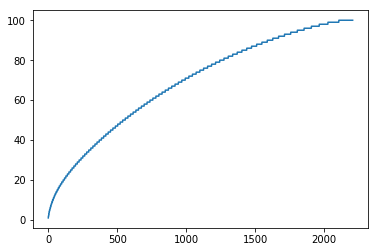

In [10]:
# Running PCA in this dataset.
pca = PCA().fit(data)

cum_variance = np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.plot(cum_variance)
plt.show()

In [11]:
# Selecting the best number of components.
n_components = np.argmax(cum_variance > 70) + 1
print("Selected n_components: {}".format(n_components))

# Transforming the data.
transformed_data = PCA(n_components).fit_transform(data)
print("New transformed data shape: {}".format(transformed_data.shape))

Selected n_components: 995
New transformed data shape: (19924, 995)


2 clusters: Cost 13759.58; Silhouette avg 0.00862; Calinski-Harabasz Index: 148.78
4 clusters: Cost 13641.94; Silhouette avg 0.00789; Calinski-Harabasz Index: 103.63
6 clusters: Cost 13543.68; Silhouette avg 0.00819; Calinski-Harabasz Index: 93.13
8 clusters: Cost 13469.54; Silhouette avg 0.00970; Calinski-Harabasz Index: 83.13
10 clusters: Cost 13372.03; Silhouette avg 0.01163; Calinski-Harabasz Index: 80.87
15 clusters: Cost 13202.97; Silhouette avg 0.01384; Calinski-Harabasz Index: 71.23
20 clusters: Cost 13093.89; Silhouette avg 0.01574; Calinski-Harabasz Index: 62.01
25 clusters: Cost 12968.36; Silhouette avg 0.01778; Calinski-Harabasz Index: 57.32
30 clusters: Cost 12823.13; Silhouette avg 0.01795; Calinski-Harabasz Index: 55.76
35 clusters: Cost 12757.10; Silhouette avg 0.01837; Calinski-Harabasz Index: 50.97
40 clusters: Cost 12663.51; Silhouette avg 0.01976; Calinski-Harabasz Index: 48.70
45 clusters: Cost 12613.07; Silhouette avg 0.01977; Calinski-Harabasz Index: 45.14
50 clu

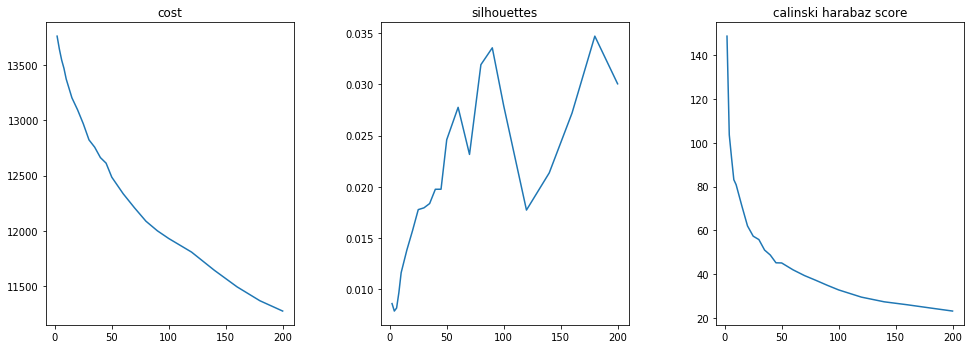

In [12]:
# Run again in transformed data
models, labels, costs, sil_avgs, ch_scores = runKmeansForMultipleCentroids(transformed_data)

In [14]:
# Chosen number of centroids
chosen_i = 16 # Meaning 90 centroids.
chosen_model = models[chosen_i]
chosen_model_labels = labels[chosen_i]
print('Chosen # of centroids: {}'.format(chosen_model.n_clusters))
print('Cost:                    %18.3f' % costs[chosen_i])
print('Silhouette avg:          %18.3f' % sil_avgs[chosen_i])
print('Calinski-Harabasz Index: %18.3f' % ch_scores[chosen_i])
analyze_centroids(chosen_model, chosen_model_labels, transformed_data)

Chosen # of centroids: 90
Cost:                             12002.650
Silhouette avg:                       0.034
Calinski-Harabasz Index:             34.868
Selected groups: [51  9 75 84 62]


<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**a800c22d4f1605149fc9904e34b1e7420e8684f1**<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!newsserver.jvnc.net!netnews.upenn.edu!netnews.cc.lehigh.edu!netnews.CC.Lehigh.EDU!news<br>From: mcg2@Lehigh.EDU (Marc Gabriel)<br>Newsgroups: sci.med<br>Subject: LymeNet Newsletter vol#1 #09<br>Message-ID: &lt;199304260235.AA110153@ns3.CC.Lehigh.EDU&gt;<br>Date: 26 Apr 93 02:44:30 GMT<br>Sender: lymenet-l@lehigh.edu<br>Lines: 344<br><br><br>                  Lyme Disease Electronic Mail Network                     <br>                          LymeNet Newsletter                               <br><br>                      Volume 1 - Number 09 - 4/26/93<br><br>I.    Introduction<br>II.   Announcements<br>III.  News from the wires<br>IV.   Questions 'n' Answers<br>V.    Op-Ed Section<br>VI.   Jargon Index<br>VII.  How to Subscribe, Contribute and Get Back Issues<br><br>I.  INTRODUCTION <br><br>In this issue of the Newsletter, we learn of the CDC's announced concern for<br>the "resurgence of infectious diseases" in the United States.  Thanks to<br>Jonathan Lord for sending me the UPI release.  The CDC announced they would<br>feature a new series of articles in the Morbidity and Mortality Weekly<br>Report on these infectious diseases (LD is one of them).  We will keep you<br>up to date on this series.<br><br>In addition, we feature a The Wall Street Journal article on the legal issues<br>surrounding LD.  We also look at Lyme's effects from the perspective of<br>urologists in an abstract entitled "Urinary Dysfunction in Lyme Disease."<br><br>Finally, Terry Morse asks an intriguing question about a tick's habitat.<br><br>-Marc.<br><br><br>II.  ANNOUNCEMENTS <br><br>SOURCE: The Lyme Disease Update<br>SUBJECT: Call for Articles<br><br>Attention Health Care Professionals:<br><br>The Lyme Disease Update would like to publish your articles on Lyme disease<br>diagnosis, Lyme treatment, and the effects on Lyme on Lyme patients' physical<br>and mental health.<br><br>The LDU has a monthly circulation of 6,000.  Our mailing list includes Lyme<br>patients, physicians, researchers, county health departments, and over 100<br>Lyme support groups nationwide.  We strive to give our readers up-to-date<br>information on Lyme disease prevention, diagnosis, and treatment, and a<br>source for support and practical advice on living with Lyme disease.<br><br>Articles for the LDU should be approximately 900 to 1200 words and should<br>address Lyme disease issues in non-scientific language.  To submit your<br>article, mail to: Lyme Disease Update<br>                  P.O. Box 15711-0711<br>                  Evansville, IN 47716<br>      or FAX to:  812-471-1990<br><br>One year subscriptions to the Lyme Disease Update are 19 (24 outside the<br>US).  Mail your subscription requests to the above address, or call<br>812-471-1990 for more information.<br><br><br>III.  NEWS FROM THE WIRES <br><br>Sender: Jonathan Lord &lt;jml4s@uva.pcmail.virginia.edu&gt;<br>Subject: RESURGENCE OF INFECTIOUS DISEASE CONCERNS CDC<br>Date: Thursday April 15, 1993<br><br>ATLANTA (UPI) --   A resurgence of infectious diseases blamed on newly<br>emerging viruses and bacteria pose a major challenge for the nation's<br>health care system, federal health officials said Thursday.<br><br>The Centers for Disease Control and Prevention, reporting its latest<br>findings in an investigation of contaminated hamburger meat that<br>sickened hundreds in 4 states and killed at least four, said it will<br>put renewed emphasis on battling infectious diseases.<br><br>Part of that emphasis includes a new series titled "Emerging<br>Infectious Diseases" to be featured in the CDC's Morbidity &amp; Mortality<br>Weekly Report, which has a wide circulation in the health community.<br>The issue also will top the agenda of a two-day meeting of scientific<br>counselors to update the CDC's draft plan for dealing with the growing<br>threat of infectious ailments.<br><br>"This is an issue that has been coming and we do have a responsibility<br>to deal with it," said Dr. Ruth Berkelman, deputy director of the CDC's<br>National Center for Infectious Diseases.<br><br>There were more cases of malaria in the U.S. in 1992 than in any year<br>since the 1960s, and Latin America is experiencing a cholera epidemic,<br>the first in this century, she said.<br><br>Resistance of disease-causing agents to antibiotics is also a problem.<br>"We are seeing much more antibiotic resistance than we have in the past"<br>Berkleman said.  She said even common ear infections frequently seen in<br>children are becoming resistant to antibiotic treatment.<br><br>"Despite predictions earlier this century that infectious  diseases<br>would soon be eliminated as a public health problem, infectious diseases<br>remain the major cause of death worldwide and a leading cause of illness<br>and death in the United States," the CDC said.<br><br>It  cited  the  emergence since the 1970s of a "myriad" of newly<br>identified pathogens and syndromes, such as Escherichia coli O157:H7, a<br>deadly bacterial infection; the hepatitis C virus; HIV, the virus that<br>causes AIDS; Legionnaires disease; Lyme disease; and toxic shock syndrome.<br><br>"The incidences of many diseases widely presumed to be under control,<br>such as cholera, malaria and tuberculosis, have increased in many areas,"<br>the CDC said.  It said efforts at control and prevention have been<br>undermined by drug resistance.<br><br>==========<br><br>SOURCE:  WALL STREET JOURNAL<br>REFERENCE: 04/15/93, pB1<br>HEADLINE: Lyme-Disease Ruling Raises Liability Issues<br><br>The tick that causes Lyme disease may have found a new way to cause<br>damage: legal liability.<br><br>A federal judge's decision holding a property owner liable for not<br>doing enough to protect workers from Lyme disease is getting as much<br>attention as the latest medical study on the disease, a flu-like<br>illness that can cause severe physical and mental disabilities and in<br>rare instances death. The decision last week has put property owners<br>on notice that they may have to do more than protect themselves from<br>the ticks-they also may have to protect themselves from litigation if<br>someone becomes infected while on the property.<br><br>The decision by U.S. District Judge Robert J. Ward in New York came<br>after a week-long trial in a case involving four track workers for the<br>Long Island Railroad. Judge Ward found that the workers contracted the<br>disease after they were bitten by ticks while on the job. He ordered<br>the New York state-owned commuter line to pay the workers more than<br>560,000 to compensate for pain and suffering, in addition to medical<br>expenses and lost wages.<br><br>Summer camps, schools, companies with facilities in rural or<br>semirural areas, and homeowners who rent to vacationers are among the<br>groups that need to be worried about this ruling, says Stephen L.<br>Kass, an attorney at New York law firm Berle, Kass &amp; Case, who wrote a<br>legal article three years ago warning property owners of the potential<br>liability. Even a family that invites friends over for a backyard<br>barbecue might be potentially liable.<br><br>Lawsuits for insect bites, while rare, aren't unheard-of. A summer<br>vacationer in Southampton, N.Y., last year sued the owner of the home<br>she rented, claiming that a tick on the property gave her Rocky<br>Mountain spotted fever. In 1988, also on Long Island, a jury ordered<br>an outdoor restaurant to pay more than 3 million to a patron who was<br>stung by a bee, causing an allergic reaction and permanent<br>quadriplegia. The judge later threw out the award, citing no evidence<br>that a beehive was near the restaurant.<br><br>But lawyers say that the attention to Lyme disease throughout the<br>country -- it's most prevalent in New England, the Middle Atlantic<br>states, Wisconsin, Minnesota and the Northwest -- may make this<br>particular insect bite a particularly litigious one.<br><br>The illness already has proved to be a source of controversy in the<br>courtroom over such issues as the type of medical care insurers will<br>cover and medical malpractice claims against doctors for not<br>diagnosing the disease.<br><br>Lawyers say worker's-compensation claims related to Lyme disease<br>have become common in some states in recent years. Payments in<br>worker's-compensation cases, however, are limited to medical costs and<br>lost earnings.<br><br>The case before Judge Ward dealt with a potentially much more<br>lucrative avenue for damages, because it involved the question of<br>negligence. Unlike the worker's compensation process, the law governing<br>injuries to rail workers allows for a finding of negligence and, as a<br>result, for additional payments for pain and suffering. Property<br>owners and lawyers say that negligence claims can be made in many<br>other situations where people are exposed to the ticks that carry the<br>disease.<br><br>Ira M. Maurer, a partner at New York law firm Elkind, Flynn &amp;<br>Maurer, who represented the rail workers, says the decision will help<br>to establish "the duty of all sorts of property owners to protect<br>against Lyme disease."<br><br>Lawyers caution that despite Judge Ward's decision, winning a<br>lawsuit for damages caused by Lyme disease may prove difficult. For<br>one thing, victims have to demonstrate that they have pinned down when<br>and where they got the tick bite. Judge Ward found that the plaintiffs<br>in the railroad case got Lyme disease while working on property owned<br>by the railroad, even though none of the men remembered being bitten.<br>The workers, who weren't outdoorsmen likely to be exposed elsewhere to<br>the insects, said they saw ticks in the high grass that surrounded<br>some work sites.<br><br>A spokeswoman for the railroad says that there was no proof that<br>the four men were bitten while on the job and that the railroad is<br>considering an appeal. The railroad also disputes Judge Ward's finding<br>that it didn't do enough to protect employees. The spokeswoman says<br>the railroad provides track workers with insect repellent and special<br>pants to protect against bug bites.<br><br>Debate in the scientific community over Lyme disease could open up<br>some legal defenses for property owners, such as questioning whether a<br>victim actually has the disease rather than some other illness.<br>Earlier this week, the Journal of the American Medical Association<br>reported that doctors overly diagnose patients as having Lyme disease.<br>And damages awarded to a victim also might be influenced by medical<br>disputes over the degree of harm that Lyme disease causes.<br><br>Because of health and safety concerns, some groups and companies<br>already take special measures to protect against Lyme disease. Last<br>year, at its headquarters in Franklin Lakes, N.J., Becton, Dickinson &amp;<br>Co. began using Damminix, a pesticide made by EcoHealth Inc. of Boston<br>that is designed to kill ticks carrying the disease. The medical-<br>supply company's headquarters include a 120-acre park, and the company<br>was worried that employees who walk on its trails for recreation might<br>get infected.<br><br>Ruth Lister, a spokeswoman for the American Camping Association in<br>Indianapolis, says that many youth camps accredited by her<br>organization also have begun to check children for ticks. And Carole<br>Katz, a member of the board of the Fire Island Pines Property Owners<br>Association, says her group spends 30,000 each year to treat their<br>100-acre site off the coast of New York with the tick-killing<br>pesticide.<br><br>==========<br><br>TITLE: Urinary dysfunction in Lyme disease.<br>AUTHORS: Chancellor MB; McGinnis DE; Shenot PJ; Kiilholma P; Hirsch IH,<br>Department of Urology, Jefferson Medical College, Thomas Jefferson<br>University, Philadelphia, Pennsylvania.<br>REFERENCE: J Urol 1993 Jan; 149 (1): 26-30<br><br>Lyme disease, which is caused by the spirochete Borrelia burgdorferi, is<br>associated with a variety of neurological sequelae.  We describe 7 patients<br>with neuro-borreliosis who also had lower urinary tract dysfunction.<br>Urodynamic evaluation revealed detrusor hyperreflexia in 5 patients and<br>detrusor areflexia in 2.  Detrusor external sphincter dyssynergia was not<br>noted on electromyography in any patient.  We observed that the urinary tract<br>may be involved in 2 respects in the course of Lyme  disease: 1) voiding<br>dysfunction may be part of neuro-borreliosis and 2) the spirochete may<br>directly invade the urinary tract.  In 1 patient bladder infection by the<br>Lyme spirochete was documented on biopsy.  Neurological and urological<br>symptoms in all patients were slow to resolve and convalescence was<br>protracted.  Relapses of active Lyme disease and residual neurological<br>deficits were common.  Urologists practicing in areas endemic for Lyme<br>disease need to be aware of B. burgdorferi infection in the differential<br>diagnosis of neurogenic bladder dysfunction.  Conservative bladder<br>management including clean intermittent catheterization guided by urodynamic<br>evaluation is recommended.<br><br><br>IV.  QUESTIONS 'N' ANSWERS <br><br>Note: If you have a response to this question, please forward it to the<br>editor.<br><br>Sender: Terry Morse &lt;morset@ccmail.orst.edu&gt;<br>Subject: Question on Lyme Vectors and Compost Piles<br><br>  When I visited my sister on Long Island, NY, I was cautioned to avoid the<br>compost heap in her back yard, as she thinks this is where she became<br>infected.<br><br>  A friend of mine here in Oregon who has a compost heap would like me to<br>back that claim up with documentation.  Do lyme-carrying ticks hang out in<br>compost heaps?<br>Thank you.<br><br><br>V.  OP-ED SECTION <br><br>This section is open to all subscribers who would like to express an opinion.<br><br><br>VI.  JARGON INDEX <br><br>Bb - Borrelia burgdorferi - The scientific name for the LD bacterium.<br>CDC - Centers for Disease Control - Federal agency in charge of tracking<br>      diseases and programs to prevent them.<br>CNS - Central Nervous System.<br>ELISA - Enzyme-linked Immunosorbent Assays - Common antibody test<br>EM - Erythema Migrans - The name of the "bull's eye" rash that appears in<br>     ~60% of the patients early in the infection.<br>IFA - Indirect Fluorescent Antibody - Common antibody test.<br>LD - Common abbreviation for Lyme Disease.<br>NIH - National Institutes of Health - Federal agency that conducts medical<br>      research and issues grants to research interests.<br>PCR - Polymerase Chain Reaction - A new test that detects the DNA sequence<br>      of the microbe in question.  Currently being tested for use in<br>      detecting LD, TB, and AIDS.<br>Spirochete - The LD bacterium.  It's given this name due to it's spiral<br>      shape.<br>Western Blot - A more precise antibody test.<br><br><br>VII.  HOW TO SUBSCRIBE, CONTRIBUTE AND GET BACK ISSUES <br><br>SUBSCRIPTIONS:<br>Anyone with an Internet address may subscribe.<br>Send a memo to    listserv@Lehigh.EDU<br>in the body, type:<br>subscribe LymeNet-L &lt;Your Real Name&gt;<br><br>FAX subscriptions are also available.  Send a single page FAX to 215-974-6410<br>for further information.<br><br>DELETIONS:<br>Send a memo to    listserv@Lehigh.EDU<br>in the body, type:<br>unsubscribe LymeNet-L<br><br>CONTRIBUTIONS:<br>Send all contributions to   LymeNet-L@Lehigh.EDU  or FAX them to 215-974-6410.<br>All are encouraged to submit questions, news items, announcements, and<br>commentaries.<br><br>BACK ISSUES:<br>Send a memo to    listserv@Lehigh.EDU<br>in the body, type:<br>get LymeNet-L/Newsletters x-yy              (where x=vol # and yy=issue #)<br><br>example:  get LymeNet-L/Newsletters 1-01    (will get vol#1, issue#01)<br><br>-----------------------------------------------------------------------------<br>LymeNet - The Internet Lyme Disease Information Source<br>-----------------------------------------------------------------------------<br>Editor-in-Chief: Marc C. Gabriel &lt;mcg2@Lehigh.EDU&gt;<br>            FAX: 215-974-6410<br>Contributing Editors: Carl Brenner &lt;brenner@lamont.ldgo.Columbia.EDU&gt;<br>                      John Setel O'Donnell &lt;jod@Equator.COM&gt;<br>Advisors: Carol-Jane Stolow, Director<br>          William S. Stolow, President<br>          The Lyme Disease Network of New Jersey (908-390-5027)<br>Chief Proofreader: Ed Mackey &lt;elm4@Lehigh.EDU&gt;<br>-----------------------------------------------------------------------------<br>WHEN COMMENTS ARE PRESENTED WITH AN ATTRIBUTION, THEY DO NOT NECESSARILY<br>REPRESENT THE OPINIONS/ANALYSES OF THE EDITOR.<br>-----------------------------------------------------------------------------<br>THIS NEWSLETTER MAY BE REPRODUCED AND/OR POSTED ON BULLETIN BOARDS FREELY<br>AS LONG AS IT IS NOT MODIFIED OR ABRIDGED IN ANY WAY.<br>-----------------------------------------------------------------------------<br>SEND ALL BUG REPORTS TO mcg2@Lehigh.EDU.<br>-----------------------------------------------------------------------------<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**3e465dd83c8126900fe277aba352c4b54e441d1f**<br>Newsgroups: sci.med<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!noc.near.net!uunet!walter!porthos!prefect!jer<br>From: jer@prefect.cc.bellcore.com (rathmann,janice e)<br>Subject: Re: Sinus vs. Migraine (was Re: Sinus Endoscopy)<br>Organization: Bellcore, Livingston, NJ<br>Date: Tue, 6 Apr 93 16:45:40 GMT<br>Message-ID: &lt;1993Apr6.164540.2219@porthos.cc.bellcore.com&gt;<br>Summary: Headaches and analgesics<br>References: &lt;1n5jjfINNcr2@emx.cc.utexas.edu&gt; &lt;Lauger-240393141539@lauger.mdc.com&gt;<br>Sender: netnews@porthos.cc.bellcore.com (USENET System Software)<br>Lines: 95<br><br><br>I noticed several years ago that when I took analgesics fairly regularly,<br>(motrin at the time), I seemed to get a lot of migraines.  But had<br>forgotten about that until I started reading some of the posts here.<br>I generally don't take NSAIDS or Tylenol for headaches, because I've<br>found them to be ineffective.  However, I have two other pain sources<br>that force me to take NSAIDS (currently Naprosyn).  First, is some<br>pelvic pain that I get at the beginning of my period, and then much<br>worse at midcycle.  I have had surgery for endometriosis in the past<br>(~12 years ago), so the Drs. tell me that my pain is probably due<br>to the endometriosis coming back.  I've tried Synarel, it reduced<br>the pain while I took it (3 mos), but the pain returned immediately<br>after I stopped.  Three doctors have suggested hysterectomy as the<br>only "real solution" to my problem.  Although I don't expect to have<br>any more children, I don't like the idea of having my uterus and<br>one remaining ovary removed (the first ovary was removed when I had<br>the surgery for endometriosis).  One of the Drs that suggested<br>I get a hysterectomy is an expert in laser surgery, but perhaps thinks<br>that type of procedure is only worthwhile on women who still plan<br>to have children.  So basically all I'm left with is toughing out<br>the pain.  This would be impossible without Naprosyn (or something<br>similar - but not aspirin, that doesn't work, and Motrin gave me<br>horrible gastritis a few years ago, so I'm through with it).  In<br>fact, Naprosyn works very well at eliminating the pain if I take<br>it regularly as I did when I had severe back pain (and pain in both <br>legs) as I'll discuss in a moment.  Generally though, I wait until<br>I have the pain before I take the Naprosyn, but then it takes<br>several hours for it reduce the pain (it's actually quite effective<br>at reducing the pain, it just takes quite a while).  In the meantime<br>I'm frequently in severe pain.<br><br>The other pain source I have is chronic lower back pain resulting in<br>bilateral radiculopathy.  I've had MRIs, Xrays, CT scan, and EMGs<br>(I've had 2 of them, and don't intend to ever do that again) with<br>nerve conduction tests.  The tests have not been conclusive as to<br>what is causing my back and leg pain.  The MRI reports both say I have<br>several bulging, degeneratig disks, and from the Xrays (and MRI, I think)<br>it is apparent that I have arthritis.  The reading on the CT scan<br>was that there are two herniations (L3-L4, and L4-L5), but others<br>hav looked at the films and concluded that there are no herniations.<br>The second EMG and nerve conduction studies shows significant denervation<br>compared to the first EMG.  Oh yeah, I had some other horrible test,<br>called something like Somatic Evoked Response which showed that the<br>"internal nerves" are working fine.   Anyway, the bottom line is that<br>I sometimes have severe pain in both legs and back pain.  The back pain<br>is there all the time, but I can live with it.  When the leg pain is there,<br>I need some analgesic/anti-inflammatory medication to reduce the pain<br>to a level where I can work.  So I took Naprosyn regulary for 6-9<br>months (every time I tried to stop the leg pain got worse, so I'd <br>always resume).  Since last November I have taken it much less frequently,<br>and primarily for the pelvic pain.  I have been going to physical<br>therapy for the last 8 months (2-3 times a week).  After the first month<br>or so, my therapist put me on pelvic traction (she had tried it earlier,<br>but it had caused a lot of pain in my back, this time she tried it at<br>a lower weight).  After a month or two, the pain in my legs began going<br>away (but the traction aways caused discomfort in my lower back, which<br>could be reduced with ultrasound and massage).  So now, I don't have<br>nearly as much pain in my legs, in fact my therapist took me off<br>traction about 2 weeks ago.<br><br>Getting back to my original reason for this post...  Even if I can avoid<br>taking analgesic for headaches, I really can't avoid them entirely because<br>I have other pain sources, that "force" me to use them (Oh, I forgot<br>to mention that it has been suggested to me that I have back surgery,<br>but I'm avoiding that too).  I find the migraines difficult to deal with,<br>occassionally I have to take off work, but usually I can work, but at<br>a reduced capacity (I'm a systems engineer and do a lot of reading<br>and writing).  When the pelvic pain is bad, I can't concentrate much,<br>I usually end up jumping out of my chair every few minutes, because<br>the pain is so bothersome.  When the pain in my back is bad, it can<br>cause severe burning in both legs, shooting pains in my legs, electric<br>shock type of pain in my feet and toes, and basically when it gets bad<br>I can't really sit at all.  Then I end up spending most of my time home<br>and in bed.  So even if the analgesics contribute to the migraines, the<br>migraines are more tolerable than the other pain sources.  I get a lot<br>of migraines, an average of 3 to 4 a month, which last 1-3 days.<br>I've taken cafergot (the first time the caffiene really got to me so<br>I reduced the dosage), but I don't like the side effects (if I take<br>more than two I get diahrea).  If I get a very bad headache, I will<br>eventually take the cafergot.  My neurologist wasn't very helpful when<br>I told him my problems with cafergot, he said that when sumatriptan<br>becomes available, I should try that.  I've tried several other medications<br>(fiornal, midrin, fiornal with codeine, tegretol, and inderal) but<br>they either didn't work, or I couldn't tolerate them.  So what can I do?<br>My doctor's seem to be satisfied with me just trying to tolerate the<br>pain, which I agree with most of the time, but not when I have a lot of<br>pain.  I've had some bad experiences with surgery (my heart stopped<br>once from the anesthesia - I was told that it was likely the<br>succinylcholine), and I've already had surgery several times.<br><br>Anyway, the point of what I'm saying is that even if analgesics can contribute<br>to migraines, some people NEED to take them to tolerate other pain.<br><br>Janice Rathmann<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**51f66e88c690adc887c2fa06ff610c2e07f63f29**<br>Newsgroups: sci.med<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!darwin.sura.net!sgiblab!sdd.hp.com!decwrl!decwrl!uunet!utcsri!utnut!utzoo!telly!problem!intacc!bed<br>From: bed@intacc.uucp (Deb Waddington)<br>Subject: INFO NEEDED: Gaucher's Disease<br>Message-ID: &lt;1993Mar18.002149.1111@intacc.uucp&gt;<br>Date: Thu, 18 Mar 1993 00:21:49 GMT<br>Distribution: Everywhere<br>Expires: 01 Jun 93<br>Reply-To: bed@intacc.UUCP (Deb Waddington)<br>Organization: Matrix Artists' Network<br>Lines: 33<br><br><br>I have a 42 yr old male friend, misdiagnosed as having<br> osteopporosis for two years, who recently found out that his<br> illness is the rare Gaucher's disease. <br><br>Gaucher's disease symptoms include: brittle bones (he lost 9 <br> inches off his hieght); enlarged liver and spleen; internal<br> bleeding; and fatigue (all the time). The problem (in Type 1) is<br> attributed to a genetic mutation where there is a lack of the<br> enzyme glucocerebroside in macrophages so the cells swell up.<br> This will eventually cause death.<br><br>Enyzme replacement therapy has been successfully developed and<br> approved by the FDA in the last few years so that those patients<br> administered with this drug (called Ceredase) report a remarkable<br> improvement in their condition. Ceredase, which is manufactured<br> by biotech biggy company--Genzyme--costs the patient 380,000<br> per year. Gaucher's disease has justifyably been called "the most<br> expensive disease in the world".<br><br>NEED INFO:<br>I have researched Gaucher's disease at the library but am relying<br> on netlanders to provide me with any additional information:<br>news, stories, reports<br>people you know with this disease<br>ideas, articles about Genzyme Corp, how to get a hold of<br>   enough money to buy some, programs available to help with<br>   costs.<br>Basically ANY HELP YOU CAN OFFER<br><br>Thanks so very much!<br><br>Deborah <br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**2dceedffab41a1053ac79848903f9b3801f52d5e**<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!uwm.edu!zaphod.mps.ohio-state.edu!moe.ksu.ksu.edu!uafhp!yb025<br>From: yb025@uafhp..uark.edu (John Schiefer)<br>Newsgroups: misc.forsale<br>Subject: engagement ring give up<br>Summary: Beautiful 14k gold band with a .33 carat diamond.  very clean.<br>Keywords: holmes<br>Message-ID: &lt;1psvhjgp5@moe.ksu.ksu.edu&gt;<br>Date: 6 Apr 93 22:17:23 GMT<br>Article-I.D.: moe.1psvhjgp5<br>Organization: Kansas State University<br>Lines: 3<br>NNTP-Posting-Host: uafhp.uark.edu<br><br>Diamond engagement ring.  14k gold band.  33point  diamond.  appraised at<br>1900 dollars.  Will sell for 600 dollars. Appraisal available upon request.<br>send e-mail to yb025@uafhp.uark.edu<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**79219832126b1d55fed56312a24ea44be8fa7e82**<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!usc!sdd.hp.com!network.ucsd.edu!news.cerf.net!pagesat!olivea!bunker!sheldev.shel.isc-br.com!jerry<br>From: jerry@sheldev.shel.isc-br.com (Gerald Lanza)<br>Newsgroups: rec.sport.baseball<br>Subject: Re: Seeking Moe Berg reference/info<br>Message-ID: &lt;C5JB37.BCy@bunker.shel.isc-br.com&gt;<br>Date: 15 Apr 93 16:57:06 GMT<br>References: &lt;1pph6mmlb@usenet.INS.CWRU.Edu&gt; &lt;1993Apr5.155315.14381@adobe.com&gt; &lt;8813@blue.cis.pitt.edu&gt;<br>Sender: news@bunker.shel.isc-br.com<br>Organization: Olivetti North America (Shelton, CT)<br>Lines: 23<br><br>In article &lt;8813@blue.cis.pitt.edu&gt; dtate+@pitt.edu (David M. Tate) writes:<br>&gt;I seem to have misplaced the baseball bibliography that was posted here<br>&gt;recently.  (That's what happens when you have to split a heap of disorganized<br>&gt;files from one machine among two others.)  Could some kind soul repost the<br>&gt;bibliography, or mail me a copy?<br>&gt;<br>&gt;Also, in particular, a colleague of mine is looking for any information he<br>&gt;can find on Moe Berg, catcher/linguist/espion of WW2.  Any references (or<br>&gt;anecdotes, for that matter) would be appreciated.<br>&gt;<br>&gt;Dave<br>&gt;<br>	I believe SI had an in-depth article on Moe a while ago. I remember<br>	that the article revealed some new facts regarding the secretive<br>	Moe. My SI subscription expired this past February, the second of<br>	two years that I received same. Therefore my guess is that the<br>	article appeared sometime in 1991-92. <br><br>	Can anyone else be more definitive as to a date of the SI article ?<br><br><br>						jerry<br> <br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**9c70a49d6b37cb43b4e4e6acb49e1f967d4cfffb**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.graphics.visualization:3395 comp.graphics:38818<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!wupost!zaphod.mps.ohio-state.edu!moe.ksu.ksu.edu!phys.ksu.edu!raj<br>From: raj@phys.ksu.edu (S. Raj Chaudhury)<br>Newsgroups: comp.graphics.visualization,comp.graphics<br>Subject: Re: Needed: Plotting package that does...<br>Date: 27 Apr 1993 15:02:17 GMT<br>Organization: Kansas State University<br>Lines: 28<br>Message-ID: &lt;1rjhtpmlt@moe.ksu.ksu.edu&gt;<br>References: &lt;FULL_GL.93Apr18005752@dolphin.pts.mot.com&gt; &lt;C5qGF5.K2I@alta-oh.com&gt;<br>NNTP-Posting-Host: piaget.phys.ksu.edu<br><br>In &lt;C5qGF5.K2I@alta-oh.com&gt; chris@zeus.alta-oh.com (Chris Murphy) writes:<br><br>&gt;In article &lt;FULL_GL.93Apr18005752@dolphin.pts.mot.com&gt;, full_gl@pts.mot.com (Glen Fullmer) writes:<br>&gt;|&gt; Looking for a graphics/CAD/or-whatever package on a X-Unix box that will<br>&gt;|&gt; take a file with records like:<br><br>&gt;Hi,<br>&gt;  See Roger Grywalski's response to :<br><br>&gt;Re: Help on network visualization<br><br>&gt;in comp.graphics.visualization.<br><br>Could someone please post Roger Grywalski's response?  Or point me to where<br>I could find it?<br><br>Thanks a lot,<br><br><br>S. Raj Chaudhury			|<br>Dept. of Physics    			|  raj@phys.ksu.edu<br>Kansas State University			|<br>Manhattan, KS 66506			|<br>--<br>S. Raj Chaudhury			|<br>Dept. of Physics    			|  raj@phys.ksu.edu<br>Kansas State University			|<br>Manhattan, KS 66506			|<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c582744fdc2ccbc7ff7f33d782753c603ae07bfe**<br>Newsgroups: sci.space<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!usc!cs.utexas.edu!utnut!utzoo!henry<br>From: henry@zoo.toronto.edu (Henry Spencer)<br>Subject: Re: Vandenberg launches?<br>Message-ID: &lt;C73A6p.LL@zoo.toronto.edu&gt;<br>Date: Sat, 15 May 1993 22:23:12 GMT<br>References: &lt;1993May15.210927.23846@mri.com&gt;<br>Organization: U of Toronto Zoology<br>Lines: 10<br><br>In article &lt;1993May15.210927.23846@mri.com&gt; paulc@mri.com (Paul Carroll) writes:<br>&gt;I know about the phone numbers, etc. to get Kennedy/Canaveral<br>&gt;launch information, but is there any equivalent way of finding out<br>&gt;about launches at Vandenberg?<br><br>Bear in mind that a lot of the Vandenberg launch traffic is military and<br>at least semi-secret.  They aren't interested in publicizing it beforehand.<br>-- <br>SVR4 resembles a high-speed collision   | Henry Spencer @ U of Toronto Zoology<br>between SVR3 and SunOS.    - Dick Dunn  |  henry@zoo.toronto.edu  utzoo!henry<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**ffe627bff09b093b4e18c2d1a3ca8e1ea9407b00**<br>Newsgroups: sci.space<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!zaphod.mps.ohio-state.edu!cs.utexas.edu!utnut!utzoo!henry<br>From: henry@zoo.toronto.edu (Henry Spencer)<br>Subject: Re: Surviving Large Accelerations?<br>Message-ID: &lt;C5w5zH.BsA@zoo.toronto.edu&gt;<br>Date: Thu, 22 Apr 1993 15:35:39 GMT<br>References: &lt;EfpX7WS00Uh7QAoP1S@andrew.cmu.edu&gt;<br>Organization: U of Toronto Zoology<br>Lines: 13<br><br>In article &lt;EfpX7WS00Uh7QAoP1S@andrew.cmu.edu&gt; Amruth Laxman &lt;al26+@andrew.cmu.edu&gt; writes:<br>&gt;... here's my question finally - Are 45g accelerations in<br>&gt;fact humanly tolerable? - with the aid of any mechanical devices of<br>&gt;course. If these are possible, what is used to absorb the acceleration?<br><br>This sounds a bit high to me.  Still higher accelerations have been endured<br>very briefly, during violent deceleration.  If we're talking sustained<br>acceleration, I think 30-odd gees has been demonstrated using water immersion.<br><br>I doubt that any of this generalizes to another order of magnitude.<br>-- <br>All work is one man's work.             | Henry Spencer @ U of Toronto Zoology<br>                    - Kipling           |  henry@zoo.toronto.edu  utzoo!henry<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**62ac5ad0cdf49ad4ca1260da0a3a63a74e9f05b8**<br>Newsgroups: sci.space<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!darwin.sura.net!howland.reston.ans.net!usc!cs.utexas.edu!utnut!utzoo!henry<br>From: henry@zoo.toronto.edu (Henry Spencer)<br>Subject: Re: Space Station Redesign, JSC Alternative #4<br>Message-ID: &lt;C60GoK.Iz@zoo.toronto.edu&gt;<br>Date: Sat, 24 Apr 1993 23:17:07 GMT<br>References: &lt;1993Apr23.184732.1105@aio.jsc.nasa.gov&gt; &lt;23APR199317452695@tm0006.lerc.nasa.gov&gt;<br>Organization: U of Toronto Zoology<br>Lines: 10<br><br>In article &lt;23APR199317452695@tm0006.lerc.nasa.gov&gt; dbm0000@tm0006.lerc.nasa.gov (David B. Mckissock) writes:<br>&gt;  -  Man-Tended Capability (Griffin has not yet adopted non-sexist<br>&gt;     language) ...<br><br>Glad to see Griffin is spending his time on engineering rather than on<br>ritual purification of the language.  Pity he got stuck with the turkey<br>rather than one of the sensible options.<br>-- <br>SVR4 resembles a high-speed collision   | Henry Spencer @ U of Toronto Zoology<br>between SVR3 and SunOS.    - Dick Dunn  |  henry@zoo.toronto.edu  utzoo!henry<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**8fe69b5370a161f8a0c3b9db7e1bea33cdf8e195**<br>Newsgroups: rec.sport.hockey<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!mcsun!sunic!sics.se!eua.ericsson.se!ericom!etxonss<br>From: etxonss@ufsa.ericsson.se (Staffan Axelsson)<br>Subject: Sweden-Finland, April 15<br>Message-ID: &lt;1993Apr16.093531.3491@ericsson.se&gt;<br>Sender: news@ericsson.se<br>Nntp-Posting-Host: uipc104.ericsson.se<br>Organization: Ericsson Telecom, Stockholm, Sweden<br>Date: Fri, 16 Apr 1993 09:35:31 GMT<br>Lines: 119<br><br><br> Played in Scandinavium, Gothenburg, April 15 1993:<br> ==================================================<br><br> SWEDEN - FINLAND  6-6 (1-2,3-1,2-3)<br><br> 1st: SWE 1-0 Peter Popovic      (Markus Naslund)                     6:10<br>      FIN 1-1 Ville Siren        (Keijo Sailynoja)                    8:44 (pp)<br>      FIN 1-2 Juha Riihijarvi    (Timo Saarikoski,Vesa Viitakoski)   13:12 (pp)<br> 2nd: FIN 1-3 Jari Korpisalo     (Kari Harila,Rauli Raitanen)         6:48<br>      SWE 2-3 Jan Larsson        (Mikael Renberg,Stefan Nilsson)      7:25<br>      SWE 3-3 Hakan Ahlund       (Thomas Rundqvist)                   8:56<br>      SWE 4-3 Roger Akerstrom    (Roger Hansson)                      9:13<br> 3rd: SWE 5-3 Stefan Nilsson     (Patrik Juhlin,Charles Berglund)     2:20<br>      FIN 5-4 Keijo Sailynoja                                         9:23<br>      FIN 5-5 Keijo Sailynoja                                         9:44 (ps)<br>      SWE 6-5 Mikael Renberg     (Hakan Ahlund,Thomas Rundqvist)     17:16<br>      FIN 6-6 Jari Korpisalo                                         17:44<br><br>             Shots on goal:      Penalties:     Attendance:    Referee:<br> Sweden       8 10 10 - 28       52min         6,799          Peter Andersson<br> Finland     12 10 11 - 33       62min,110min                (Sweden)<br><br>-------------------------------------------------------------------------------<br><br> Sweden opened the scoring as Markus Naslund made a drop pass at the Finnish<br> blue line, Popovic picked it up and advanced towards the Finnish goal and<br> shot a nice hard wrist shot in Ketterer's top corner. Ville Siren's slap<br> shot from the blue line on power play made it 1-1, and Juha Riihijarvi<br> scored a nice goal in another power play when he close in front of goal<br> put the puck high over Aslin, 1-2 after the first period.<br> The Finns started the second period with really good pressure. Korpisalo<br> made it 1-3 with another goal from close range high over Aslin. Then,<br> during the Finnish pressure, Sweden turned the game around in 1:47.<br> Mikael Renberg worked hard behind the Finnish goal, and passed the puck to<br> Jan Larsson in front, who backhanded the puck low, 2-3. Rundqvist entered<br> the Finnish zone and passed to Ahlund, and the Finnish defense let Ahlund <br> skate in and take a shot that Ketterer dropped into the goal, 3-3.<br> Next, Roger Hansson -behind the goal- sent the puck back to the blue line<br> where Roger Akerstrom took a slap shot and Ketterer didn't see the puck since<br> there was traffic in front, 4-3.<br> Third period started with a nice goal by Stefan "the Shadow" Nilsson. Stefan<br> and Patrik Juhlin entered the Finnish zone, Patrik passed the puck back to<br> Stefan who alone with Ketterer made no mistake, 5-3.<br> Then, Keijo Sailynoja show started. He reduce and equalized the lead in only<br> 21 seconds! First he scored the 5-4 goal, and after that he came in alone <br> with Aslin but was tripped by Aslin to get a penalty shot. Sailynoja<br> made a nice penalty shot, showed forehand and put in with a low backhand shot.<br> The Swedes seemed to head for a win when Mikael Renberg scored the 6-5 goal<br> late in the game on a nice power play combination. Renberg waited in the slot,<br> showed that he wanted the puck on the backhand side, Ahlund passed the puck<br> and Renberg took a turnaround shot low in Ketterer's goal's far side.<br> But Jari Korpisalo had other plans as he only 28 seconds later scored the<br> game's final goal to make it 6-6. Korpisalo took a slap shot from a narrow<br> angle that -maybe- Aslin should have saved.<br><br> All in all, a decent game where the defense wasn't the best.<br> Both teams juggled around the lines a bit in the second and third period<br> to try no combinations.<br><br> Renberg and Rundqvist plays well together in the Swedish team. Larsson-<br> Nilsson-Juhlin best line overall again, it seems to be a working WC line.<br> Stillman good on defense.<br> Some players aren't good enough for the WC though. Hakan Ahlund (faell ner<br> hjaelmen och jobba!), Roger Hansson, Challe Berglund, Kenny Jonsson<br> will likely have to leave for NHL pros.<br><br> Two-goal scorers Jari Korpisalo and Keijo Sailynoja played well in the<br> Finnish team. Markus Ketterer didn't have a very good game, we've seen him<br> a lot better, so Lindfors is probably Finland's starting goalie in the WC.<br> I heard that Esa Tikkanen will join the Finnish team. It would be inter-<br> resting to know which other pros coach Matikainen counts on for the WC.<br> <br>-------------------------------------------------------------------------------<br><br> Starting lines:<br><br> 	SWEDEN					FINLAND<br><br>  35. Peter Aslin			30. Markus Ketterer<br><br>   8. Kenneth Kennholt			 2. Mikko Haapakoski<br>  14. Fredrik Stillman			 3. Ville Siren<br><br>  10. Hakan Ahlund			28. Jarkko Varvio<br>   9. Thomas Rundqvist			40. Mika Nieminen<br>  29. Mikael Renberg  			18. Keijo Sailynoja<br><br>  27. Roger Akerstrom			 4. Erik Hamalainen<br>   7. Arto Blomsten			 8. Kari Harila<br><br>  20. Jan Larsson 	 		25. Rauli Raitanen<br>   4. Stefan Nilsson 			26. Petri Varis<br>   5. Patrik Juhlin			14. Jari Korpisalo<br><br>   3. Peter Popovic			 5. Timo Jutila<br>  32. Stefan Larsson			44. Harri Laurila<br><br>  11. Roger Hansson			24. Juha Riihijarvi<br>  33. Fredrik Nilsson			22. Timo Saarikoski<br>  24. Peter Ottosson			11. Vesa Viitakoski<br><br>					 6. Pasi Sormunen<br>					12. Janne Laukkanen<br><br>  19. Markus Naslund			29. Juha Ylonen<br>  21. Peter Forsberg			27. Timo Peltomaa<br>  18. Jonas Bergqvist			17. Marko Palo<br><br> Played parts of the game:<br>  22. Charles Berglund			15. Mika Alatalo<br>   6. Kenny Jonsson			16. Saku Koivu<br>					20. Marko Palo<br><br>-------------------------------------------------------------------------------<br>--<br> ((\\  //| Staffan Axelsson            <br>  \\  //|| etxonss@ufsa.ericsson.se    <br>\\_))//-|| r.s.h. contact for Swedish hockey  <br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**09f557f0f5adaab95adc865399dfdc3a8dd97482**<br>Newsgroups: rec.sport.hockey<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!zaphod.mps.ohio-state.edu!cs.utexas.edu!utnut!torn!newshub.ccs.yorku.ca!ists!stpl.ists.ca!dchhabra<br>From: dchhabra@stpl.ists.ca (Deepak Chhabra)<br>Subject: Re: Nords 3 - Habs 2 in O.T. We was robbed!!<br>Message-ID: &lt;1993Apr21.150227.1915@newshub.ists.ca&gt;<br>Sender: news@newshub.ists.ca (News Subsystem)<br>Nntp-Posting-Host: stpl.ists.ca<br>Organization: Solar Terresterial Physics Laboratory, ISTS<br>References: &lt;18APR93.25909598.0086@VM1.MCGILL.CA&gt; &lt;1993Apr19.141842.18456@newshub.ists.ca&gt; &lt;1993Apr20.163027.28425@jarvis.csri.toronto.edu&gt;<br>Date: Wed, 21 Apr 1993 15:02:27 GMT<br>Lines: 90<br><br>In article &lt;1993Apr20.163027.28425@jarvis.csri.toronto.edu&gt; yaska@eecg.toronto.edu (Yaska Sankar) writes:<br><br>&gt;&gt;&gt;Paul Stewart is the worst and most biased ref. presently in the NHL.<br>&gt;&gt;&gt;WE WAS ROBBED!!!!<br><br>&gt;&gt;No.  Patrick Roy is the reason the game was lost, and Ron Hextall is the<br>&gt;&gt;reason Quebec won. <br><br>&gt;I don't buy this at all. Roy was the reason the game was tied... and that<br>&gt;would not have been the case had Dionne kept his cool. <br>&gt;Roy stood on his <br>&gt;head for the first 15 minutes of the game when the Nords were rushing from <br>&gt;end-to-end. Kamensky's mini-break after the tying goal and the first shot by <br>&gt;Young in OT were both excellent chances stopped by Roy. Roy outplayed <br>&gt;Hextall for most of the game, but Roy becomes the villain and Hextall <br>&gt;the hero because Roy's team didn't make full use of their opportunities.<br><br>Whoa.  What you are effectively doing is implying that if a player plays<br>really well, he 'stores up' mistakes that can be used at a later time.  Ths<br>is not so.  Roy is the 'villain', as you so succinctly put it, because he<br>allowed a very cheap goal.  If you think Roy outplayed Hextall, perhaps you<br>should get a tape of the game and watch the first 7-8 minutes of the third<br>period.  NHL goaltenders _make_ some great saves.  If they did not, they<br>would not be in the NHL in the first place.  I do not expect any particular<br>goalie to be able to make the great saves all of the time, even though they<br>are occasionally required.  However, when it comes to a routine shot like<br>Sakic's, especially at such a crucial time in a game, I don't think there <br>are any legitimate excuses. <br><br>&gt;Hextall, on the other hand, had a lot of lucky bounces <br>&gt;[description of lucky bounces.....]<br>&gt;Hextall wasn't particularly brilliant on those plays ... <br><br>I am not arguing that Hextall was brilliant.  I am arguing is that a<br>relatively weak wrist shot from the outside of the circle shold not result <br>in a goal. <br><br>&gt; ... but it was just the 1 goal. The timing stank, but against<br>&gt;an explosive team like Quebec, they gave them 1 opportunity too many with<br>&gt;a powerplay that was totally unnecessary.<br><br>In a one-goal game with less than a minute to go there is no such thing as<br>'just the 1 goal'.  I have not defended Dionne for taking the penalty<br>either...in fact I think it was a boneheaded move.  But it led to _one_ goal<br>only, and Montreal had a _two_ goal lead.  My main concern is the second <br>goal.<br><br>&gt;This most certainly was a team loss... Leclair missed his opportunities,<br>&gt;as did Bellows and Brunet. Dionne took a bad penalty. Damphousse and Lebeau<br>&gt;were silent. Carbonneau and Savard were a step behind all night. Roy gave<br>&gt;up the bad goal. Roy, by no means, can be singled out for this loss.<br><br>What you say about the skaters is absolutely true.  But realize that the <br>game was effectively won.  You could watch any hockey game (in fact, you<br>could watch any sporting event period) and spend hours discussing the 'what<br>if's' w.r.t. missed opportunities.  They are not important when the final<br>result is decided.  If I get the time soon, I'll watch the game again and<br>email you a list of lucky Montreal bounces and a list of Quebec offensive<br>screwups.  Montreal was _leading_ with a minute to go.  The goalie<br>is the last line of defence, and I will grant that extra attention is<br>focussed on him, sometimes without justification.  But Roy gave up a lousy<br>goal, and a team cannot afford such a goal.<br><br>&gt;&gt;Roy looked like a player in an industrial league on Sakic's shot.<br><br>&gt;And Hextall didn't on Dionne's goal? Please. <br><br>WHO CARES?  Of what value is it to justify one lousy play with a totally<br>unrelated lousy play?  I could do a Hextall critique if you'd like.  But if<br>you're going to assess his performance, keep in mind that he made the key<br>saves at the key times.<br><br>&gt;Roy is paid big money because<br>&gt;that is his value compared to other goalies ... and he still is in the top 5<br><br>For the record, I did not say that Roy was not one of the top goaltenders in<br>the league.  In fact, I agree that he is.<br><br>&gt;The Montreal media is the quickest to heap praise and then hurl derogatory<br>&gt;comments against the Habs. They are no better than uninformed fans.<br>                            <br>I assume you are referring to me.  However, I have pointed out that I think<br>the loss can be blamed on Roy.  I have not said he sucks, nor do I think I've<br>made any other 'derogatory comments'.  If you regard objective<br>(and informed, FYI) observations as derogatory, I really can't help you. <br><br>--<br>dchhabra@stpl.ists.ca<br><br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**e87c5249228048ec0b69e7a85188930065fa54f9**<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!pitt.edu!gatech!howland.reston.ans.net!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!pipex!sunic!ericom!etxonss<br>From: etxonss@ufsa.ericsson.se (Staffan Axelsson)<br>Newsgroups: rec.sport.hockey<br>Subject: WC 93: Results, April 20<br>Message-ID: &lt;1993Apr21.073134.5117@ericsson.se&gt;<br>Date: 21 Apr 93 07:31:34 GMT<br>Sender: news@ericsson.se<br>Organization: Ericsson Telecom, Stockholm, Sweden<br>Lines: 162<br>Nntp-Posting-Host: uipc104.ericsson.se<br><br><br> 1993 World Championships in Germany:<br> ====================================<br><br> Group A results:<br><br> SWEDEN - CANADA  1-4 (0-0,1-1,0-3)<br><br> 1st:<br> 2nd: CAN 0-1 Geoff Sanderson      (Kevin Dineen)                  7:24<br>      SWE 1-1 Patrik Juhlin        (Jan Larsson)                  15:23 (pp)<br> 3rd: CAN 1-2 Geoff Sanderson                                      5:54 (ps)<br>      CAN 1-3 Mike Gartner         (Greg Johnson,Adam Graves)     10:44 <br>      CAN 1-4 Rod Brind'Amour      (Shayne Corson)                19:59<br><br>            Shots on goal:    Penalties:    Attendance:     Referee:<br> Sweden     10 15 12 - 37     42min        6,500           Rob Hearn (USA)<br> Canada     10 13  6 - 29     62min<br><br> Bill Ranford stopped 36 shots to lead Canada to a 4-1 victory in a very well<br> played game.<br><br> The first period started with a give away from a Canadian defenseman and<br> Rundqvist came in alone on Ranford but couldn't put the puck over a sliding<br> Ranford. Later on, Kevin Dineen had a great opportunity but Soderstrom <br> played very well too. Stefan Nilsson had a couple of great dekes and set up<br> Jan Larsson but again Ranford came up big. Period ended scoreless but the edge<br> to Sweden in creating more opportunities.<br> Second period action saw Tommy Soderstrom making a GREAT save. Mark Recchi<br> made a backhanded cross ice pass to Lindros, Eric one timed the puck but<br> Soderstrom was there to make a glove hand save. At the 7-minute mark, Canada<br> started applying pressure on the Swedes. Sanderson-Dineen-Brind'Amour worked<br> hard and kept the puck in the Swedes' zone. Dineen gave the puck to Sanderson<br> who skated around a screened Swedish defenseman, came in on Soderstrom and<br> made a wrist shot that went it by Soderstrom's far post, 1-0 Canada.<br> The Swedes picked up their game after that, and Peter Forsberg had a shot<br> that hit Ranford's post (the inside), went parallel to the goal line and out.<br> Then Gartner got a penalty and the Swedes a power play. Jan Larsson took<br> a shot from the slot, Ranford gave a rebound to Larsson who saw Juhlin by<br> the far post, passed the puck and Ranford was beat, 1-1.<br> Third period started as the other periods, Swedes having most of the pressure<br> but the Canadians always dangerous once they were close to the Swede goal.<br> At 5:54, Canada created some great chances and Arto Blomsten was forced to<br> cover the puck in the Swede goal crease since Soderstrom lost sight of it.<br> That resulted in a penalty shot, since a defenseman can't cover the puck in <br> the goal crease. Geoff Sanderson took the penalty shot (his first ever, he<br> explained afterwards), and he put it low on Soderstrom's stick side, close<br> to the post. Excellent penalty shot to give Canada a go ahead goal.<br> Canada increased the lead on a very suspect offside, Gartner volleyed a<br> bouncing puck past Soderstrom to make it 3-1. The Swedes ran out of gas<br> then and couldn't produce as good scoring chances as they had for 2,5 periods.<br> The 4-1 goal came with only 1 second left, Rod Brind'Amour scoring on a<br> rebound from Soderstrom, where the Swedish defense already had their minds<br> in the dressing room.<br><br> A very good game (the best in the WC so far?), with both goalies playing<br> great. Soderstrom best player in Sweden, but Ranford even played better<br> than Soderstrom, that tells you something about Ranford. Probably the best<br> goalie in the world, were some comments after the game.<br> Canada played a very disciplined defense, Ranford pointed out that it is<br> easy to play well with a good defense. Lindros played A LOT and played well,<br> Sanderson naturally game hero with two goals.<br><br> The Forsberg-Naslund-Bergqvist line Sweden's best along with Larsson-Juhlin-<br> Nilsson. Swedish defense played well, 197 cm 104 kg Peter Popovic had the<br> task of neutralizing 192 cm 107 kg Eric Lindros, and managed this very well.<br> Ranger defenseman Peter Andersson finally got to go to the WC, and considering<br> that he landed in Germany just a few hours before the game, he played very<br> well. Swedish coach Curt Lundmark was irritated after the game, partly because<br> of the Swedes inability to score, and partly because of the linesman's mistake<br> on the 1-3 goal.<br><br> Lines information follows further below.<br>- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -<br><br> ITALY - SWITZERLAND  1-0 (0-0,1-0,0-0)<br><br> 1st:<br> 2nd: ITA 1-0 Orlando          15:47<br> 3rd:<br><br> Penalties: ITA 102min, SWI 82min<br> Referee: Anton Danko, Slovakia<br> Attendance: 3,500<br><br>-------------------------------------------------------------------------------<br><br> Group B results:<br><br> CZECH REPUBLIC - GERMANY  5-0 (0-0,3-0,2-0)<br><br> 1st:<br> 2nd: CZE 1-0 Kamil Kastak        1:51<br>      CZE 2-0 Jiri Dolezal       12:26<br>      CZE 3-0 Petr Hrbek         19:10<br> 3rd: CZE 4-0 Radek Toupal        8:28<br>      CZE 5-0 Josef Beranek      17:07<br><br> Penalties: CZE 72min, GER 62min 15min 110min game penalty<br> Referee: Darren Loraas, Canada<br> Attendance: 10,200<br><br> The Czechs were clearly better than the Germans, and the German crowd<br> showed their discontent by throwing in stuff on the ice after a while.<br><br>- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -<br><br> FINLAND - USA  1-1 (0-0,1-0,0-1)<br><br> 1st:<br> 2nd: FIN 1-0 Jarkko Varvio      4:00<br> 3rd: USA 1-1 Ed Olczyk          4:26<br><br> Penalties: FIN 72min, USA 62min<br> Referee: Valeri Bokarev, Russia<br> Attendance: 2,800<br><br> I hope some Finns can provide information from this game (I didn't see the<br> whole game). The Finns took the lead on a Jarkko Varvio slap shot from the<br> blue line, and a soft goal for an unscreened Mike Richter.<br> As far as the play in the second period goes, the Finns seemed to have the<br> most control, so a 1-0 lead was warranted as I saw it.<br><br>-------------------------------------------------------------------------------<br><br>		   SWEDEN			   CANADA<br><br> Goaltender:	30 Tommy Soderstrom		30 Bill Ranford<br><br> Defense:	 8 Kenneth Kennholt		 5 Norm Maciver<br>		14 Fredrik Stillman		24 Dave Manson<br><br>		 3 Peter Popovic		25 Geoff Smith<br>		55 Peter Andersson		19 Brian Benning<br><br>		 7 Arto Blomsten		 6 Terry Carkner<br>		28 Roger Akerstrom		 3 Garry Galley<br><br>						 4 Derek Mayer<br><br> Forwards:	29 Mikael Renberg		15 Dave Gagner<br>		 9 Thomas Rundqvist		27 Adam Graves<br>		34 Mikael Andersson		22 Mike Gartner<br><br>		19 Markus Naslund		20 Paul Kariya<br>		21 Peter Forsberg		88 Eric Lindros<br>		18 Jonas Bergqvist		 8 Mark Recchi<br><br>		 5 Patrik Juhlin		17 Rod Brind'Amour<br>		20 Jan Larsson			 9 Shayne Corson<br>		 4 Stefan Nilsson		11 Kevin Dineen<br><br>		22 Charles Berglund		10 Geoff Sanderson<br>		26 Michael Nylander		12 Greg Johnson<br>		(34 Andersson/18 Bergqvist)	14 Brian Savage<br><br>						16 Kelly Buchberger<br><br>--<br> ((\\  //| Staffan Axelsson            <br>  \\  //|| etxonss@ufsa.ericsson.se    <br>\\_))//-|| r.s.h. contact for Swedish hockey  <br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**b4cf5c582243548cff4b46c73eb22cfaaeb2fdb7**<br>Xref: cantaloupe.srv.cs.cmu.edu alt.graphics:558 alt.internet.services:5155 comp.graphics:38733<br>Newsgroups: alt.graphics,alt.internet.services,comp.graphics<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!darwin.sura.net!welchgate.welch.jhu.edu!danj<br>From: danj@welchgate.welch.jhu.edu (Dan Jacobson)<br>Subject: Re: Is there an FTP achive for USGS terrain data<br>Message-ID: &lt;1993Apr24.220701.26139@welchgate.welch.jhu.edu&gt;<br>Organization: Johns Hopkins Univ. Welch Medical Library<br>Date: Sat, 24 Apr 1993 22:07:01 GMT<br>Lines: 123<br><br><br>diablo.UUCP!cboesel (Charles Boesel) writes:<br><br>&gt;Is there an FTP archive for United States Geological Services (USGS)<br>&gt;terrain data? If so, where?<br><br>Point your gopher client at merlot.welch.jhu.edu<br><br>and select the following directories:<br><br> --&gt;  13. Search and Retrieve Software/<br><br>   --&gt;  8.  Search and Retrieve Graphics Software and Data/<br><br><br>And you'll see -<br><br><br><br><br> --&gt;  1.  Graphics Online Bibliography (ACM SIGGRAPH)/<br>      2.  Graphics Software and Data Archives (ftp sites)/<br>      3.  Search All Graphics Information &lt;?&gt;<br>      4.  Search Comp.graphics FAQ &lt;?&gt;<br>      5.  Search Graphics Resources (Software and Data) &lt;?&gt;<br>      6.  Search Pictures Utilities FAQ &lt;?&gt;<br><br><br>          1.  Graphics Online Bibliography (ACM SIGGRAPH)/<br><br>              Searches and archives of bibliographic database that covers<br>              graphics literature for over a hundred years (served<br>              by a gopher hole in Austria).<br><br><br>          2.  Graphics Software and Data Archives (ftp sites)/ <br><br>              Has links to over 70 sites around the world which<br>              have software and/or data for computer graphics.<br>              This can be used on its own or as a companion to the<br>              searches found in this directory which will point you<br>              toward software and data at various places.  <br>              <br><br>          3.  Search All Graphics Information &lt;?&gt;<br>          4.  Search Comp.graphics FAQ &lt;?&gt;<br>          5.  Search Graphics Resources (Software and Data) &lt;?&gt;<br>          6.  Search Pictures Utilities FAQ &lt;?&gt;<br>           <br><br>              These searches contain a wealth of information about<br>              computer graphics, data, software, techniques etc...<br><br>              3.  Search All Graphics Information &lt;?&gt; <br><br>                  Will simply search all of the information contained<br>                  in searches 4, 5, and 6.<br><br>              4.  Search Comp.graphics FAQ &lt;?&gt;<br><br>                  Lets you search the FAQ (Frequently Asked Questions)<br>                  from the Comp.graphics newsgroup compiled by John<br>                  Grieggs at the JPL.<br><br>              5.  Search Graphics Resources (Software and Data) &lt;?&gt;<br><br>                  Lets you search the Grpahics Resource Listing of<br>                  software and data provided by Nick Fotis at the<br>                  National Technical Univ. of Athens.<br><br>              6.  Search Pictures Utilities FAQ &lt;?&gt;<br><br>                  Lets you search the FAQ (Frequently Asked Questions)<br>                  from the Alt.binaries.pixutils newsgroup compiled by<br>                  Jim Howard at Cadence.<br><br><br>Select:<br><br> --&gt;  3.  Search All Graphics Information &lt;?&gt;<br><br>And search for:<br><br>usgs<br><br><br>And you'll find out some information about USGS data availability.<br><br>Now select:<br><br>   --&gt;  2.  Graphics Software and Data Archives (ftp sites)/<br><br>and you might find the following interesting:<br><br>   --&gt;  12. Cartographic data - USGS data (Xerox)/<br><br>   --&gt;  42. Mapgen/Plotgen and more (USGS)/<br><br>   --&gt;  68. USGS Weekly Seismicity Reports (including maps - GIF)/<br><br>   --&gt;  68. USGS Earth Science Data Directory/<br>             (This actually is a database of available data - search<br>              it for terrain - could prove quite useful.)<br><br>One other place to look is only available by anonymous ftp at<br>the moment - <br><br>US Geological Survey Maps  -  isdres.er.usgs.gov (130.11.48.2).<br><br><br>If you've never heard of gopher don't worry it's free and on the net,<br>write me a note if you'd like information on how to get started.<br><br><br>Best of luck,<br><br>Dan Jacobson<br><br>danj@welchgate.welch.jhu.edu<br><br>Johns Hopkins University<br><br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**0972fc561f6e97f00ce35b61fa09d65688a5b61e**<br>Xref: cantaloupe.srv.cs.cmu.edu sci.astro:35165 sci.space:61361<br>Newsgroups: sci.astro,sci.space<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!mcsun!news.funet.fi!hydra!klaava!hylkm2.Helsinki.FI!pvtmakela<br>From: pvtmakela@hylkn1.Helsinki.FI (M{kel{ Veikko)<br>Subject: Astro FTP list - April issue<br>Message-ID: &lt;pvtmakela.250@hylkn1.Helsinki.FI&gt;<br>Sender: news@klaava.Helsinki.FI (Uutis Ankka)<br>Organization: University of Helsinki<br>Date: Wed, 28 Apr 1993 13:40:59 GMT<br>Lines: 239<br><br>#                     <br>#                        A S T R O - F T P   L I S T<br>#                             Updated 28.04.1993<br>#<br># This  is  a  short  description  of  anonymous-ftp  file  servers  containing<br># astronomy  and space research related material.  I have  included only  those<br># servers  where  there are  special subdirectories  for  astro stuff  or  much<br># material  included into  a general  directories.  This list is not a complete<br># data set of possible places,  so I would be very happy of all kind of notices<br># and information depending on this listing.<br>#<br># The newest version of this file is available via anonymous-ftp as:<br>#<br>#                nic.funet.fi:/pub/astro/general/astroftp.txt<br>#                                       <br># There are also many mirror (copy) archives  for  simtel-20.army.mil (PC)  and <br># sumex-aim.stanford.edu (Mac) which are not included into this list. Only some<br># of mirroring sites are listed.<br>#<br>#<br>#                                              Veikko Makela<br>#                                         Veikko.Makela@Helsinki.FI<br>#                                    Computing Centre of Univ. Helsinki<br>#                                      Ursa Astronomical Association   <br><br><br># Server, IP                          # Contents                               <br># Directories                                                                  <br>                                                                               <br>ames.arc.nasa.gov                     Spacecraf data and news,images,NASA data,<br>128.102.18.3                          Spacelink texts,VICAR software,FAQ<br>/pub/SPACE<br>     <br>arp.anu.edu.au                        Images<br>130.56.4.90<br>/pub/images/nasa<br><br>atari.archive.umich.edu               Atari                                    <br>141.211.164.8                                                                  <br>/atari/applications/astronomy                                                  <br>                                                                               <br>archive.afit.af.mil                   Satellite software,documents,elements<br>129.92.1.66<br>/pub/space<br>                                                                               <br>baboon.cv.nrao.edu                    AIPS document and patches,radioastronomy<br>192.33.115.103                        image processing,FITS test images<br>/pub/aips<br><br>c.scs.uiuc.edu                        ROSAT,Starchart(PC)                      <br>128.174.90.3                                                                   <br>/pub                                                                           <br>                                                                               <br>ccu1.aukuni.ac.nz                     PC<br>130.216.1.5<br>/msdos/astronomy                      () overseas connections refused<br><br>chara.gsu.edu                         Electronical Journal of ASA, Journal of<br>131.96.5.10                           ASA, SAC news<br>/<br><br>explorer.arc.nasa.gov                 Magellan, Viking and Voyager CDROMs<br>128.102.32.18<br>/cdrom<br><br>export.lcs.mit.edu                    XEphem distribution<br>18.24.0.12<br>/contrib/xephem<br><br>epona.physics.ucg.ie                  Some software, predictions, images,<br>140.203.1.3                           FITS info, miscellaneous<br>/pub/astro<br>/pub/space<br>/pub/fits<br><br>fits.cv.nrao.edu                      FITS documents, OS support, sample data,<br>192.33.115.8                          test files, sci.astro.fits archive<br>/FITS<br>                                                                               <br>ftp.cicb.fr                           Images<br>129.20.128.27<br>/pub/Images/ASTRO<br><br>ftp.cco.caltech.edu                   Astronomy magazine index 1991                                         <br>131.215.48.200                                                                 <br>/pub/misc                                                                      <br>                                                                               <br>ftp.cs.tu-berlin.de                   PC,Amiga,Mac,Unix,images,general<br>130.149.17.7<br>/pub/astro<br><br>ftp.funet.fi                          PC,Mac,CP/M,Atari,Amiga,databases,Unix,<br>128.214.6.100                         HP48,OS/2,texts,News,solar reports,images,<br>/pub/astro                            Satellite elements,FAQ<br>                                                                               <br>ftp.uni-kl.de                         iauc,Vista image reduction,asteroids<br>131.246.9.95<br>/pub/astro<br><br>garbo.uwasa.fi                        PC<br>128.214.87.1<br>/pc/astronomy                                                                  <br>                                                                               <br>gipsy.vmars.tuwien.ac.at              images<br>128.130.39.16<br>/pub/spacegifs<br><br>hanauma.stanford.edu                  Unix, satellite program, images<br>36.51.0.16                                                                      <br>/pub/astro                                                                     <br>/pub/astropix<br><br>hysky1.stmarys.ca                     ECU distribution<br>140.184.1.1<br>/pcstuff<br><br>idlastro.gsfc.nasa.gov                IDL routines <br>128.183.57.82<br>/<br>                                                                               <br>iraf.noao.edu                         IRAF Software                            <br>140.252.1.1                                                                    <br>/iraf                                                                          <br>                                                                               <br>julius.cs.qub.ac.uk                   Space Digest<br>143.117.5.6<br>/pub/SpaceDigestArchive<br><br>rata.vuw.ac.nz                        Astrophysical software<br>130.195.2.11<br>/pub/astrophys                                                                 <br>                                                                               <br>kilroy.jpl.nasa.gov                   Satellite elements,spacecraft info<br>128.149.1.165<br>/pub/space<br><br>ns3.hq.eso.org                        Test images, Standards<br>134.171.11.4<br>/pub/testimages<br>/pub/standards<br><br>nssdca.gsfc.nasa.gov                  HST,IUE,Astro-1,NSSDCA info,Spacewarn,<br>128.183.36.23                         FITS standard                       <br>/                                                                         <br>                                                                               <br>plaza.aarnet.edu.au                   images,docs,Magellan<br>139.130.4.6<br>/graphics/graphics/astro<br>/magellan<br><br>pomona.claremont.edu                  Yale Bright Star Catalog<br>134.173.4.160<br>/YALE_BSC<br><br>pubinfo.jpl.nasa.gov                  JPL news, status reports, images<br>128.149.6.2<br>/<br><br>ra.nrl.navy.mil                       Mac<br>128.60.0.21<br>/MacSciTech/astro<br><br>rascal.ics.utexas.edu                 Mac                                      <br>128.83.138.20<br>/mac                                                                           <br>                                                                               <br>rigel.acs.oakland.edu                 PC<br>141.210.10.117<br>/pub/msdos/astronomy<br><br>rusmv1.rus.uni-stuttgart.de           Atari                                    <br>129.69.1.12                                                                    <br>/soft/atari/applications/astronomy                                             <br>                                                                               <br>simtel20.army.mil                     PC,CP/M                                  <br>192.88.110.20<br>/msdos/educ                                                                    <br>/cpm                                                                           <br>                                                                               <br>sol.deakin.oz.au                      garbo.uwasa.fi c.                        <br>128.184.1.1                                                                    <br>/pub/PC/chyde/astronomy                                                        <br>                                                                               <br>solbourne.solbourne.com               some PC programs<br>141.138.2.2<br>/pub/rp/as-is/astro<br><br>stardent.arc.nasa.gov                 Martian map                              <br>128.102.21.44                                                                  <br>/pub                                                                           <br>                                                                               <br>stsci.edu                             HSTMap(Mac),HST info                                       <br>130.167.1.2                                                                    <br>/Software                                                                      <br>                                                                               <br>sumex.stanford.edu                    Mac                                      <br>36.44.0.6                                                                      <br>/info-mac/app                                                                  <br>                                                                               <br>sun0.urz.uni-heidelberg.de            PC,misc<br>129.206.100.126<br>/pub/msdos/astronomy<br><br>techreports.larc.nasa.gov             NASA Langley technical reports<br>128.155.3.58<br>/pub/techreports/larc<br><br>tetra.gsfc.nasa.gov                   FITSIO subroutines                             <br>128.183.8.77                                                                   <br>/pub<br>                                                                               <br>unbmvs1.csd.unb.ca                    Space geodesy,solar activity info<br>131.202.1.2<br>pub.canspace<br><br>vmd.cso.uiuc.edu                      Weather satellite images<br>128.174.5.98<br>/wx<br><br>world.std.com                         PC; source codes<br>192.74.137.5<br>/pub/astronomy<br><br>xi.uleth.ca                           Solar reports,auroral activity forecast<br>142.66.3.29                           maps,solar images,x-ray plot,coronal<br>/pub/solar                            emission plots<br><br># Some abbreviations:<br>#<br>#   c = copy (mirror) of other archive<br><br><br><br><br># -----<br># My other e-communication projects:<br>#  E-mail contact addresses of interest groups in amateur astronomy<br>#  European astronomy and space-related bulletin boards<br>#  E-mail catalogue of Finnish amateur astronomers<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**b94dba2ee1f92520f03e8686c6a8e206a7dd2199**<br>Newsgroups: comp.graphics<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!gatech!howland.reston.ans.net!agate!ames!pacbell.com!amdahl!netcomsv!mapsut!mapsut.einstein.com!shmuel<br>From: shmuel@mapsut.einstein.com (Shmuel Einstein)<br>Subject: Screen capture -&gt; CYMK converter<br>Sender: usenet@mapsut.einstein.com<br>Message-ID: &lt;1993Apr22.214906.18507@mapsut.einstein.com&gt;<br>Date: Thu, 22 Apr 1993 21:49:06 GMT<br>Nntp-Posting-Host: mapsut.einstein.com<br>Organization: Shmuel Einstein &amp; Associates, Inc.<br>Lines: 20<br><br>I have a small program to extract a 640x480 image from a vga 16 color screen,<br>and store that image in a TIFF file.  I need to insert the image into a<br>sales brochure, which I then need printed in 4 color.  On a mac, I would<br>use Photoshop to separate the image into 5 EPS files, and then pull it into<br>quark express, then get it printed to film on a lintronix at a service bureau.<br><br>However, I don't have a mac, but I do have windows.  What would I need to <br>do this type of operation in the windows 3.1 environment?  Are there any<br>separation programs available on the net?  Is there a good page layout program<br>that I should look into?<br><br>Thanks in advance.<br><br><br>-- <br>Shmuel Einstein, shmuel@einstein.com<br>Shmuel Einstein &amp; Associates, Inc.<br>9100 Wilshire Blvd, Suite 235 E<br>Beverly Hills, CA  90212<br>310/273-8971 FAX 310/273-8872<br></td></tr><tr></tr></table>